## Libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [62]:
import sys
sys.path.insert(1, '../')
from glob import glob
import helpers.dataset_stats as ds
import helpers.convergence_stats as cs
import helpers.scalability_stats as ss
import helpers.sig_freq_itemsets_analyzer as sig
import helpers.numfreqitemsets_stats as ns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import matplotlib
from itertools import combinations
from collections import defaultdict
import json
import pickle
import random

In [3]:
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.weight'] = 'bold'
matplotlib.rcParams['axes.labelweight'] = 'bold'
matplotlib.rcParams['axes.spines.top'] = 'False'
matplotlib.rcParams['axes.spines.right'] = 'False'
matplotlib.rcParams['axes.spines.left'] = 'False'
matplotlib.rcParams['axes.spines.bottom'] = 'False'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['axes.grid.axis'] = 'y'
matplotlib.rcParams['axes.titleweight'] = 'bold'
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20 
matplotlib.rcParams['legend.markerscale'] = 2
matplotlib.rcParams['legend.fontsize'] = 18 
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_21825/790388694.py:16: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


In [49]:
palette = sns.color_palette(['#9BA2FF', '#FFBC0A', '#AA5042', '#B0C4B1', 
                             '#002A22', '#FCB9B2', '#91CB3E', '#DE3C4B',
                             '#1CCAD8', '#7E6C6C'])
divpal = sns.diverging_palette(148, 283, s=99, l=46, n=22)

In [5]:
sns.set_style('whitegrid')
sns.set_context('talk')

In [6]:
datasets = ['edit-iewikibooks', 'kosarak_3000',
            'chess', 'wang-tripadvisor', 'foodmart', 
            'dbpedia-occupation', 'BMS1', 'BMS2', 'retail']

In [7]:
samplers = ['diffusr.samplers.GmmtSampler', 
            'caterpillars.samplers.NaiveBJDMSampler', 
            'caterpillars.samplers.CurveballBJDMSampler']
sampler_names = {'GmmtSampler' : 'GMMT',
                 'diffusr.samplers.GmmtSampler': 'GMMT',
                 'caterpillars.samplers.NaiveBJDMSampler' : 'ALICE-A',
                 'caterpillars.samplers.CurveballBJDMSampler' : 'ALICE-B'}

In [8]:
data_dir = '../datasets/'
fig_dir = '/Users/giulia/Documents/Projects/NullModels/random-butterflies/paper/figures/'

## Dataset Stats

In [82]:
dfs = []
for dataset in datasets:
    dfs.append(ds.get_dataset_stats(data_dir, dataset))
stats_df = pd.DataFrame(dfs)

In [83]:
stats_df.columns = ['DataSet', 'Transaction Num', 'Item Num', 
                    'Sum Transaction Lengths',   'AVG Transaction Length', 
                    'Density']

In [84]:
print(stats_df.to_latex(index=False, float_format="%.4f", column_format='lrrrrr',
                        caption='Statistics of the real datasets.',
                        label='tbl:datasets', position='!ht'))

\begin{table}[!ht]
\centering
\caption{Statistics of the real datasets.}
\label{tbl:datasets}
\begin{tabular}{lrrrrr}
\toprule
           DataSet &  Transaction Num &  Item Num &  Sum Transaction Lengths &  AVG Transaction Length &  Density \\
\midrule
  edit-iewikibooks &              137 &       558 &                      651 &                  4.7518 &   0.0085 \\
      kosarak\_3000 &             3000 &      5767 &                    23664 &                  7.8880 &   0.0014 \\
             chess &             3196 &        75 &                   118252 &                 37.0000 &   0.4933 \\
  wang-tripadvisor &             4000 &      1392 &                     4840 &                  1.2100 &   0.0009 \\
          foodmart &             4141 &      1559 &                    18319 &                  4.4238 &   0.0028 \\
dbpedia-occupation &            10000 &      8984 &                    19729 &                  1.9729 &   0.0002 \\
              BMS1 &            59602 &     

### BJDM

In [18]:
num_squares = 80

181 7


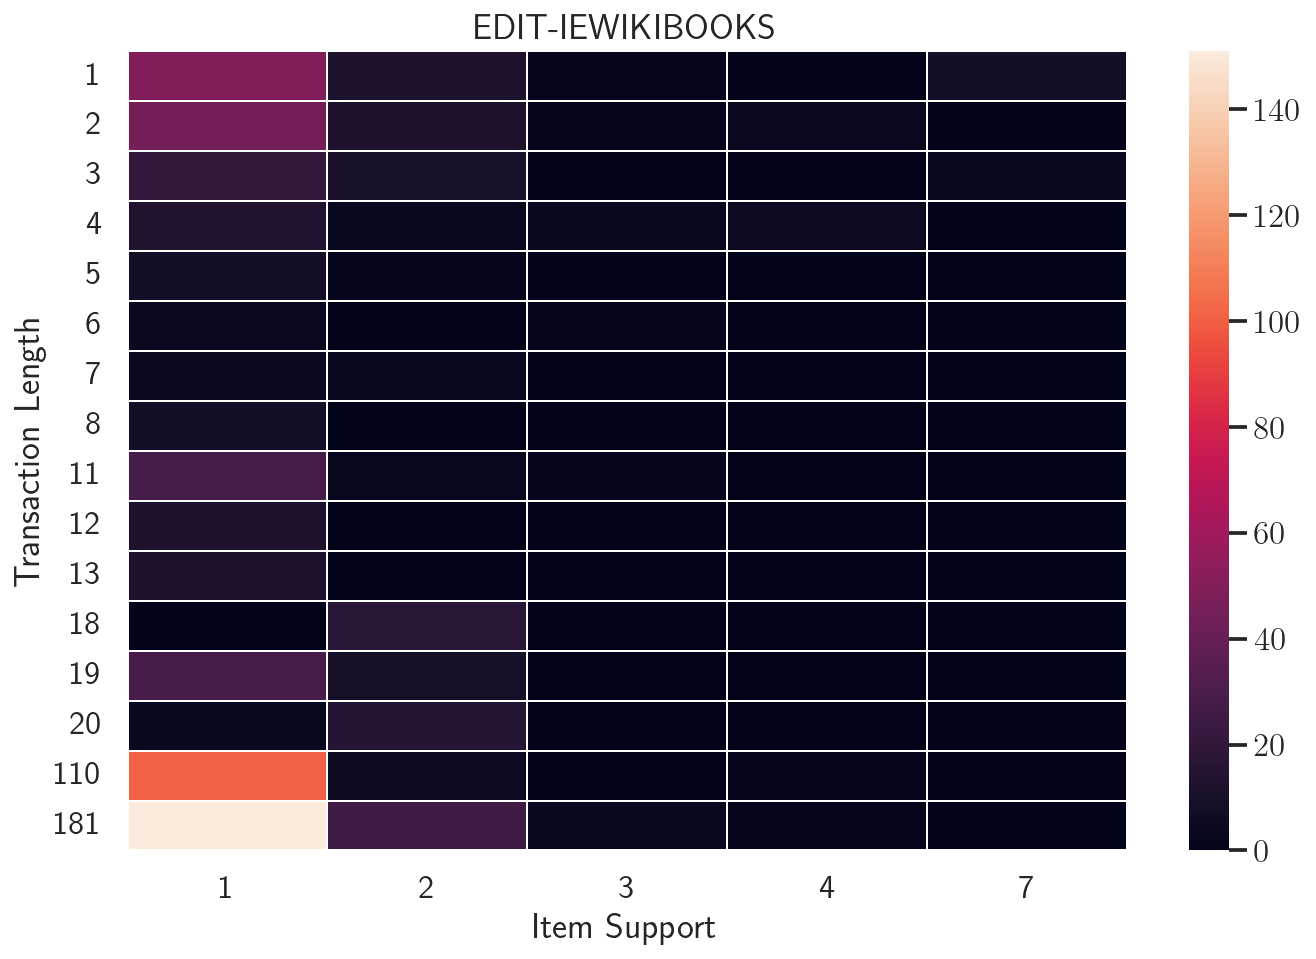

415 1803


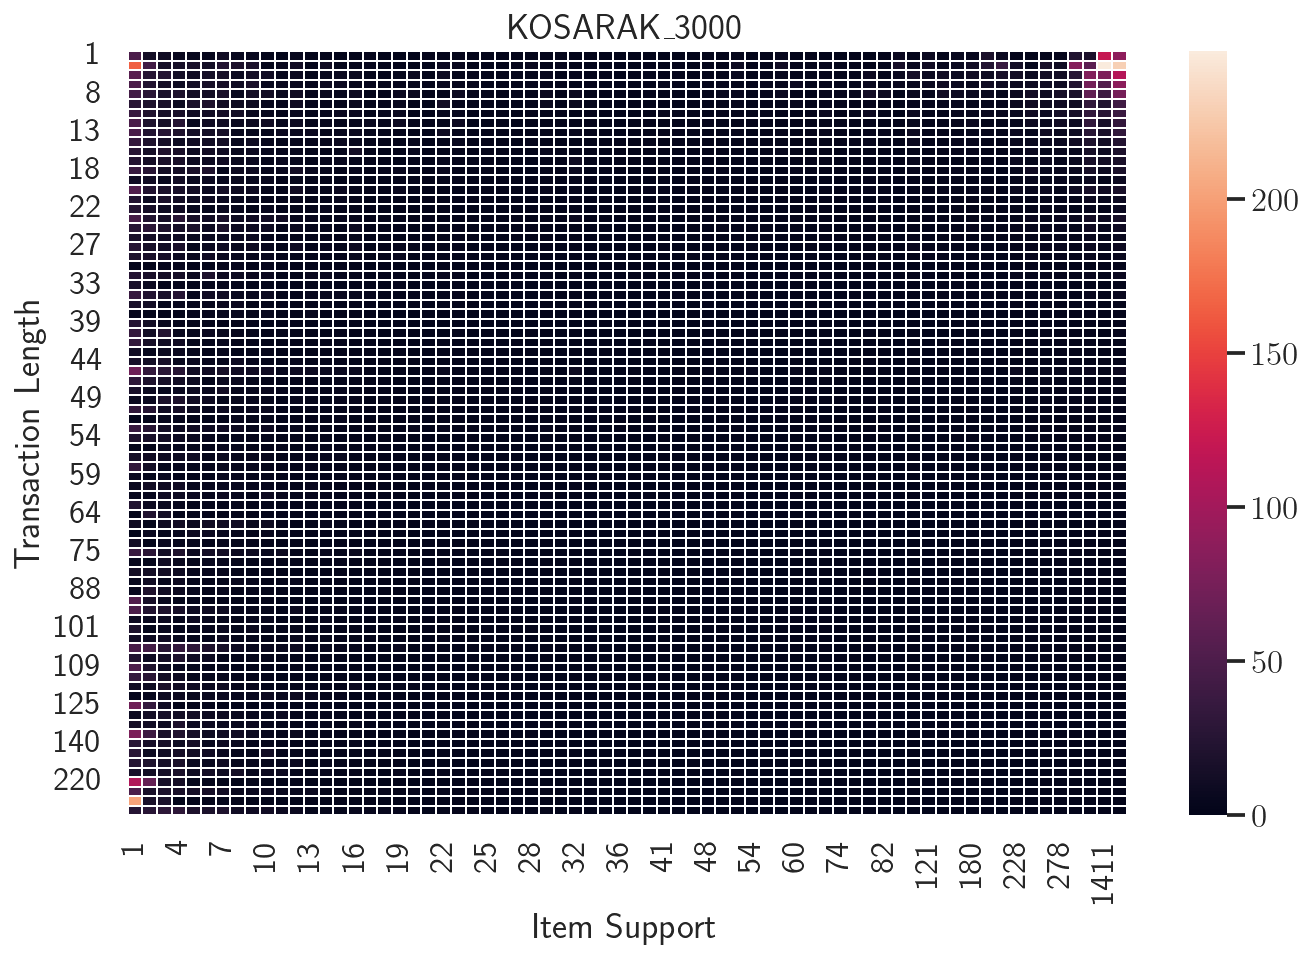

37 3195


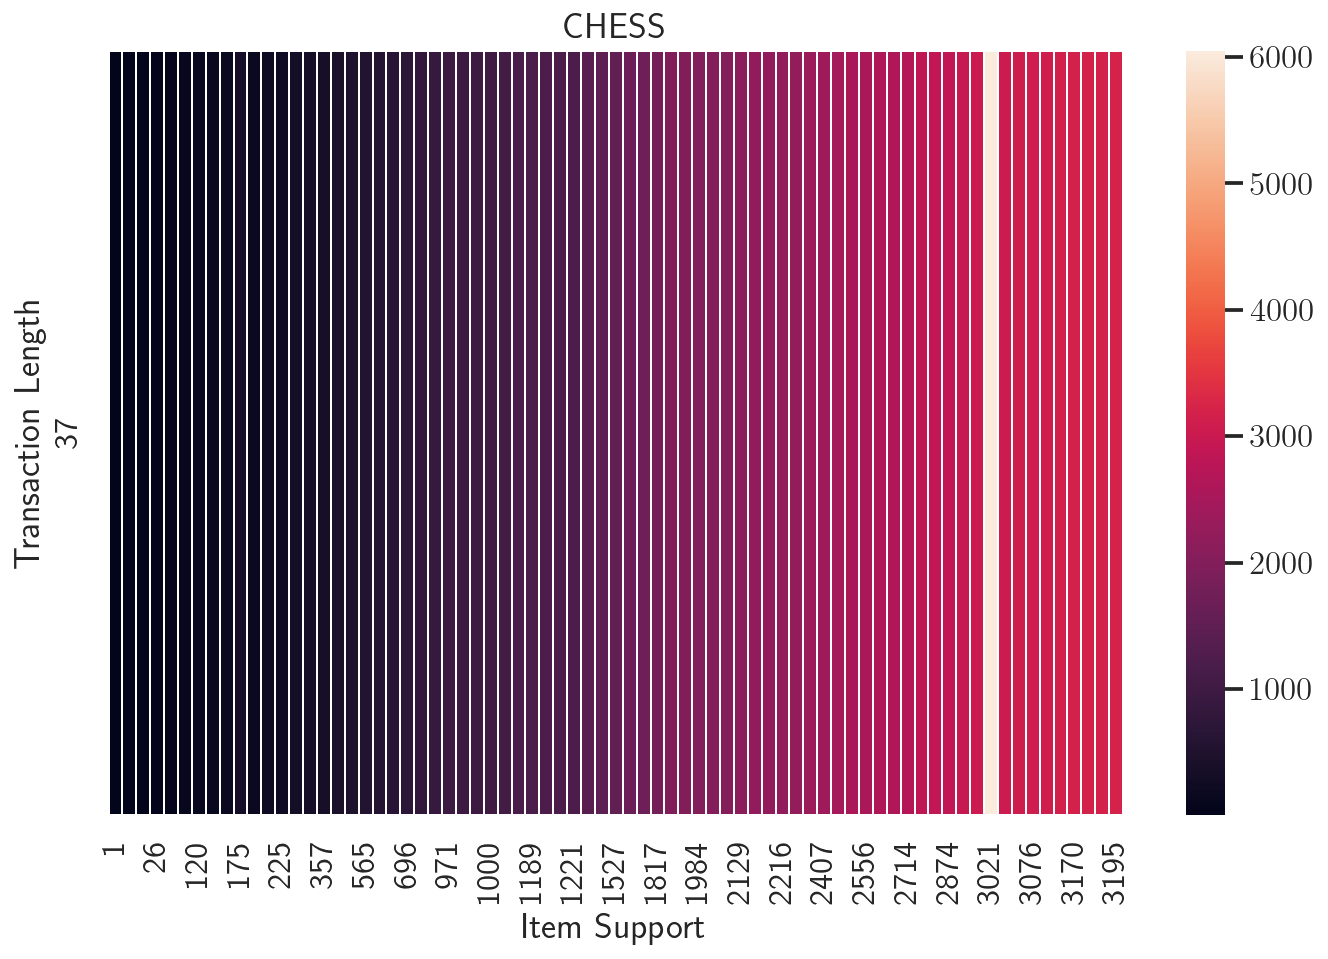

13 66


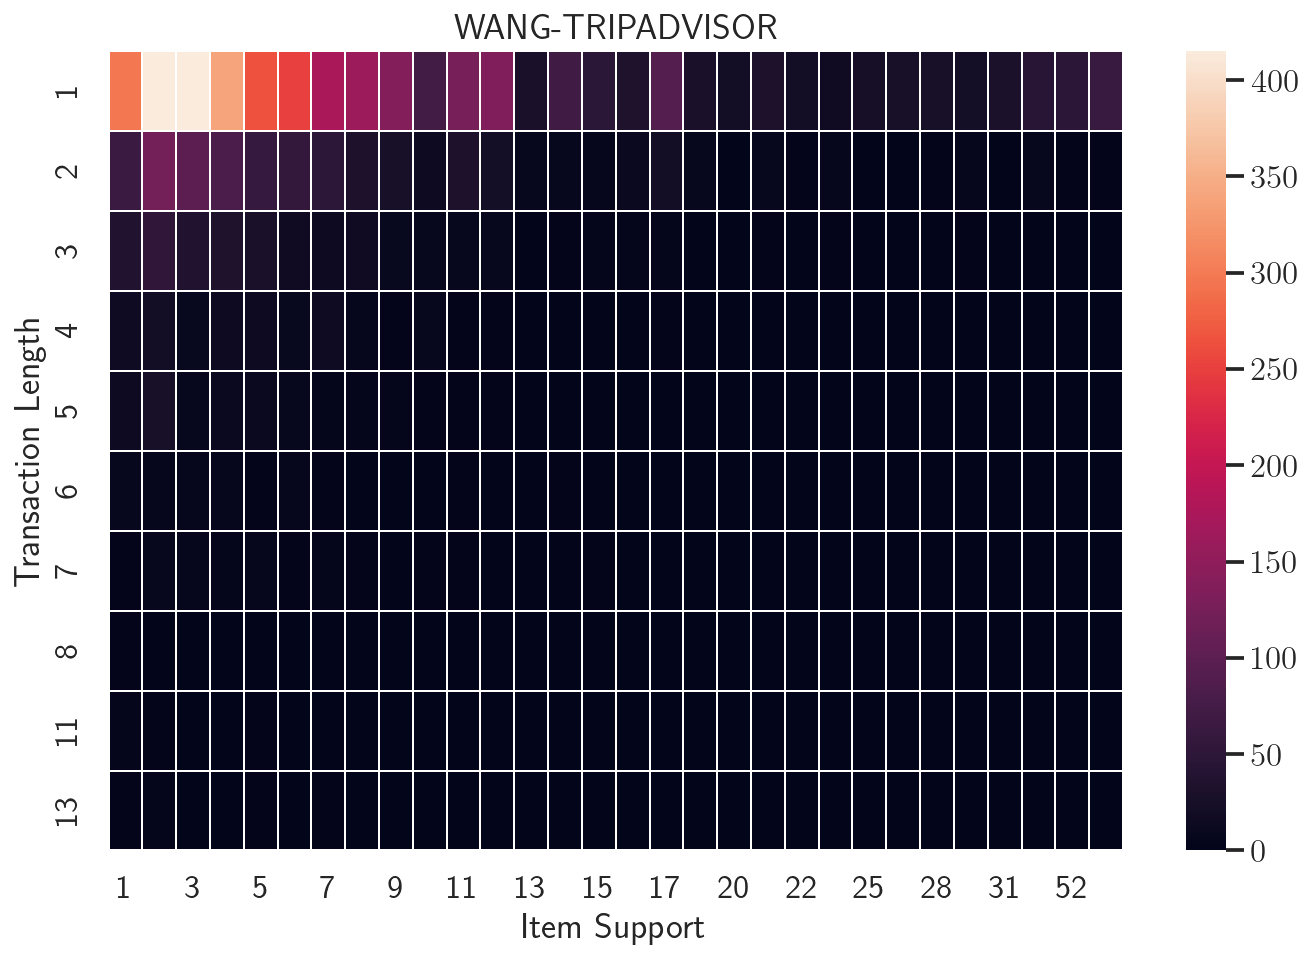

14 25


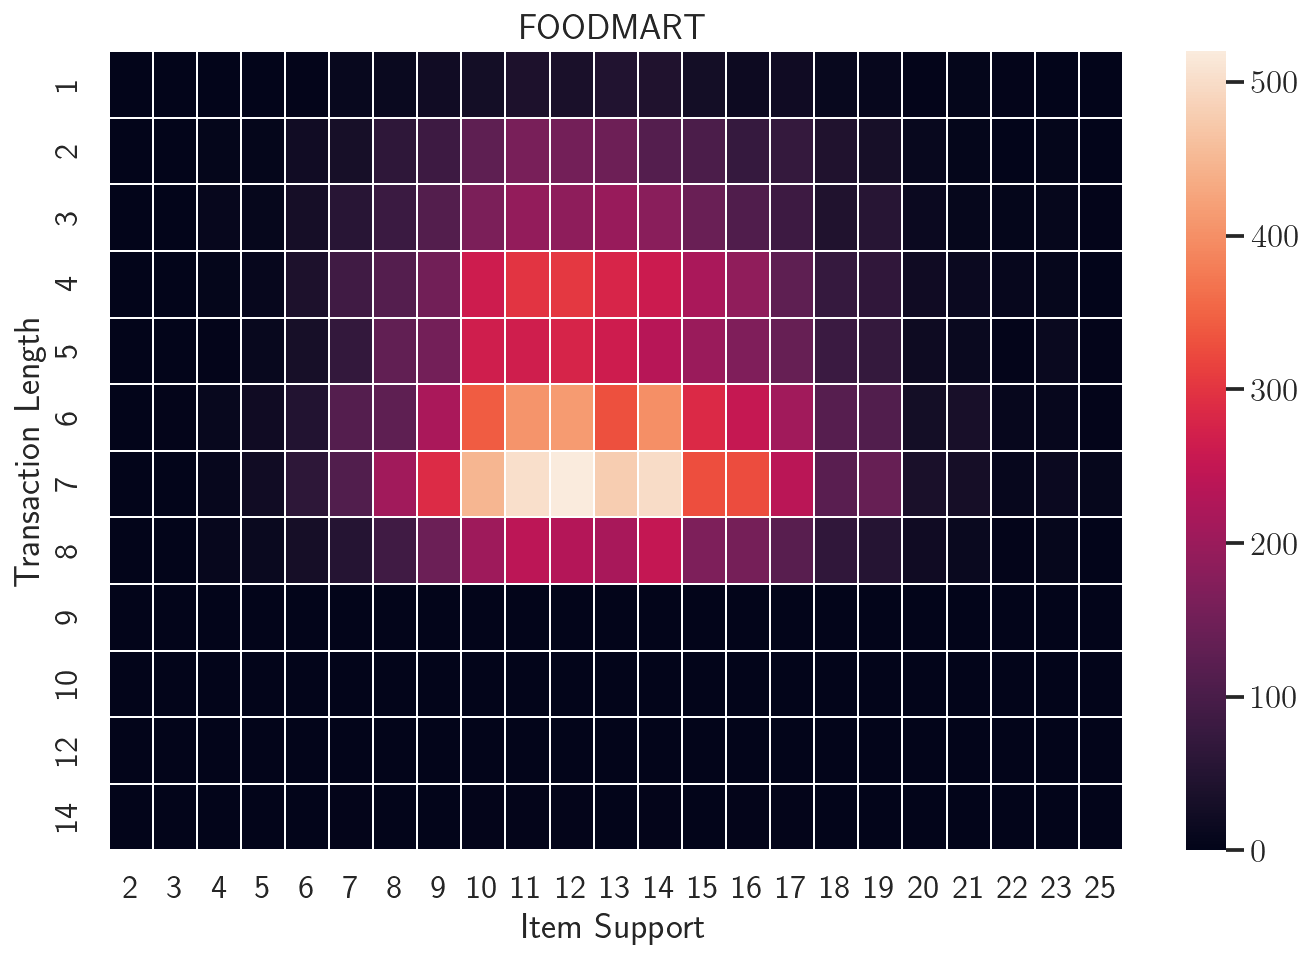

18 1394


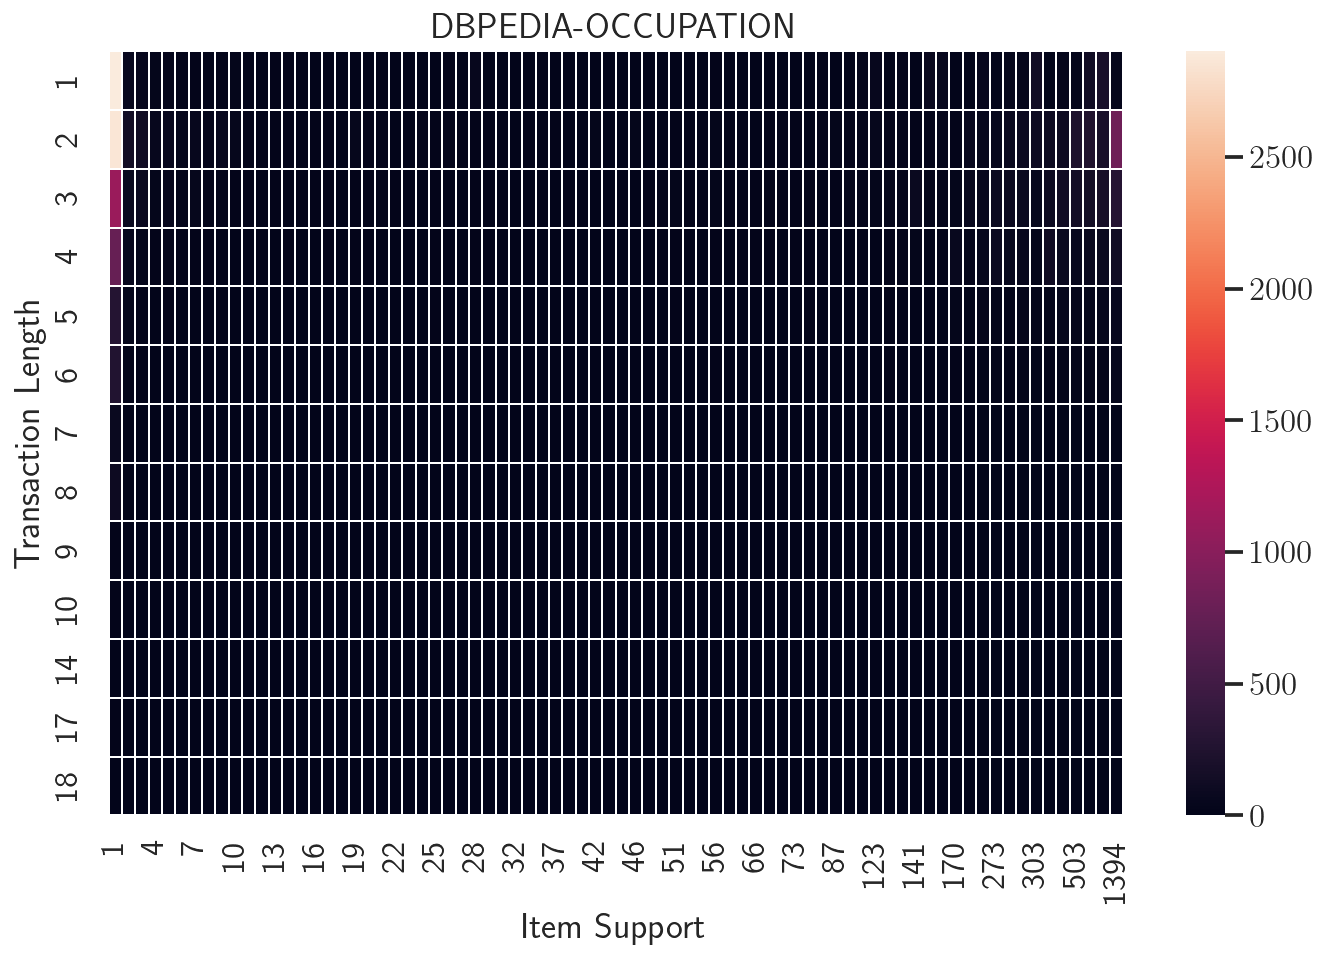

267 3658


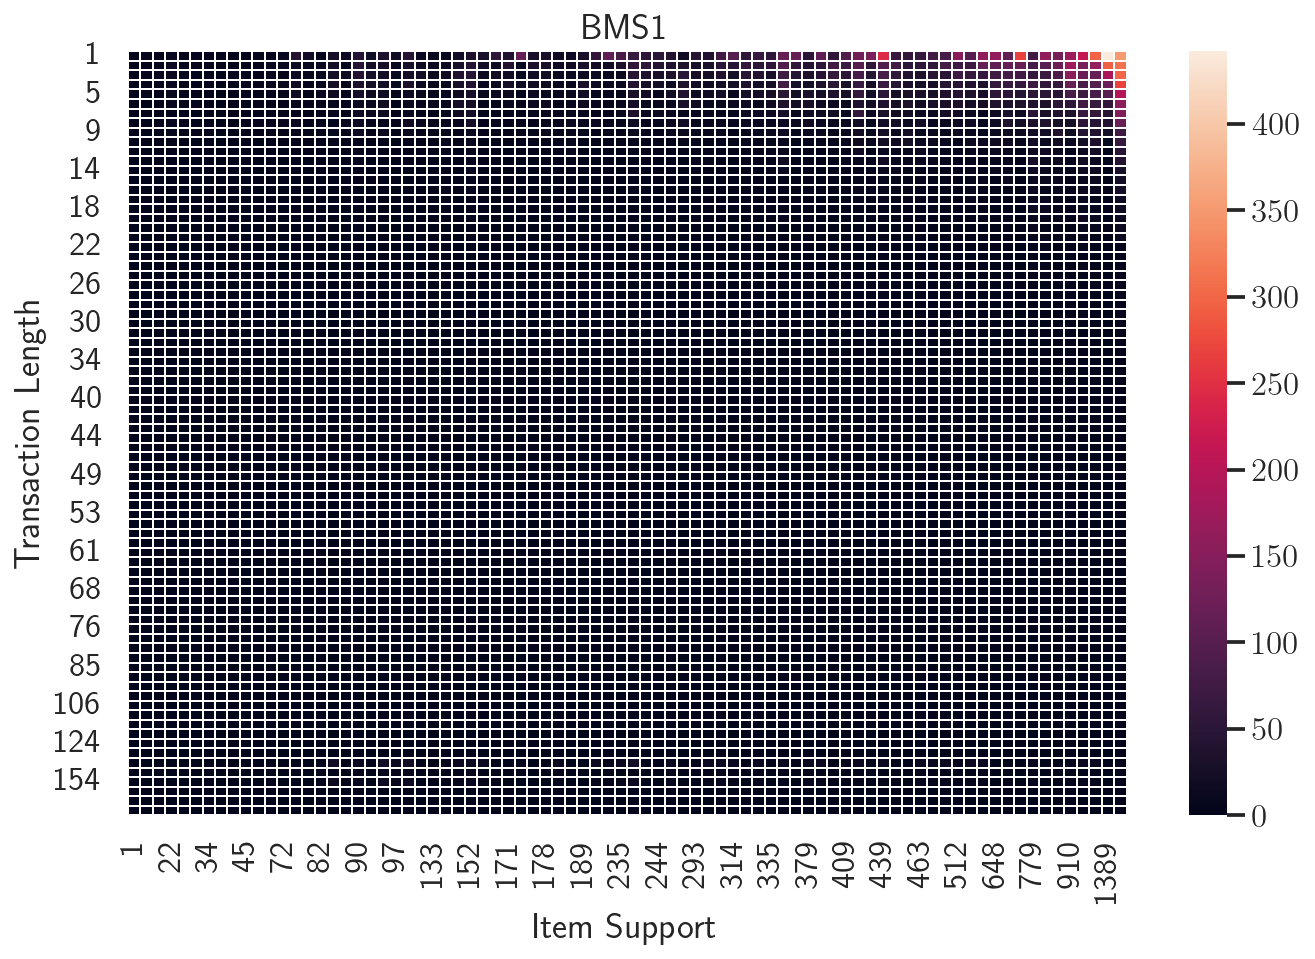

161 3766


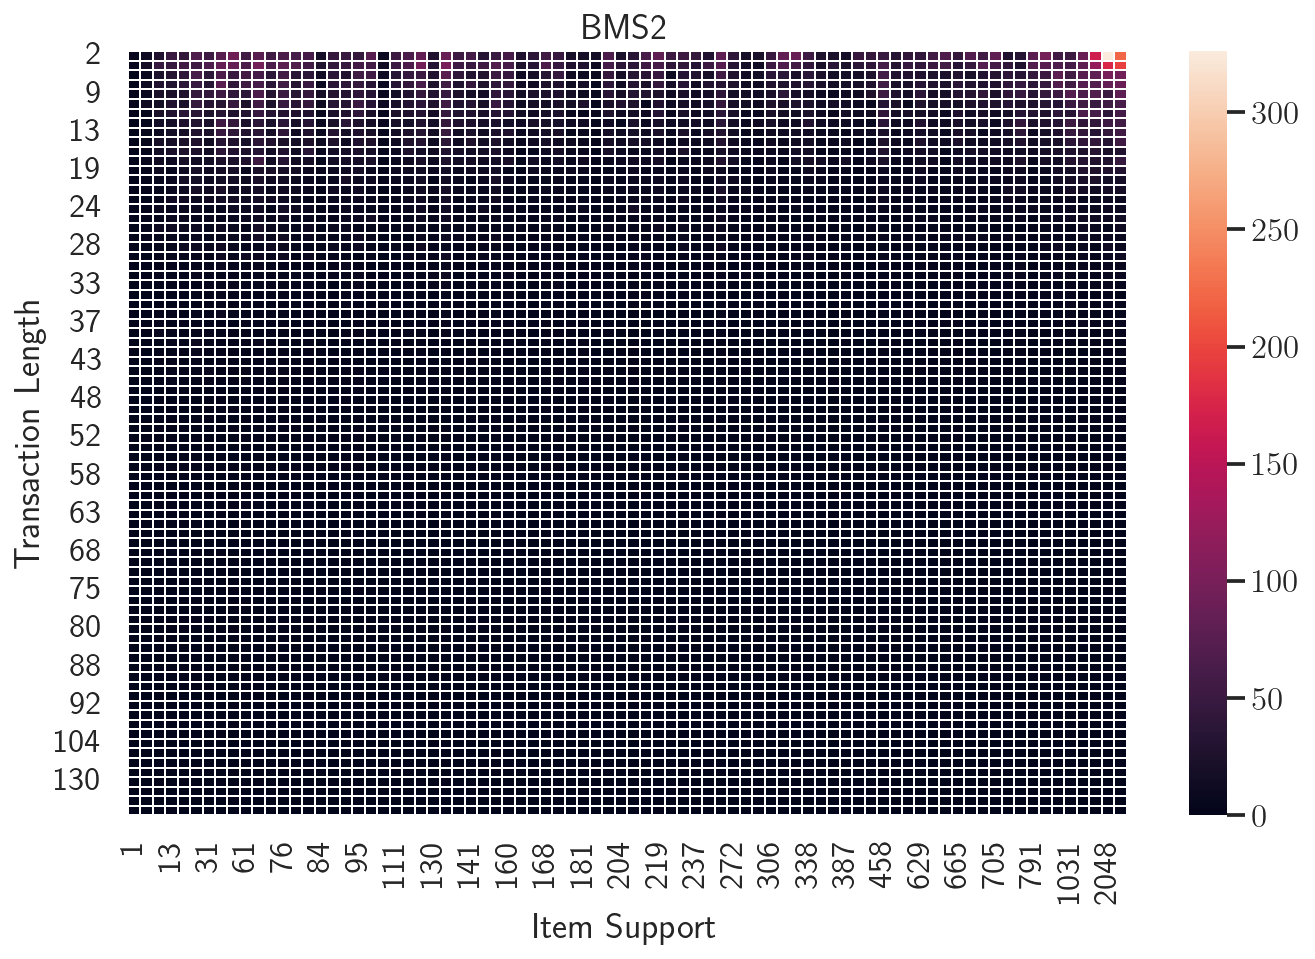

76 50675


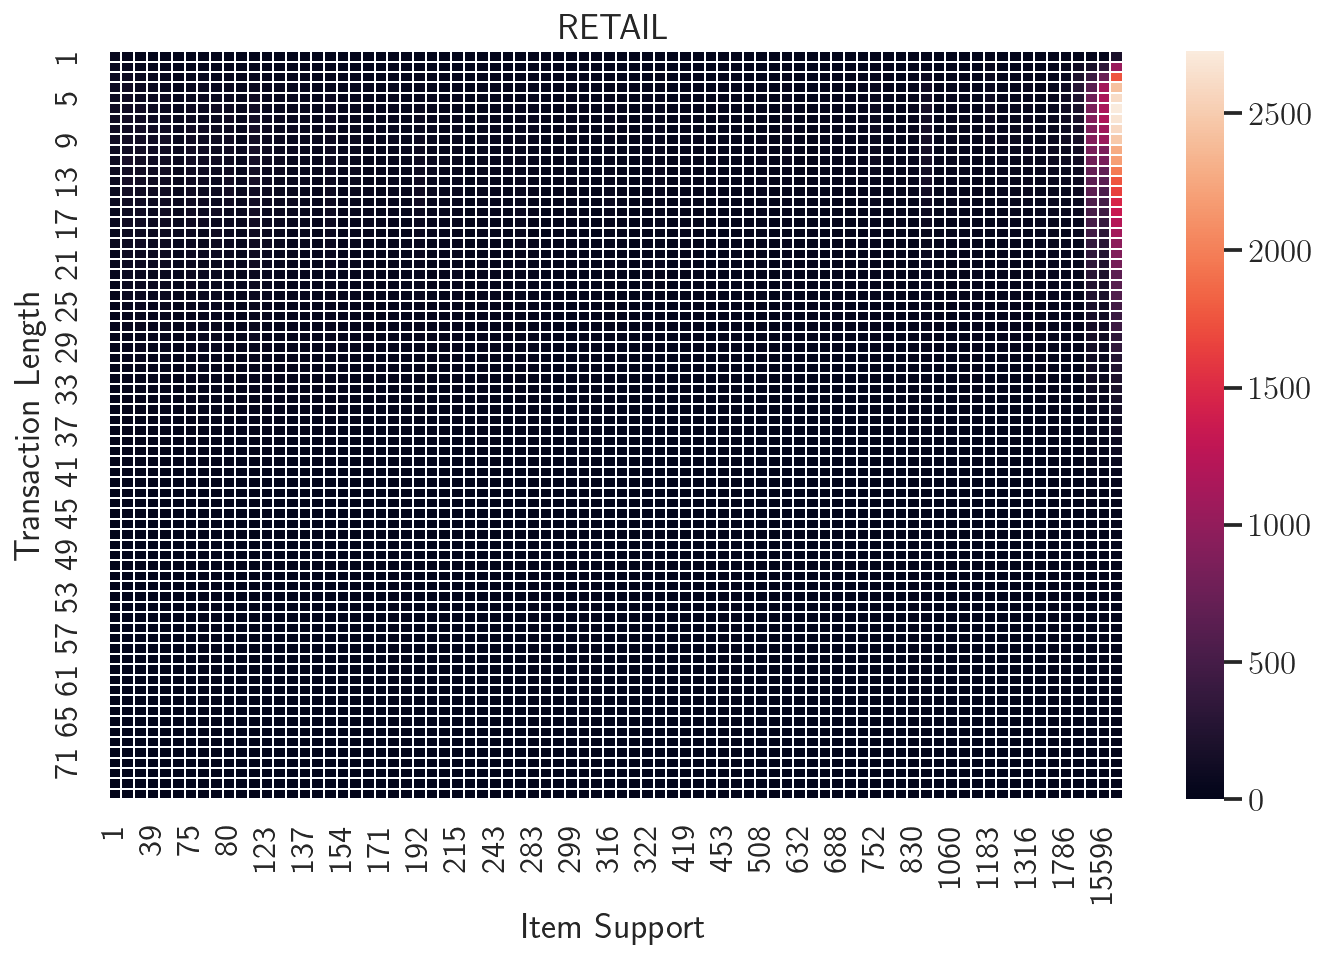

In [20]:
for dataset in datasets:
    BJDM, max_len = ds.compute_BJDM(data_dir, dataset)
    bjdm_df = pd.DataFrame(BJDM)
    fig, ax = plt.subplots(figsize=(10,7))
    # subset of cols
    ret_cols = []
    for c in bjdm_df.columns:
        if bjdm_df[c].sum() > 0:
            ret_cols.append(c)
    bjdm_df = bjdm_df[ret_cols]
    if len(ret_cols) > num_squares:
        cols = set()
        while len(cols) < num_squares:
            cols.add(ret_cols[random.randint(0, len(ret_cols)-1)])
        cols = sorted(list(cols))
        bjdm_df = bjdm_df[cols]
    # subset of rows
    ret_rows = []
    for r in bjdm_df.index:
        if bjdm_df.loc[r].sum() > 0:
            ret_rows.append(r)
    bjdm_df = bjdm_df.loc[ret_rows]
    if len(ret_rows) > num_squares:
        rows = set()
        while len(rows) < num_squares:
            rows.add(ret_rows[random.randint(0,len(ret_rows)-1)])
        rows = sorted(list(rows))
        bjdm_df = bjdm_df.loc[rows]
    # all transactions have the same length
    if bjdm_df.shape[0] == 1:
        bjdm_df = bjdm_df[bjdm_df>0].T.dropna().T
    sns.heatmap(data=bjdm_df, linewidths=1, ax=ax)
    ax.set_ylabel('Transaction Length')
    ax.set_xlabel('Item Support')
    x_labels = []
    for l in ax.get_xticklabels():
        x_labels.append(str(int(l.get_text())+1))
    y_labels = []
    if bjdm_df.shape[0] == 1:
        y_labels.append(str(max_len))
    else:
        for l in ax.get_yticklabels():
            y_labels.append(str(int(l.get_text())+1))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    ax.set_title(dataset.upper())
    plt.tight_layout()
    plt.show()

## Convergence

In [77]:
result_dir = '../output/convergence/'
# config
freqs = {'edit-iewikibooks':'10.0-0.014',
         'kosarak_3000':'6.0-0.003',
         'chess':'6.0-0.8', 
         'wang-tripadvisor':'6.0-5.0E-4',
         'foodmart':'6.0-3.0E-4',
         'dbpedia-occupation':'10.0-1.1E-4',
         'BMS1':'6.0-0.001', 
         'BMS2':'6.0-0.002', 
         'retail':'6.0-0.002'
         }

In [78]:
dfs = []
for db in freqs.keys():
    file = result_dir + f'{db}-{freqs[db]}-0.json'
    tmp_df = cs.get_convergence_df(file)
    tmp_df['DataSet'] = db
    dfs.append(tmp_df)

conv_df = pd.concat(dfs)

In [79]:
conv_df['Algorithm'] = conv_df['Algorithm'].apply(lambda x: sampler_names[x])

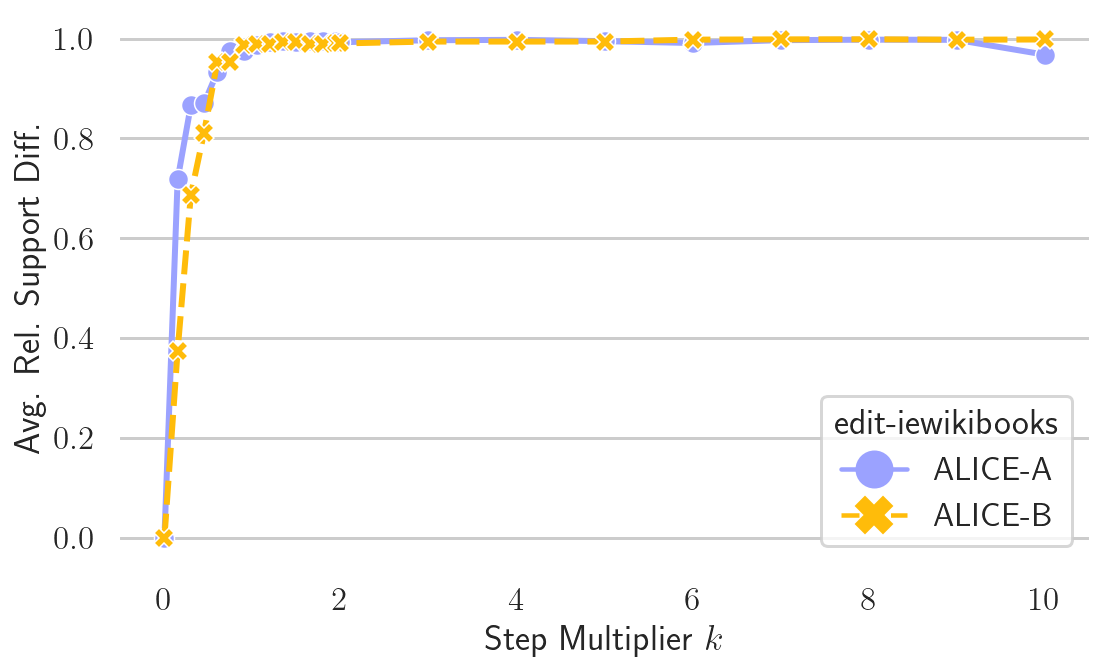

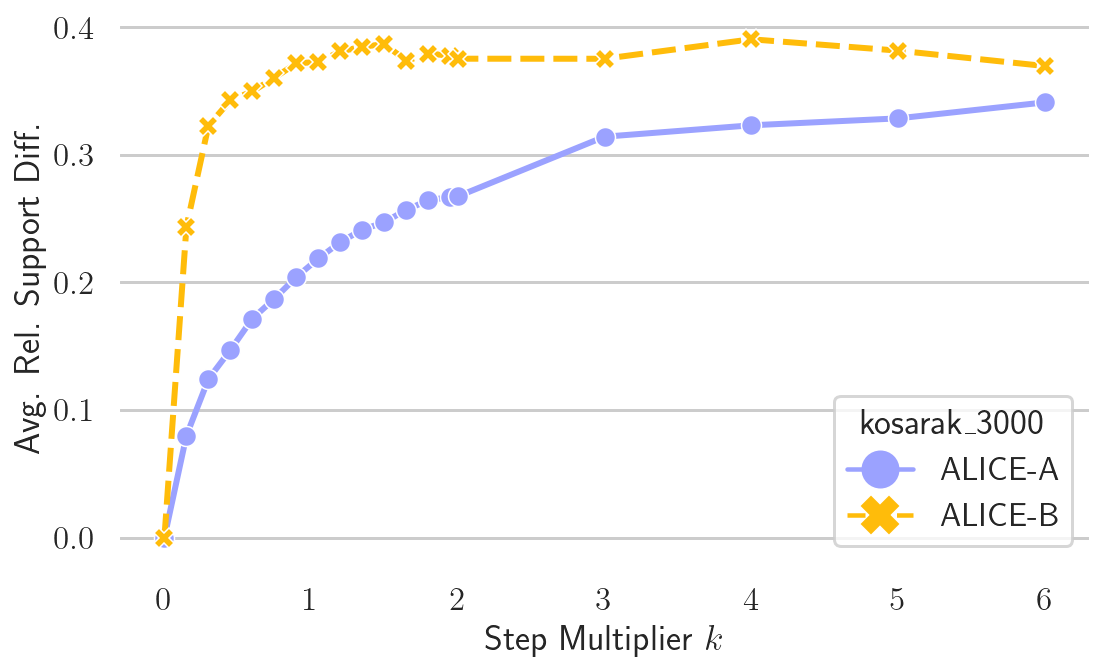

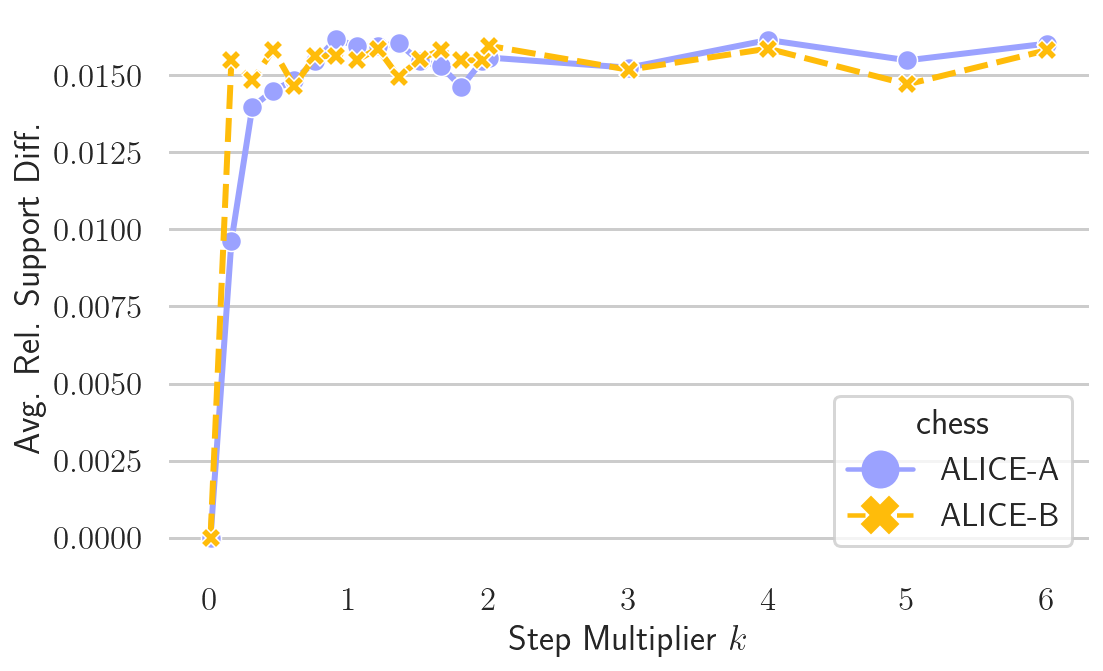

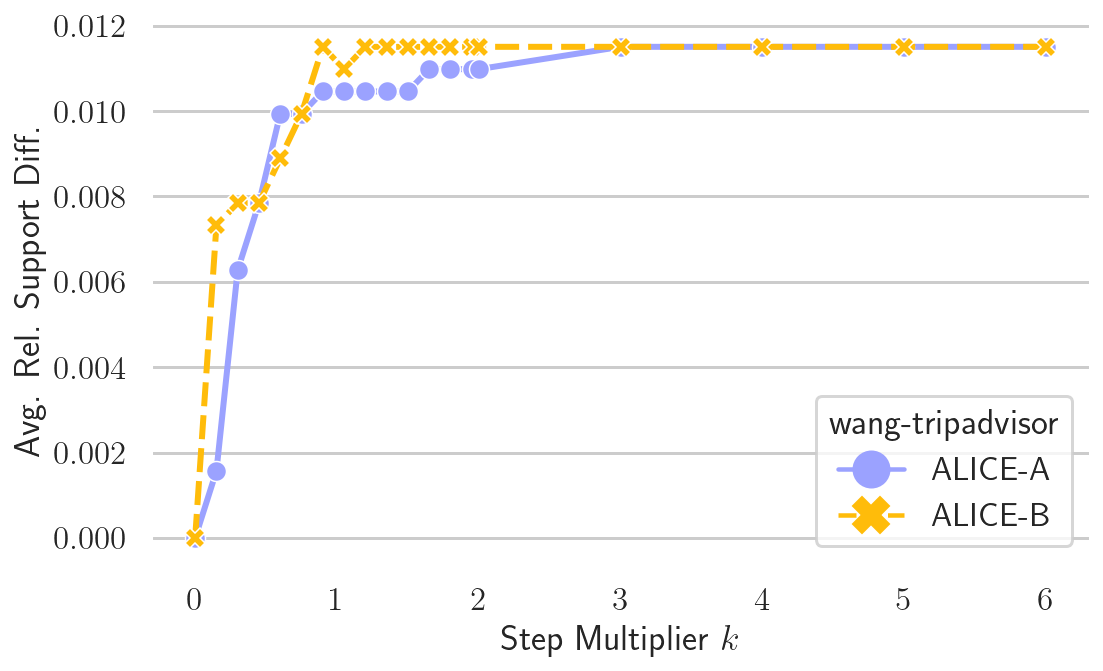

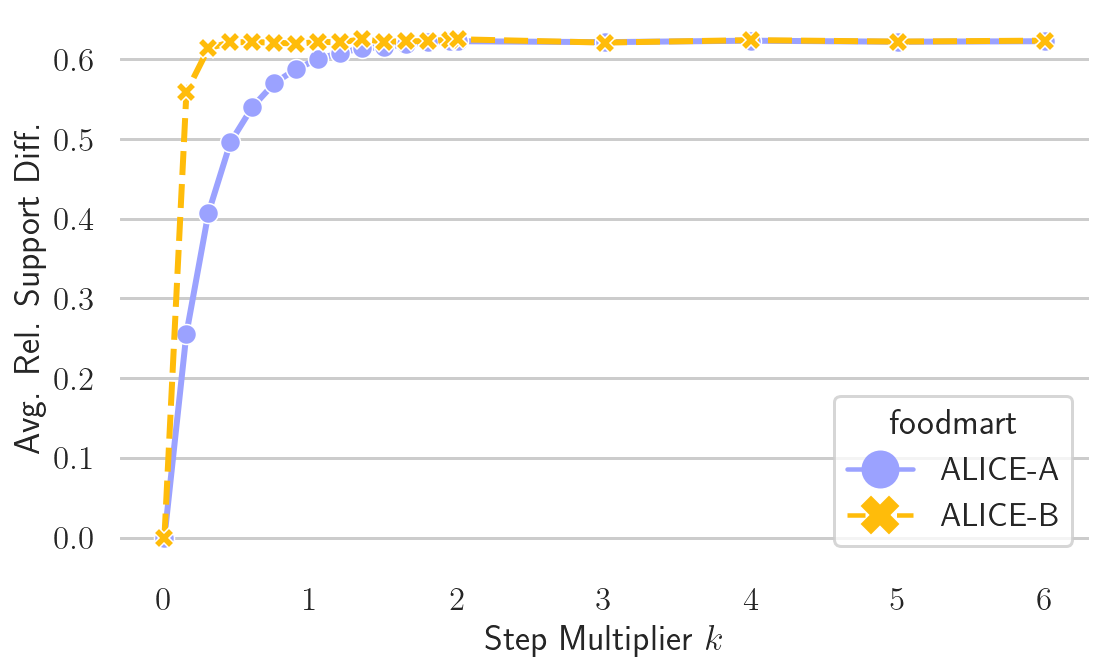

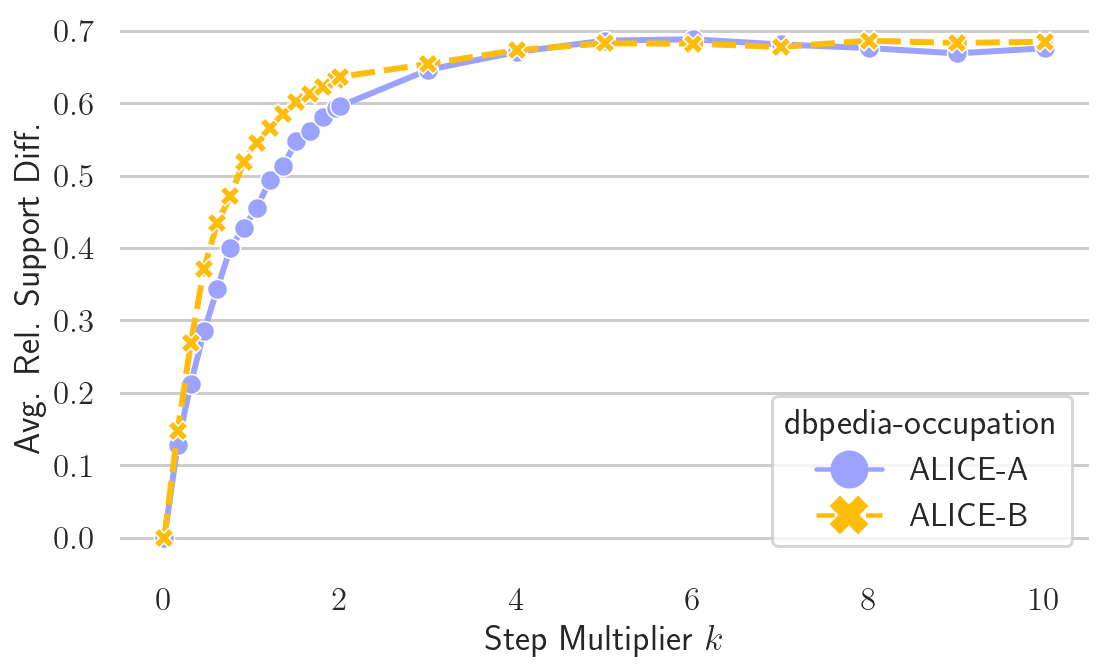

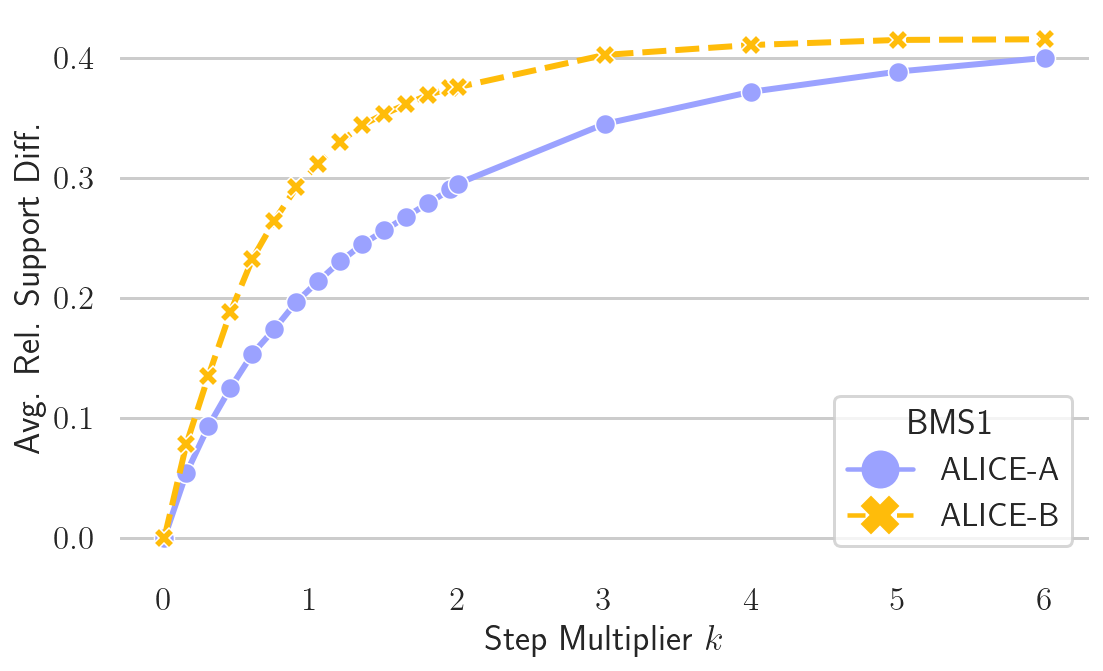

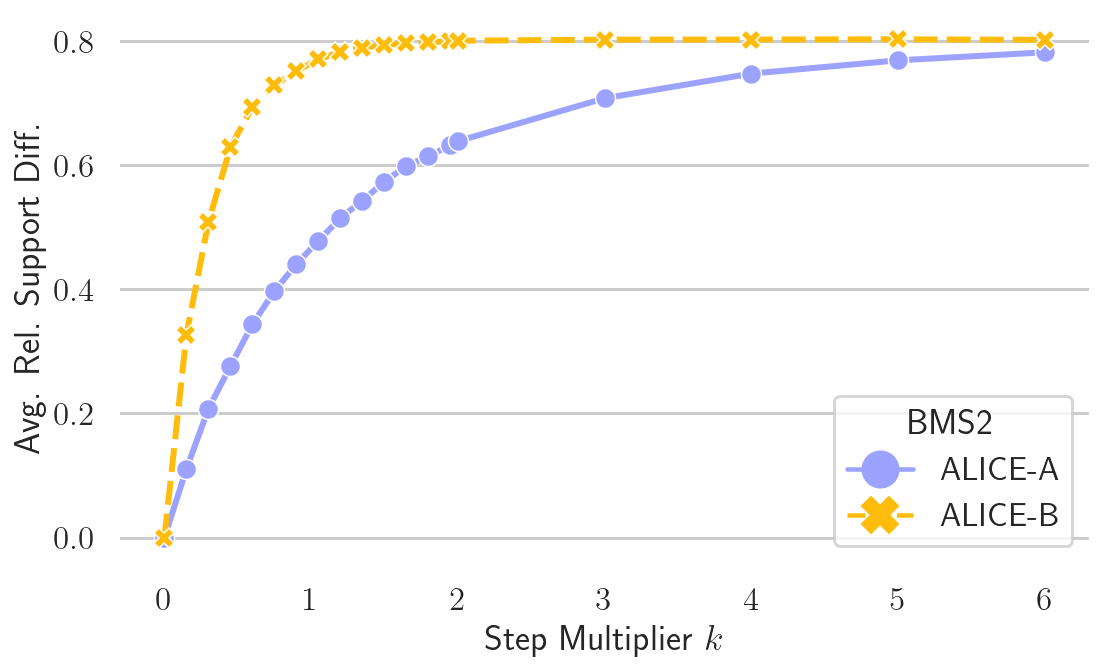

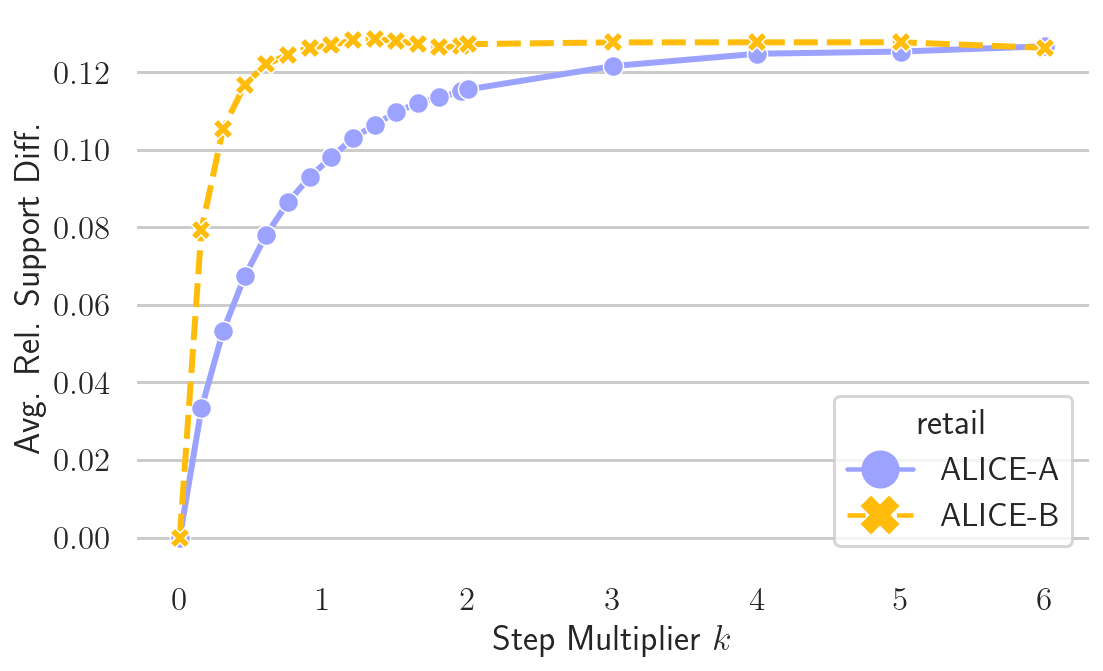

In [24]:
for dataset in freqs.keys():
    data = conv_df[conv_df['DataSet']==dataset]
    num_colors = len(data['Algorithm'].unique())
    if not data.empty:
        fig, ax = plt.subplots(figsize=(8,5))
        sns.lineplot(data=data, x='Num Step Multiplier', palette=palette[:num_colors], 
                     style='Algorithm', markers=True, markersize=10, ax=ax,
                     linewidth=3, y='Avg. Rel. Support Diff.', hue='Algorithm')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_xlabel(r'Step Multiplier $k$')
        ax.legend(title=dataset)
        plt.tight_layout()
        plt.savefig(fig_dir+f'convergence_{dataset}.pdf')

Single plot with 3 datasets

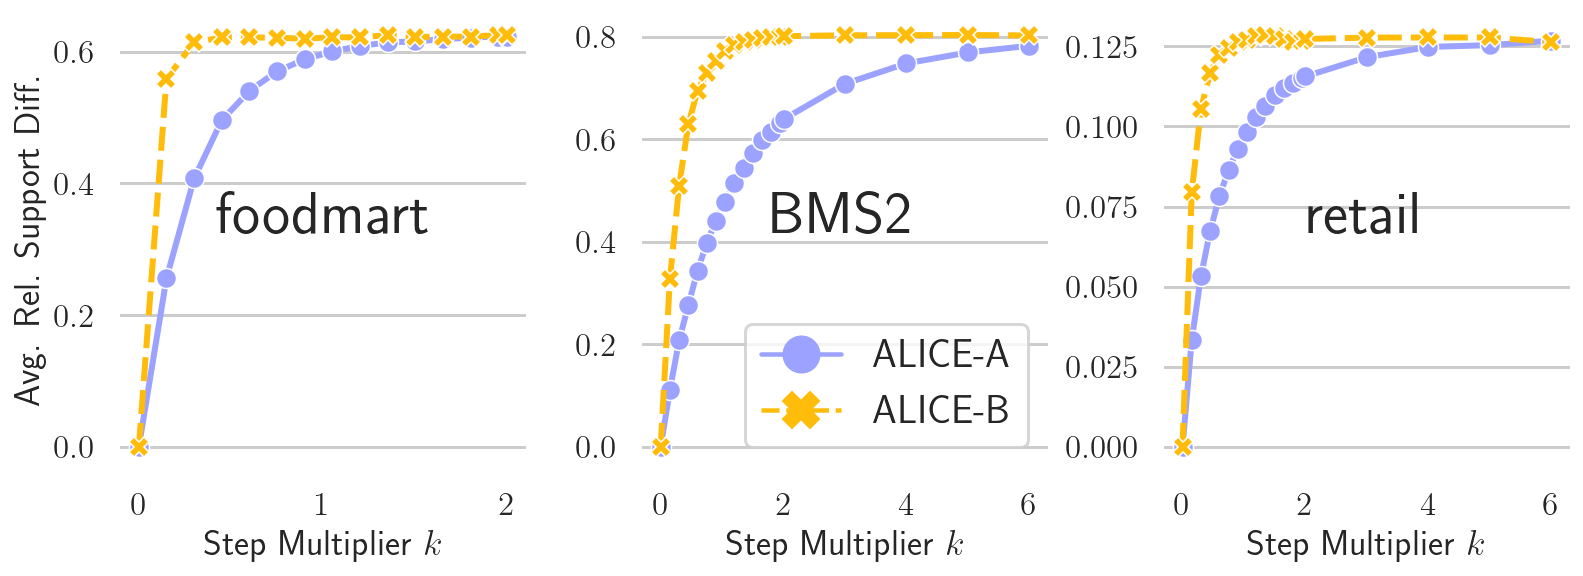

In [95]:
fig, ax = plt.subplots(1,3, figsize=(11,4))

for idx, dataset in enumerate(['foodmart', 'BMS2', 'retail']):
    data = conv_df[conv_df['DataSet']==dataset].copy()
    num_colors = len(data['Algorithm'].unique())
    
    if dataset in ['foodmart']:
        data = data[data['Num Step Multiplier']<=2]
    sns.lineplot(data=data, x='Num Step Multiplier', palette=palette[:num_colors], 
                 style='Algorithm', markers=True, markersize=10, ax=ax[idx],
                 linewidth=3, y='Avg. Rel. Support Diff.', hue='Algorithm',
                 hue_order=['ALICE-A', 'ALICE-B'])
    ax[idx].spines['right'].set_visible(False)
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['left'].set_visible(False)
    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].set_xlabel(r'Step Multiplier $k$')
    if idx != 0:
        ax[idx].set_ylabel('')
    # legend
    leg = ax[idx].legend()
    for line in leg.get_lines():
        line.set_linewidth(3.0)
#     ax[idx].legend(loc=(-0.8,0.4), fontsize=20)
    ax[idx].legend(fontsize=20)
    if idx != 1:
        ax[idx].legend().remove()  
    ax[idx].set_title(dataset, fontsize=30, pad=-110)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(fig_dir+'convergence_all.pdf', bbox_inches='tight')

### Time to Convergence

In [85]:
conv_time_df = conv_df.merge(stats_df[['DataSet', 'Sum Transaction Lengths']], on='DataSet')

In [86]:
conv_time_df['Time'] = conv_time_df['Setup'] + conv_time_df['Total'] 

In [87]:
conv_time_df['Time (s)'] = conv_time_df['Time'] / 1000

EDIT-IEWIKIBOOKS


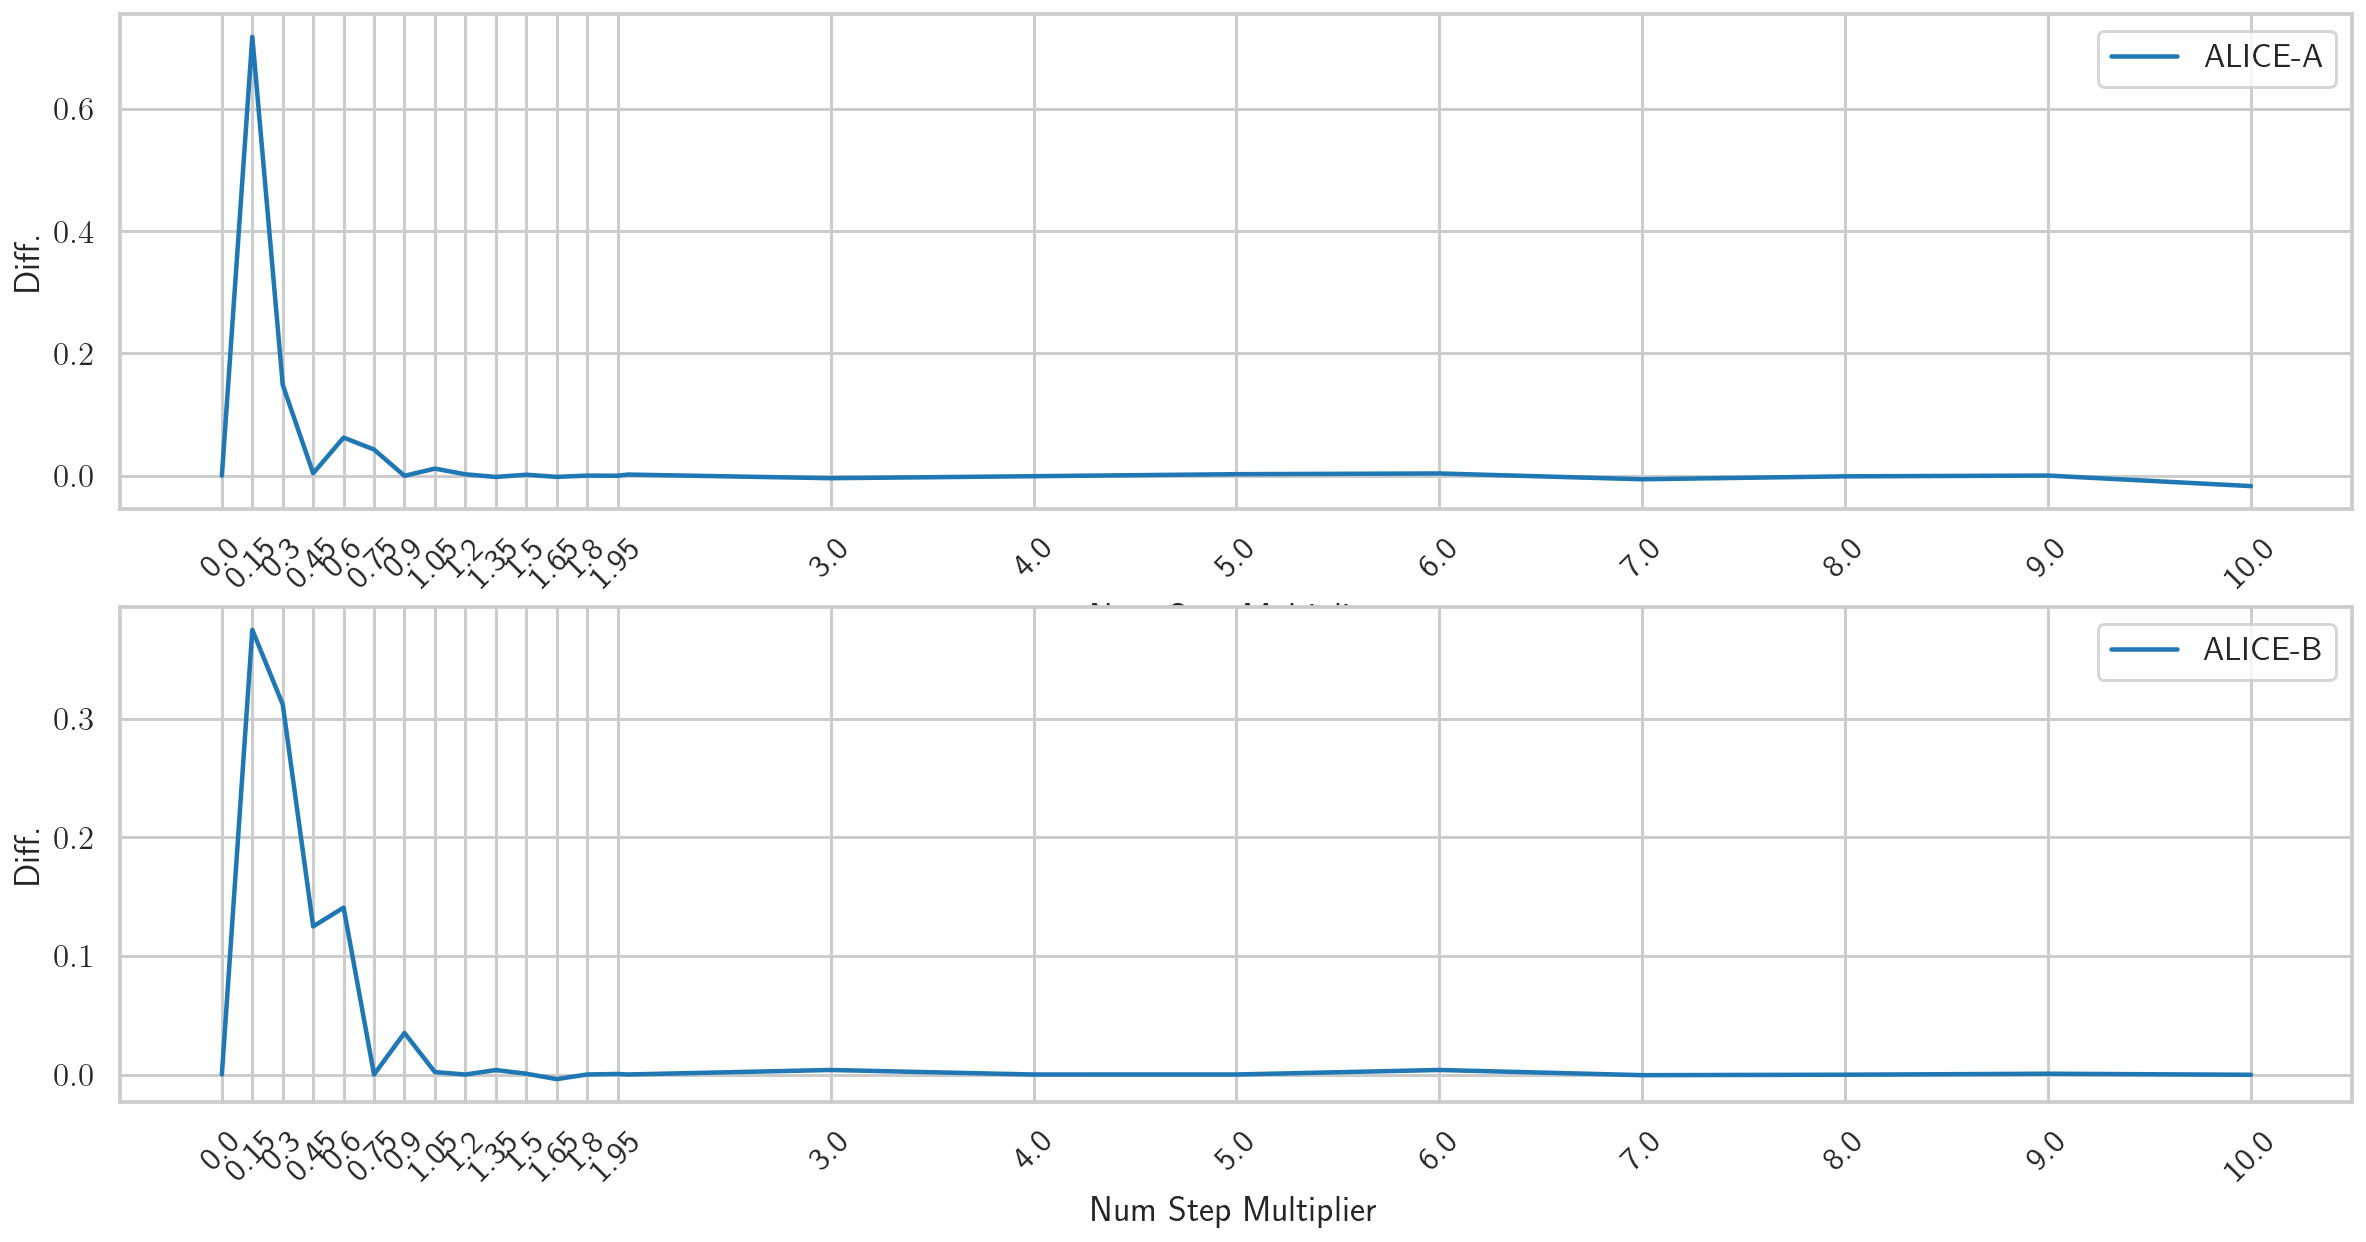

KOSARAK_3000


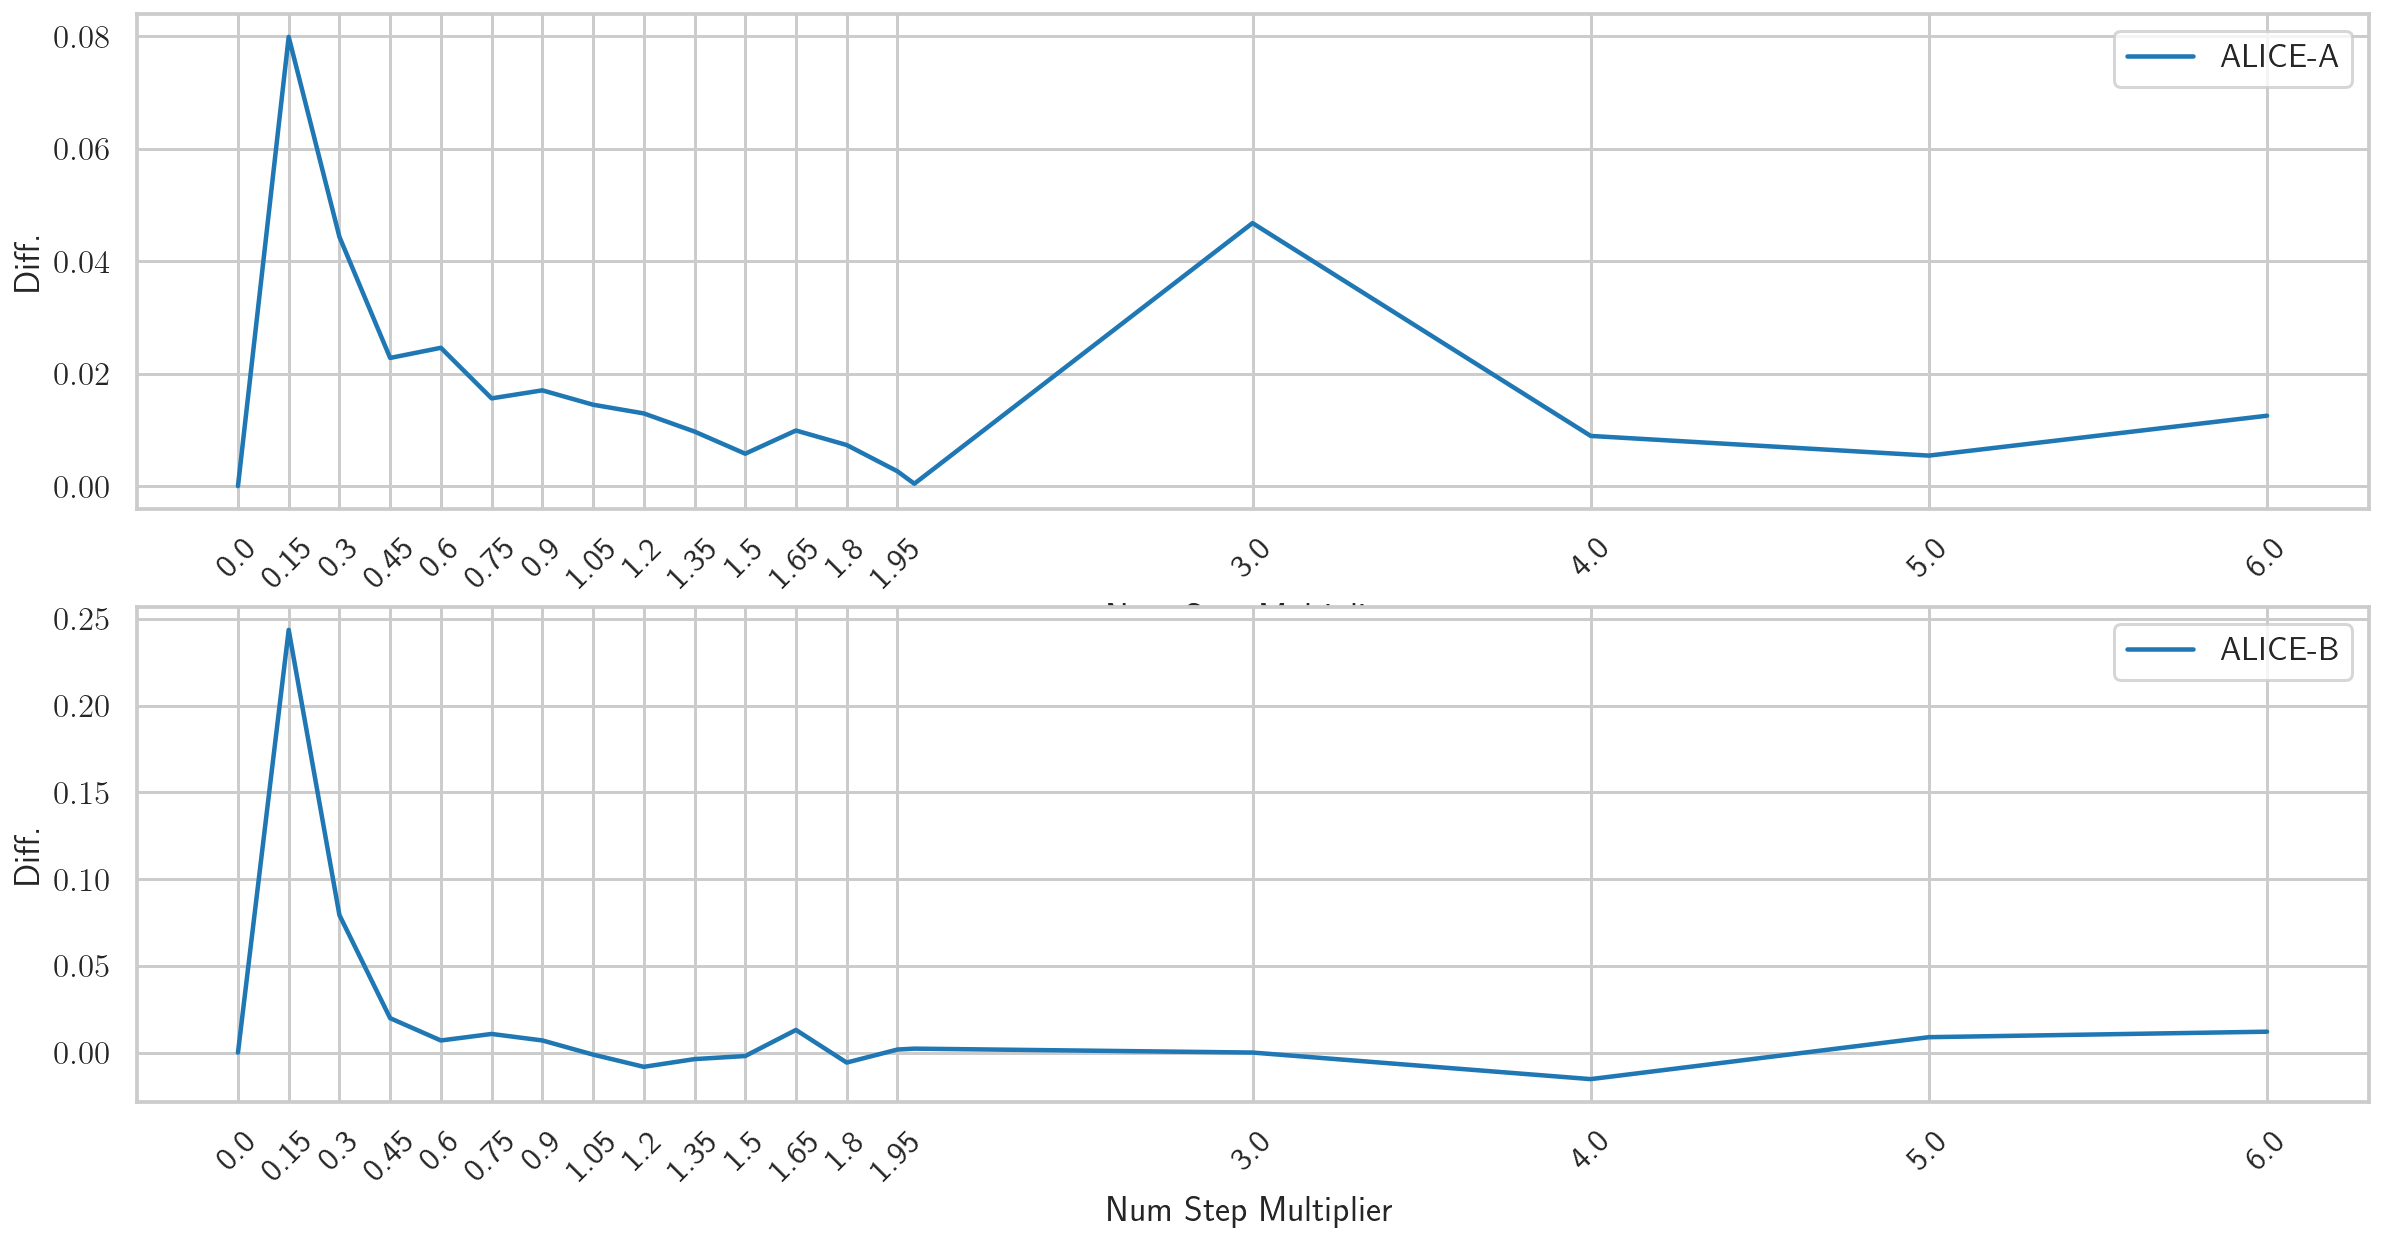

CHESS


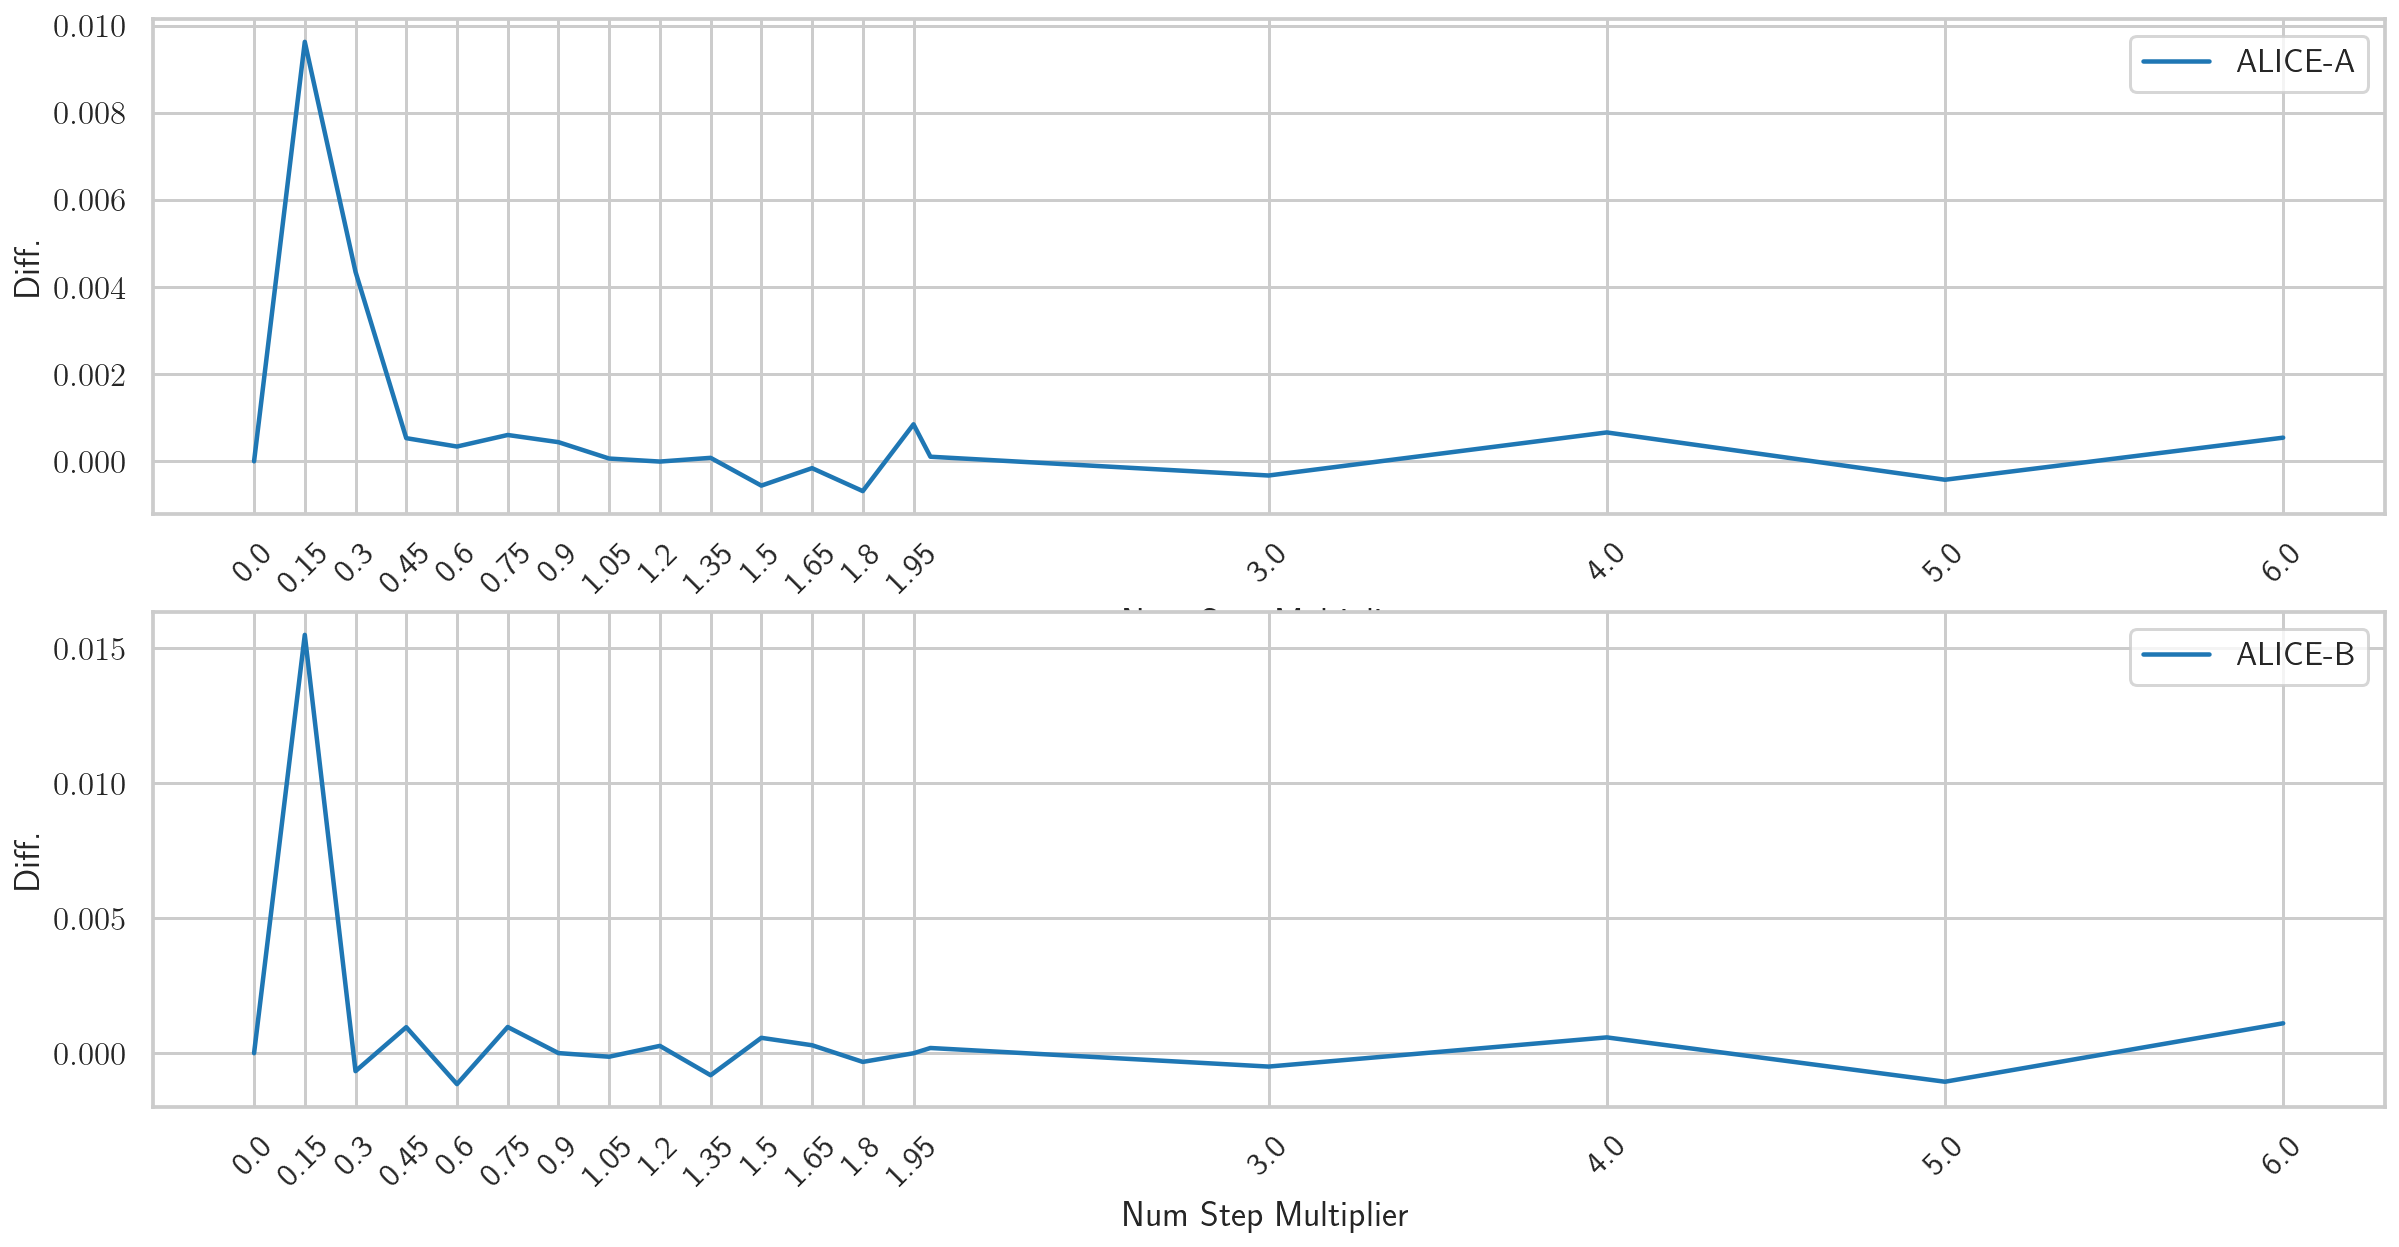

WANG-TRIPADVISOR


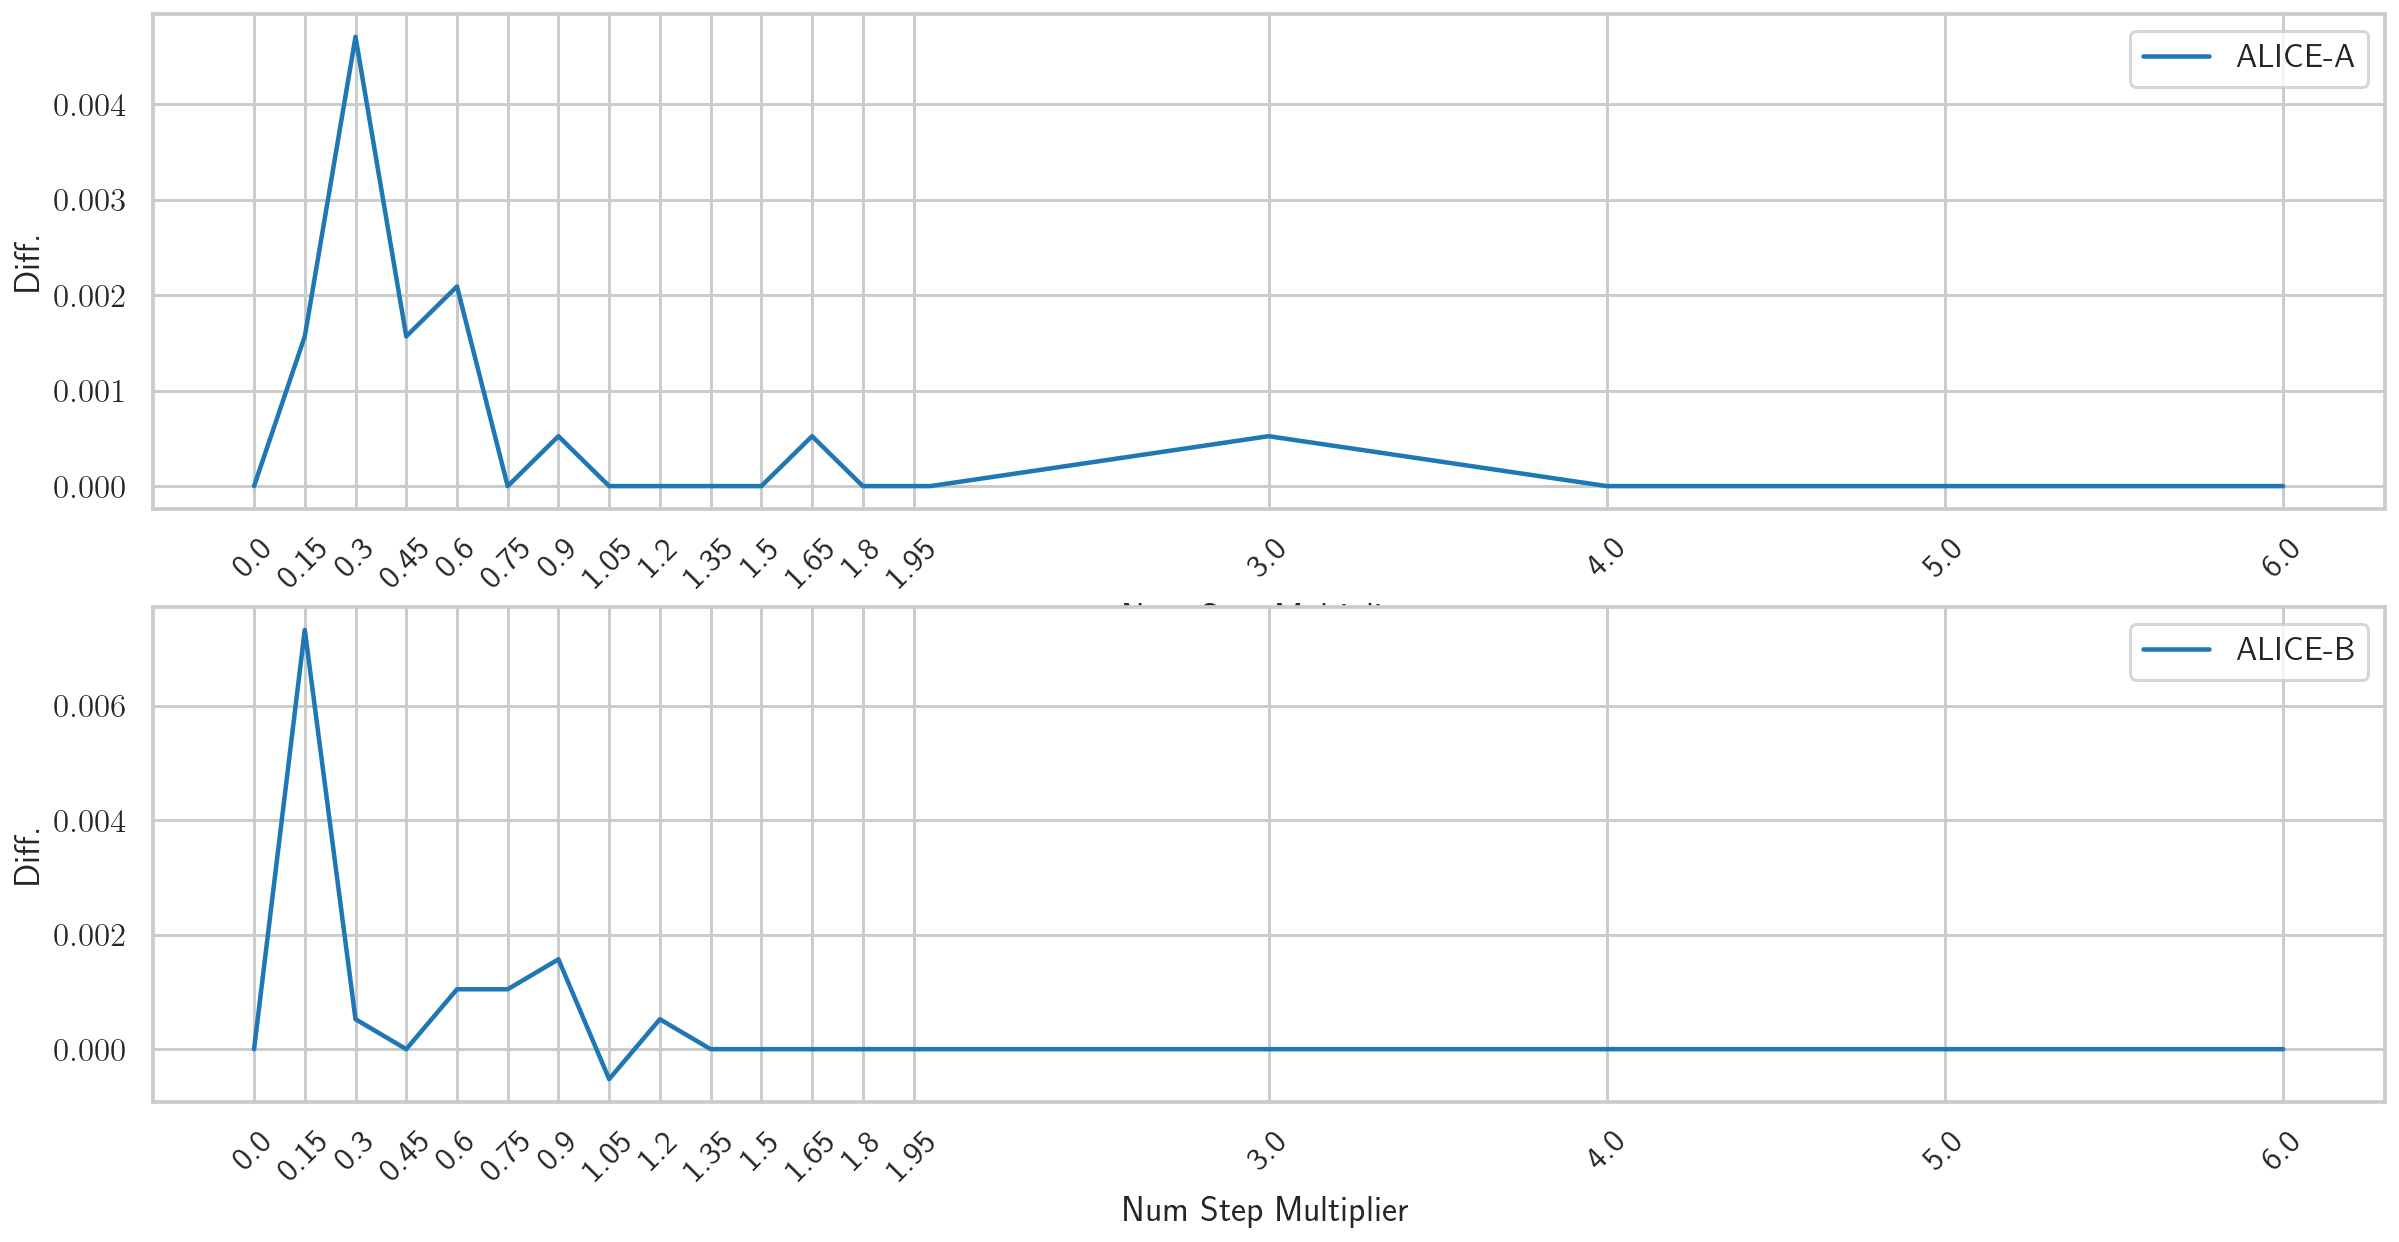

FOODMART


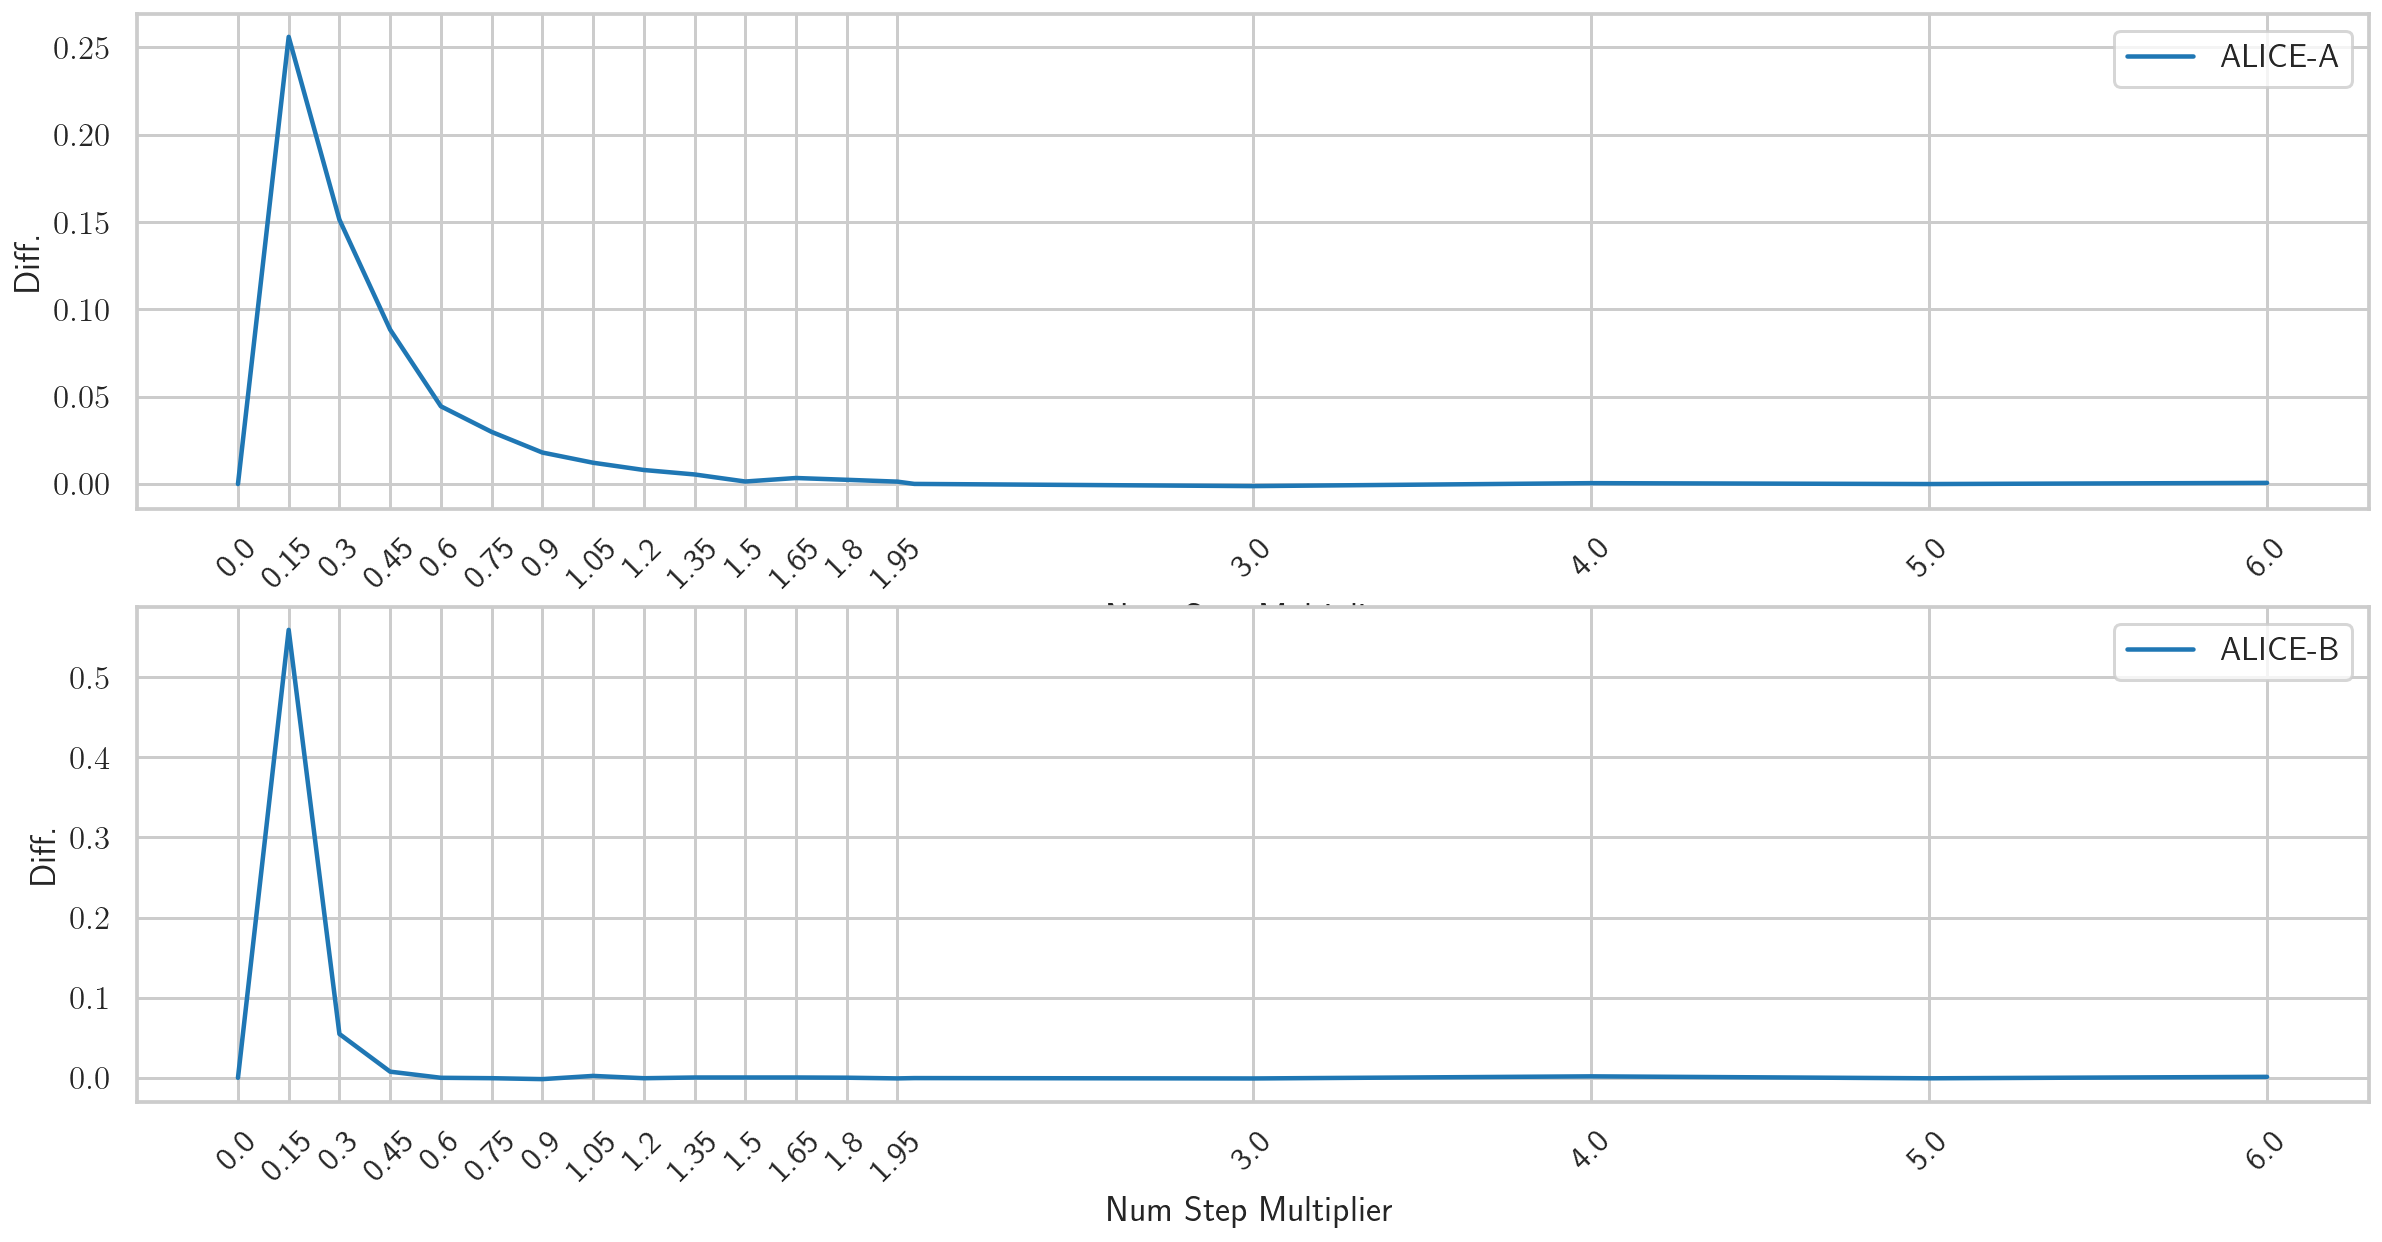

DBPEDIA-OCCUPATION


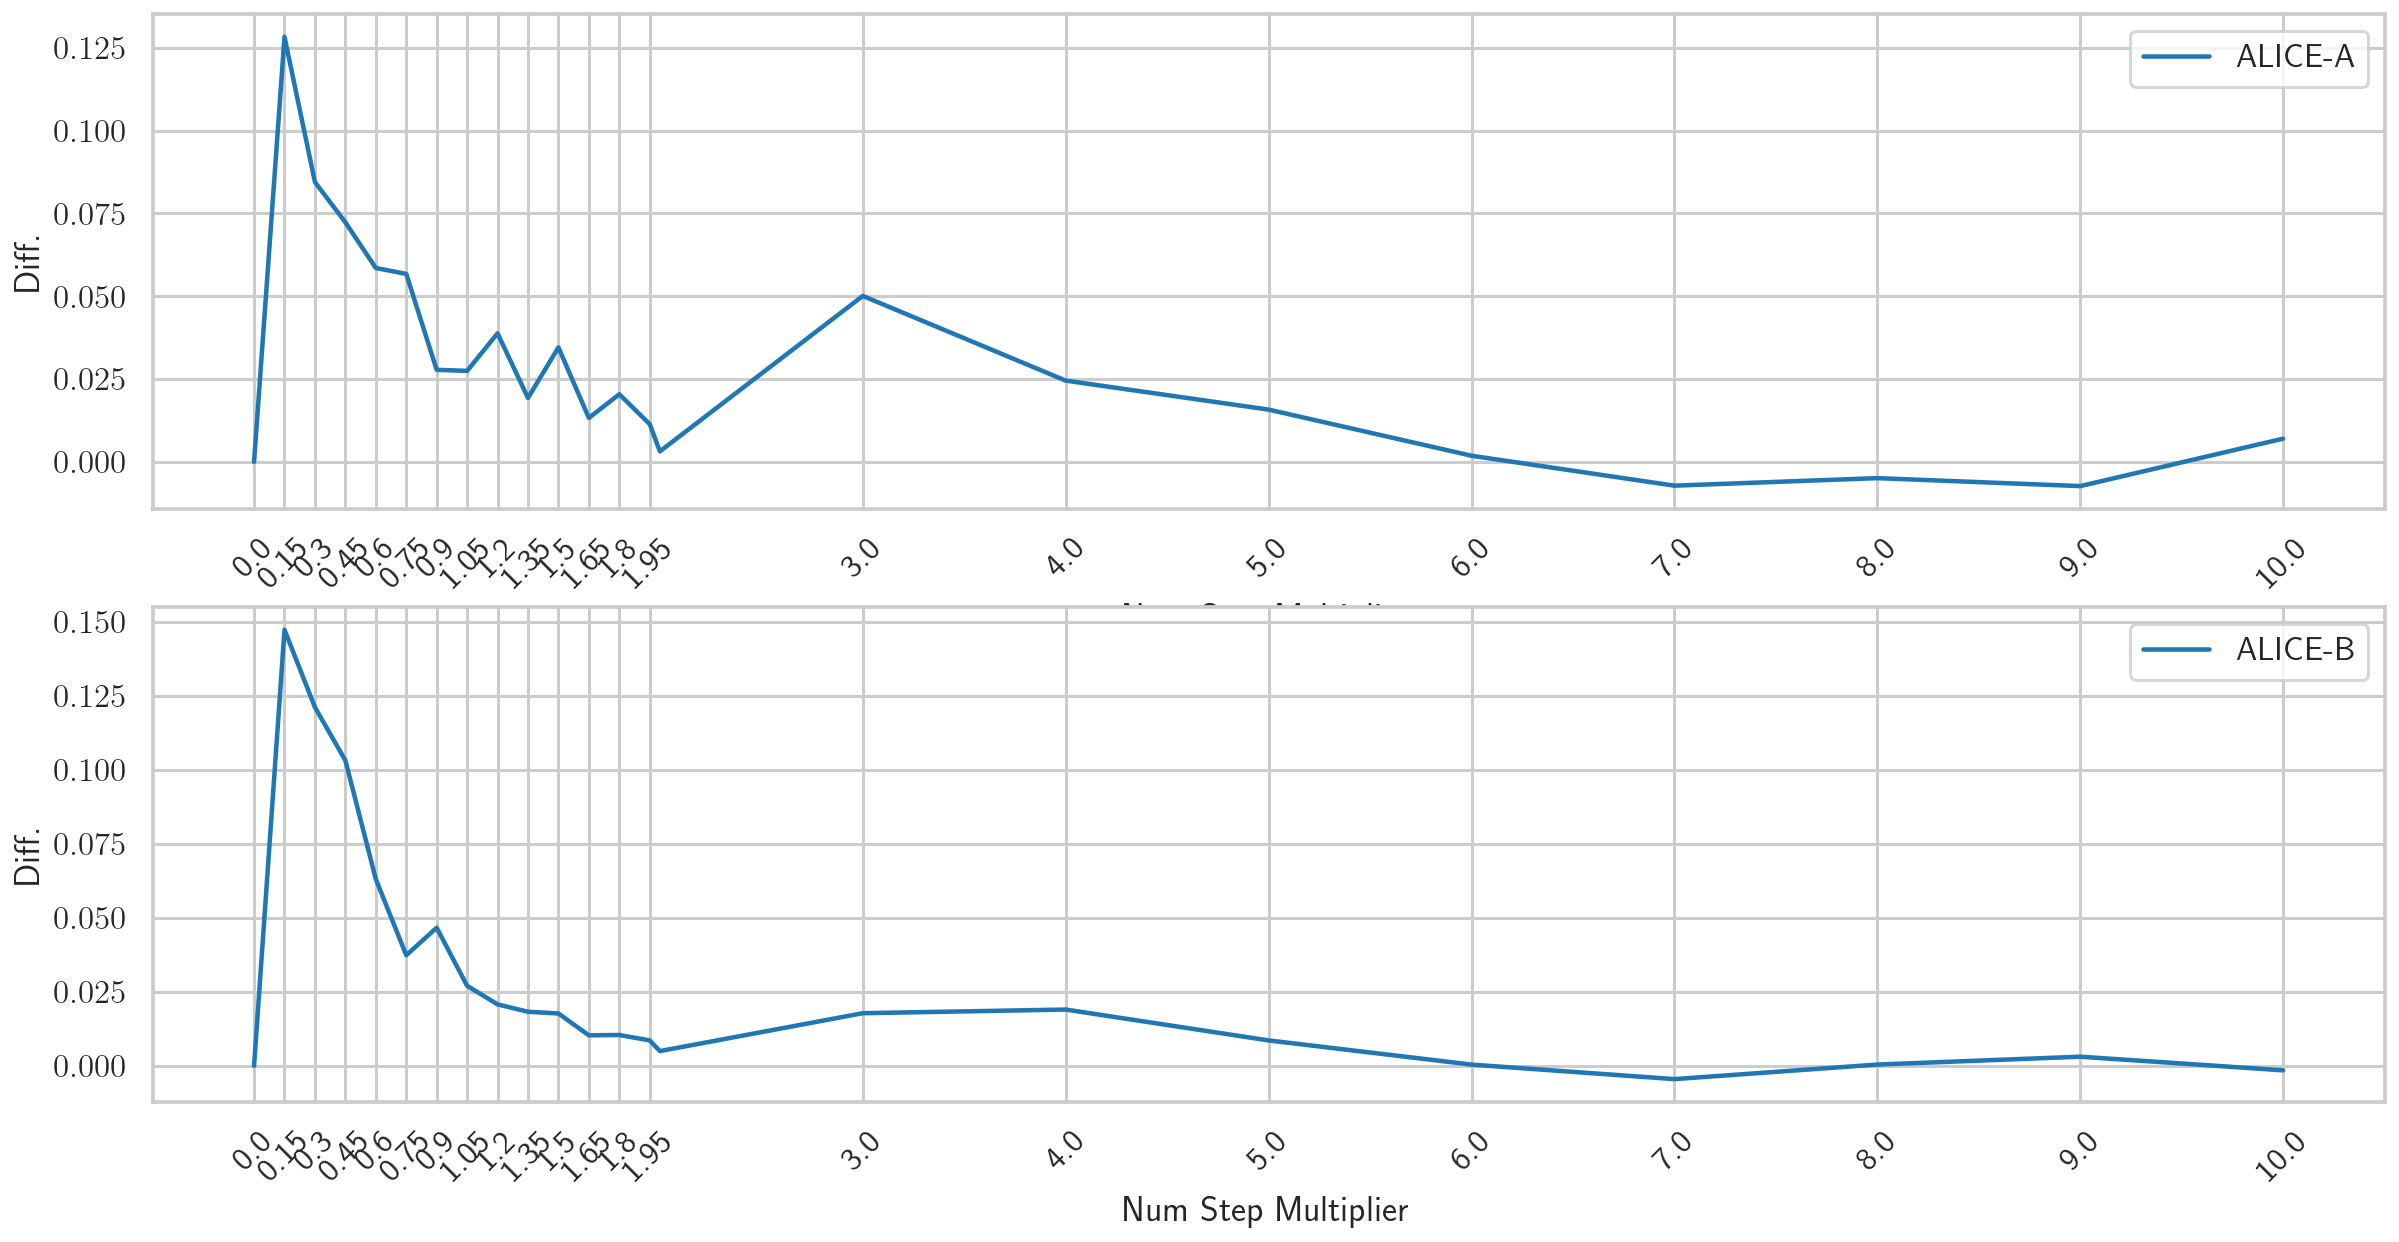

BMS1


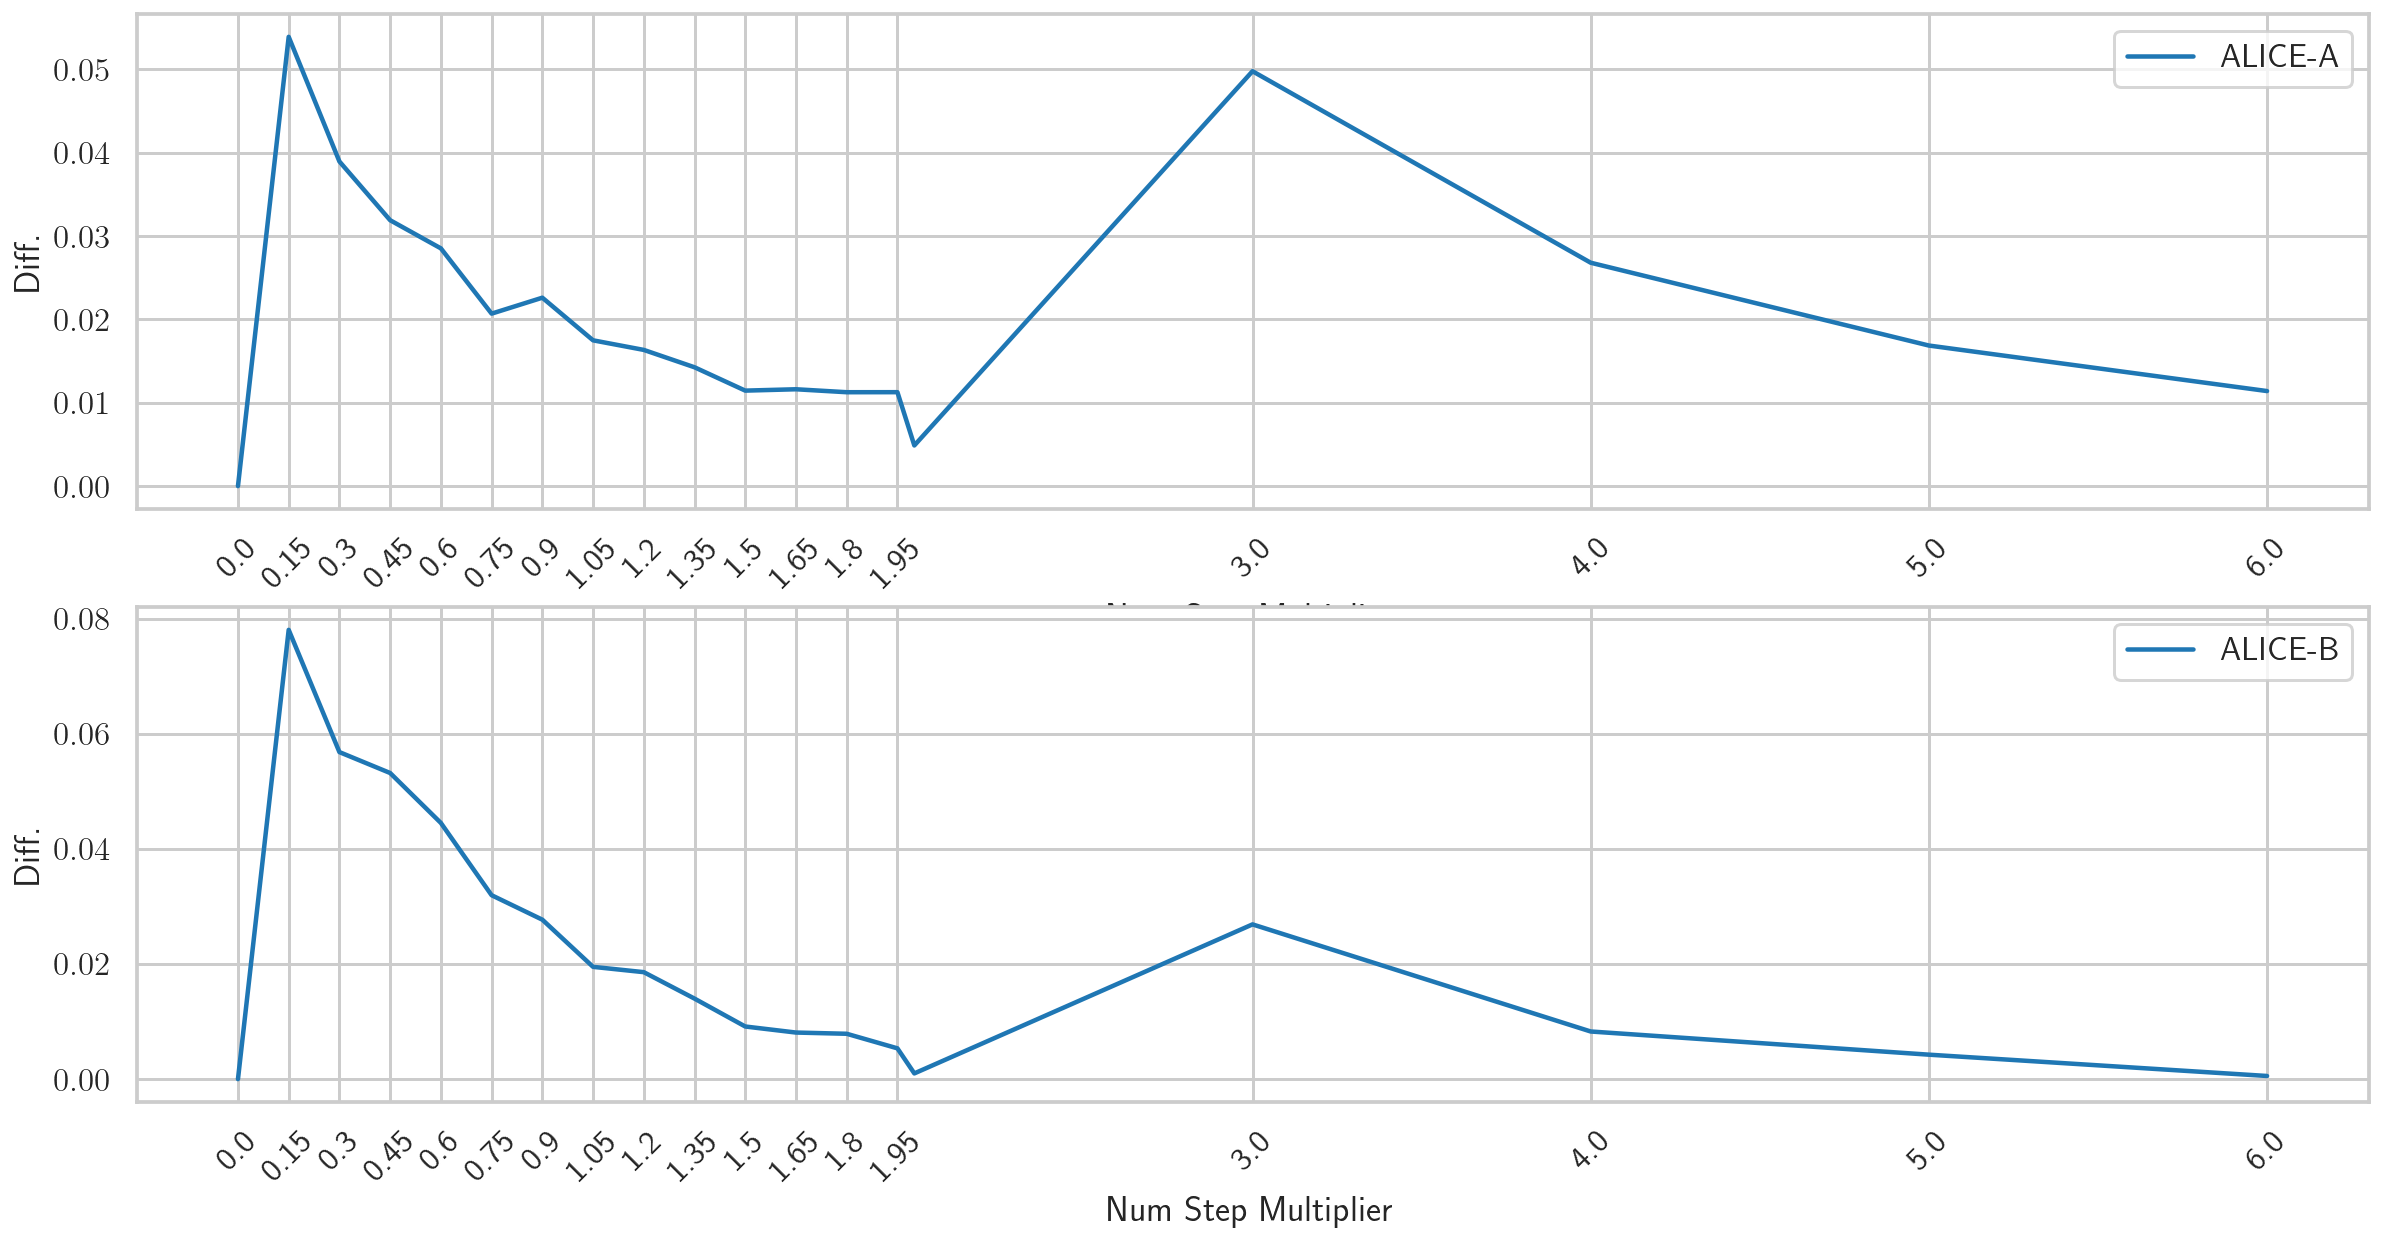

BMS2


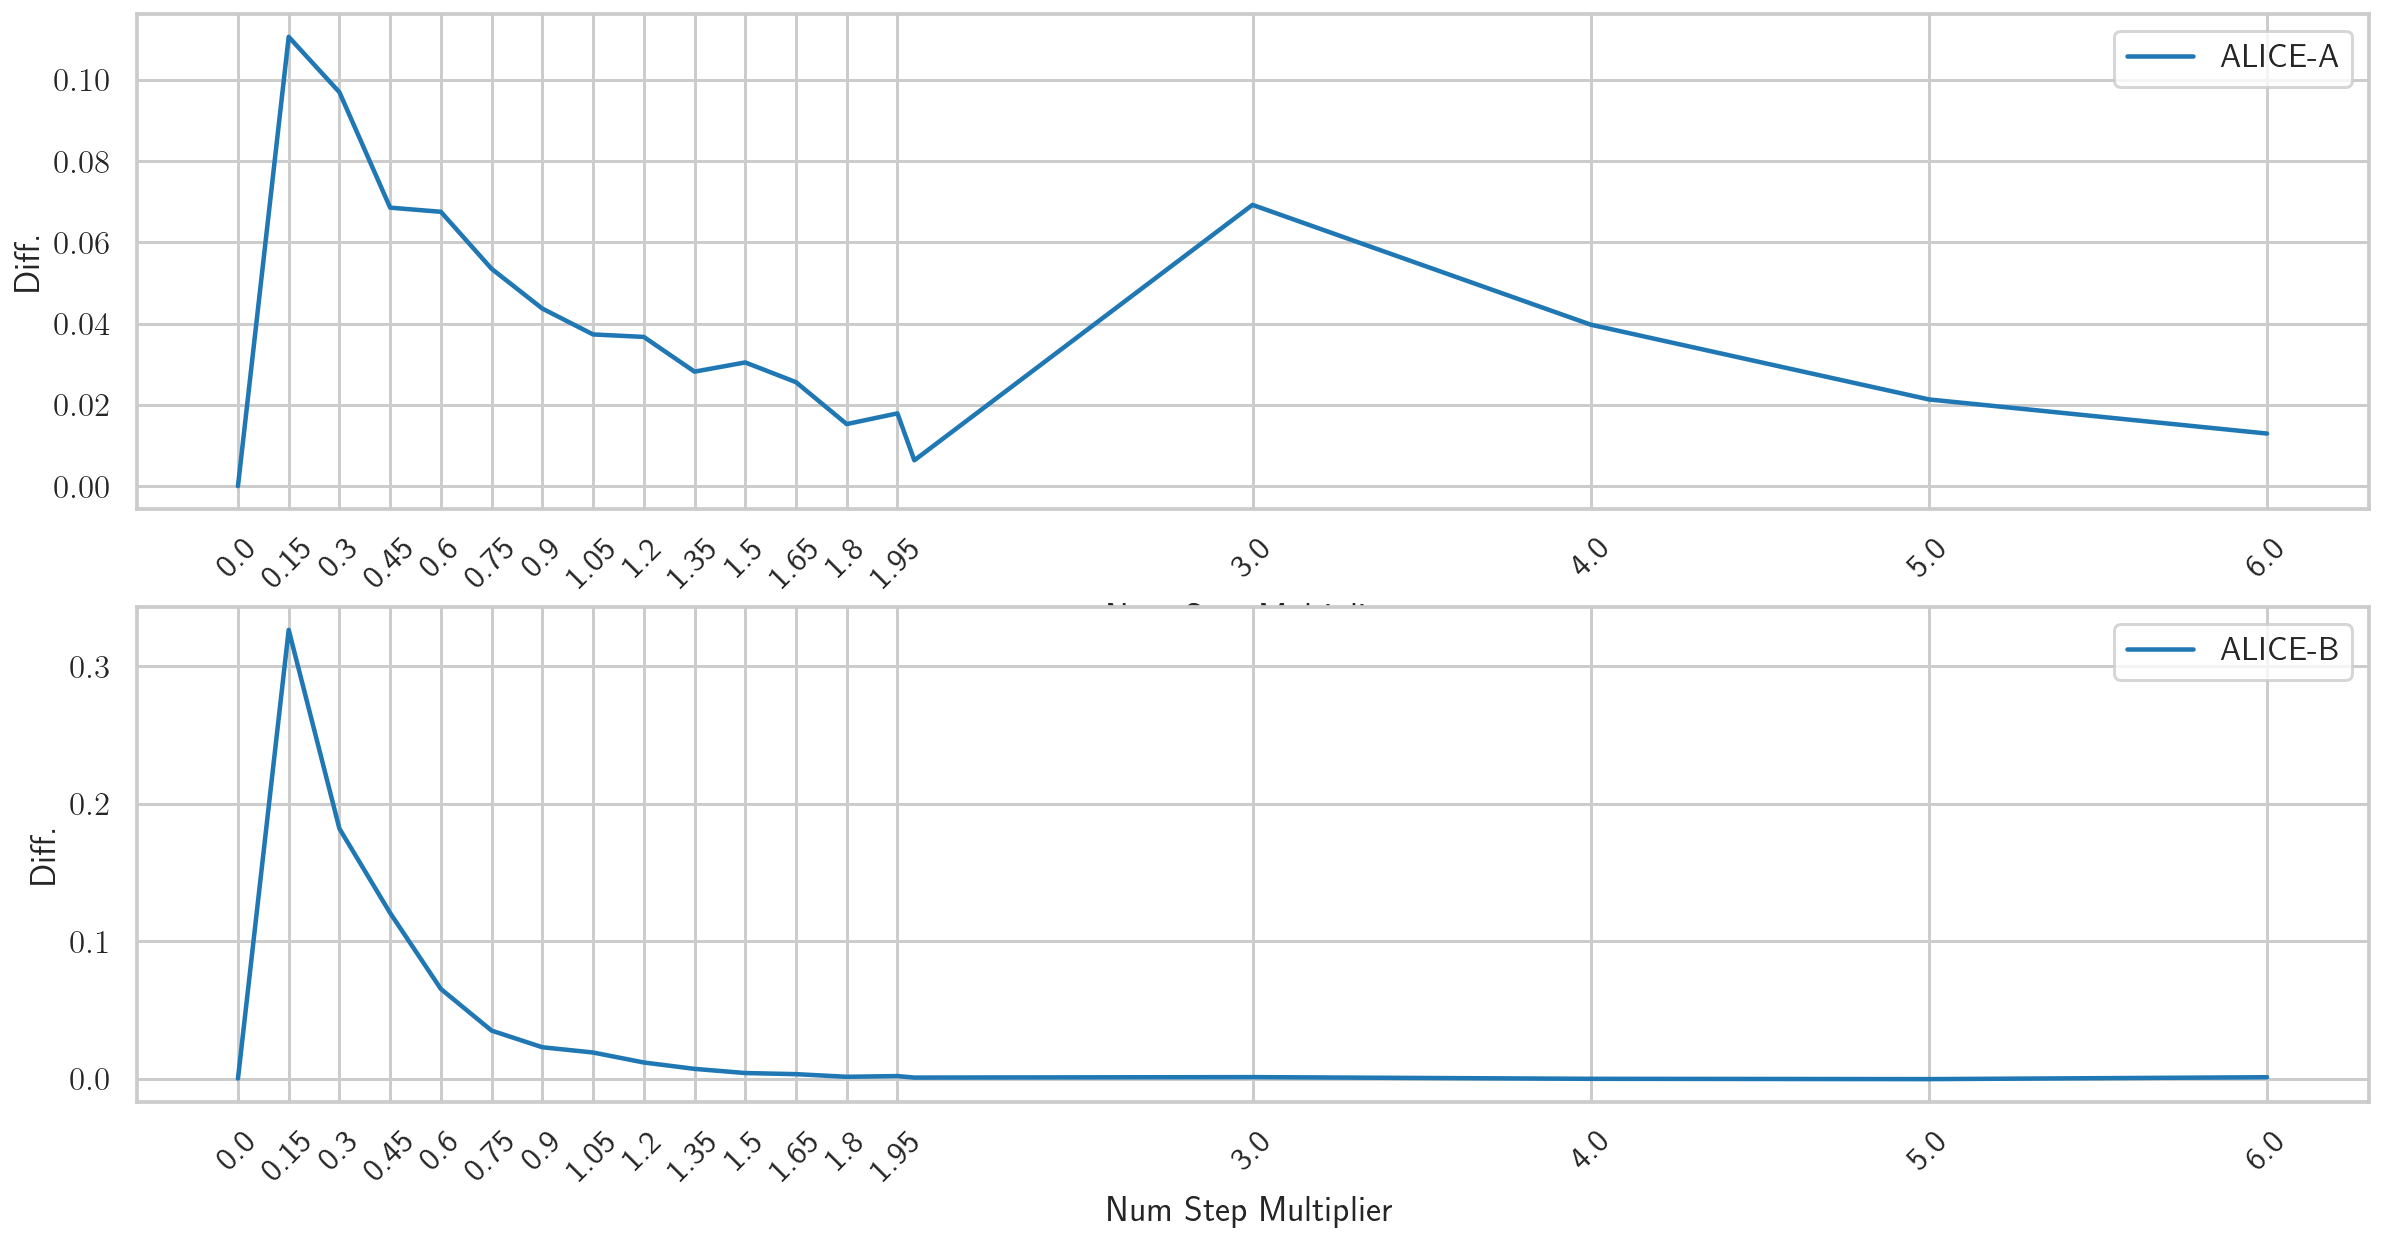

RETAIL


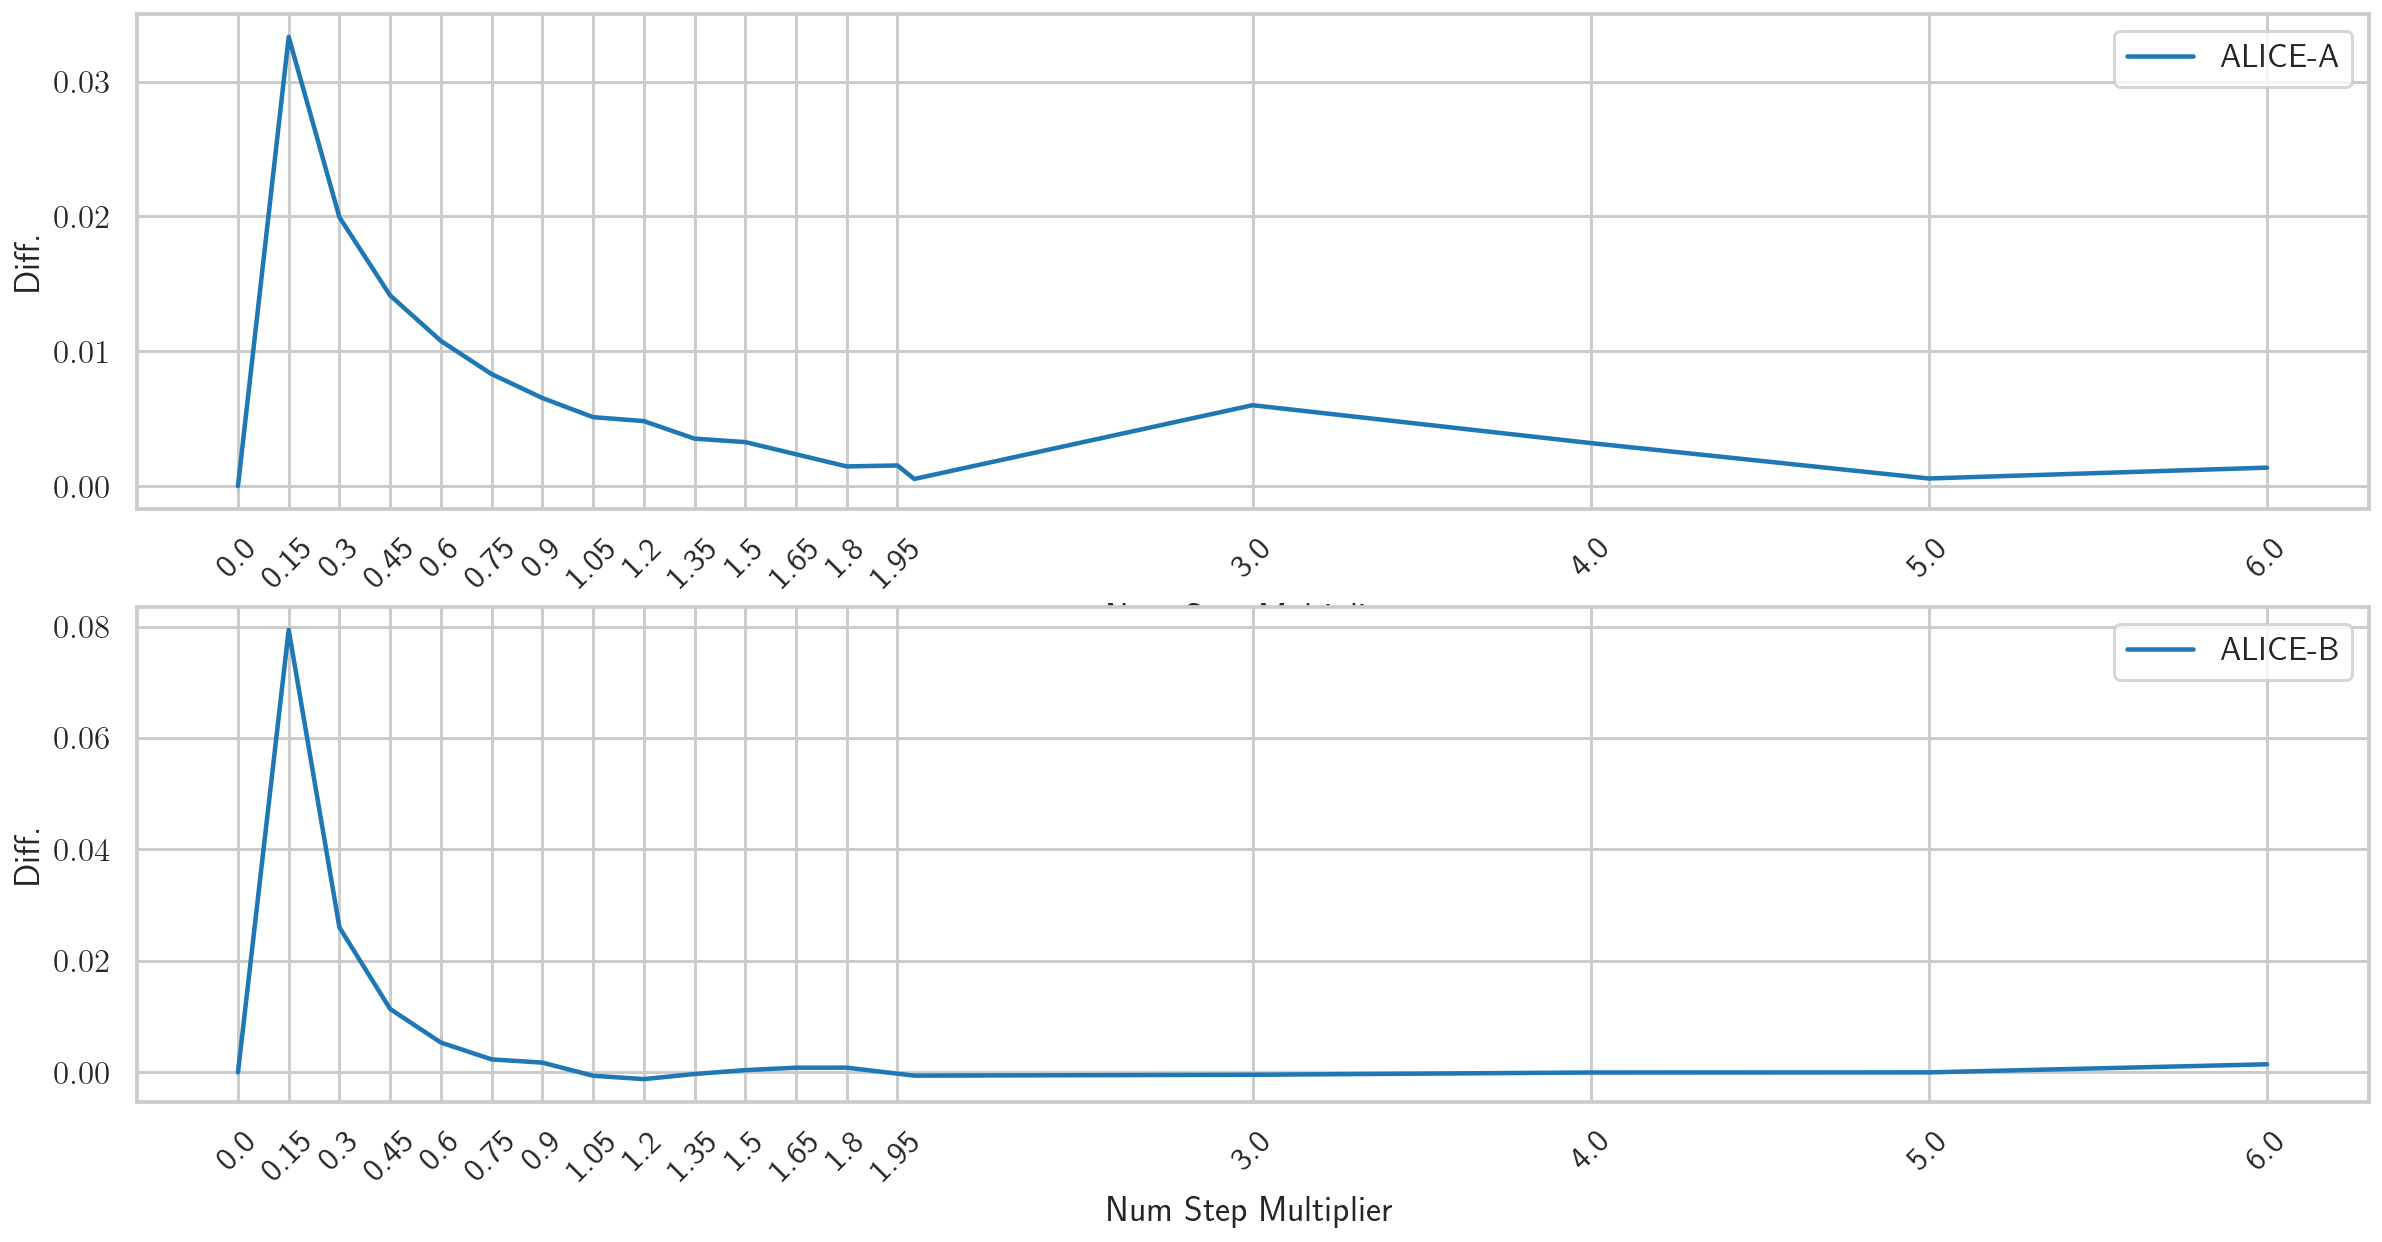

In [35]:
for db in conv_time_df['DataSet'].unique():
    print(db.upper())
    fig, ax = plt.subplots(2, 1, figsize=(20,10))
    conv_diff_df = pd.DataFrame()
    for idx, sampler in enumerate(conv_time_df['Algorithm'].unique()):
        tmp = conv_time_df[(conv_time_df['Algorithm']==sampler) &
                           (conv_time_df['DataSet']==db)].copy()
        maxARSD = tmp.loc[tmp['Num Step Multiplier']==6.0, 'Avg. Rel. Support Diff.'].values[0]
        tmp['Diff.'] = (tmp['Avg. Rel. Support Diff.'] - maxARSD).apply(abs)
        tmp['Diff.'] = (tmp['Diff.'].shift(1) - tmp['Diff.']).fillna(0)
        
        tmp2 = tmp[['Num Step Multiplier', 'Avg. Rel. Support Diff.', 'Diff.']].copy()
        tmp2.rename(columns={'Diff.':sampler,
                             'Avg. Rel. Support Diff.':f'ARSD_{sampler}'}, inplace=True)
        if conv_diff_df.empty:
            conv_diff_df = tmp2
        else:
            conv_diff_df = conv_diff_df.merge(tmp2)
        
        sns.lineplot(data=tmp, x='Num Step Multiplier', y='Diff.', ax=ax[idx], hue='Algorithm')
        ax[idx].legend()
        ticks = list(tmp['Num Step Multiplier'].values)
        ticks.remove(2.0)
        labels = [str(round(x,3)) for x in tmp['Num Step Multiplier'].values]
        labels.remove('2.0')
        ax[idx].set_xticks(ticks)
        ax[idx].set_xticklabels(labels, rotation=45, ha='center')
        ax[idx].grid(which='both', axis='x')
#     display(conv_diff_df.set_index('Num Step Multiplier'))
    plt.show()

In [41]:
## mushrooms
# ALICE = 0.6 (105.191), RSO = 1.2 (2.943)
## foodmart
# ALICE = 0.45 (0.134), RSO = 1.5 (0.069)
## BMS2
# ALICE = 1.8 (15.8), RSO = 6 (10.05)
## retail
# ALICE = 1.05 (30.4), RSO = 5 (22.34)

### Runtimes per Dataset

In [89]:
for db in conv_time_df['DataSet'].unique():
    display(conv_time_df[conv_time_df['DataSet']==db])

Num Step Multiplier Algorithm  Avg. Rel. Support Diff.  Setup  Mean  Min  \
0                  0.00   ALICE-A                 0.000000     25     0    0   
1                  0.15   ALICE-A                 0.717552      7     0    0   
2                  0.30   ALICE-A                 0.866096      4     0    0   
3                  0.45   ALICE-A                 0.870132      1     0    0   
4                  0.60   ALICE-A                 0.932498      2     0    0   
5                  0.75   ALICE-A                 0.975333      2     0    0   
6                  0.90   ALICE-A                 0.975272      1     0    0   
7                  1.05   ALICE-A                 0.986953      2     0    0   
8                  1.20   ALICE-A                 0.992747      1     0    0   
9                  1.35   ALICE-A                 0.994689      1     0    0   
10                 1.50   ALICE-A                 0.992995      2     0    0   
11                 1.65   ALICE-A                 0.994830      1     0    0   
12                 1.80   ALICE-A                 0.994594      2     0    0   
13                 1.95   ALICE-A                 0.994586      2     0    0   
14                 2.00   ALICE-A                 0.992639      1     0    0   
15                 3.00   ALICE-A                 0.996636      1     0    0   
16                 4.00   ALICE-A                 0.997363      2     0    0   
17                 5.00   ALICE-A                 0.994797      1     0    0   
18                 6.00   ALICE-A                 0.991039      2     0    0   
19                 7.00   ALICE-A                 0.996765      2     0    0   
20                 8.00   ALICE-A                 0.997723      1     0    0   
21                 9.00   ALICE-A                 0.997429      2     0    0   
22                10.00   ALICE-A                 0.967729      2     0    0   
23                 0.00   ALICE-B                 0.000000      1     0    0   
24                 0.15   ALICE-B                 0.374701      2     0    0   
25                 0.30   ALICE-B                 0.686580      1     0    0   
26                 0.45   ALICE-B                 0.811396      1     0    0   
27                 0.60   ALICE-B                 0.952042      2     0    0   
28                 0.75   ALICE-B                 0.952042      1     0    0   
29                 0.90   ALICE-B                 0.987091      1     0    0   
30                 1.05   ALICE-B                 0.989132      2     0    0   
31                 1.20   ALICE-B                 0.989120      1     0    0   
32                 1.35   ALICE-B                 0.992874      1     0    0   
33                 1.50   ALICE-B                 0.993562      1     0    0   
34                 1.65   ALICE-B                 0.989671      1     0    0   
35                 1.80   ALICE-B                 0.989679      1     0    0   
36                 1.95   ALICE-B                 0.990136      1     0    0   
37                 2.00   ALICE-B                 0.990158      2     0    0   
38                 3.00   ALICE-B                 0.993969      1     0    0   
39                 4.00   ALICE-B                 0.993964      2     0    0   
40                 5.00   ALICE-B                 0.993973      1     0    0   
41                 6.00   ALICE-B                 0.997797      1     0    0   
42                 7.00   ALICE-B                 0.998357      1     0    0   
43                 8.00   ALICE-B                 0.998535      2     0    0   
44                 9.00   ALICE-B                 0.997722      1     0    0   
45                10.00   ALICE-B                 0.998112      2     0    0   

    Max  Total           DataSet  Sum Transaction Lengths  Time  Time (s)  
0     0     25  edit-iewikibooks                      651    50     0.050  
1     8     27  edit-iewikibooks                      651    34     0.034  
2     1     10 

Num Step Multiplier Algorithm  Avg. Rel. Support Diff.  Setup  Mean  Min  \
46                 0.00   ALICE-A                 0.000000     77     0    0   
47                 0.15   ALICE-A                 0.079916     41     0    0   
48                 0.30   ALICE-A                 0.124255     29     0    0   
49                 0.45   ALICE-A                 0.147054     22     0    0   
50                 0.60   ALICE-A                 0.171657     19     0    0   
51                 0.75   ALICE-A                 0.187264     31     0    0   
52                 0.90   ALICE-A                 0.204298     23     0    0   
53                 1.05   ALICE-A                 0.218777     19     0    0   
54                 1.20   ALICE-A                 0.231707     33     0    0   
55                 1.35   ALICE-A                 0.241410     22     0    0   
56                 1.50   ALICE-A                 0.247175     24     0    0   
57                 1.65   ALICE-A                 0.257064     22     0    0   
58                 1.80   ALICE-A                 0.264372     27     0    0   
59                 1.95   ALICE-A                 0.267013     22     0    0   
60                 2.00   ALICE-A                 0.267433     31     0    0   
61                 3.00   ALICE-A                 0.314220     33     0    0   
62                 4.00   ALICE-A                 0.323147     22     0    0   
63                 5.00   ALICE-A                 0.328572     19     0    0   
64                 6.00   ALICE-A                 0.341091     26     0    0   
65                 0.00   ALICE-B                 0.000000     29     0    0   
66                 0.15   ALICE-B                 0.243641     26     0    0   
67                 0.30   ALICE-B                 0.322906     27     0    0   
68                 0.45   ALICE-B                 0.342755     26     0    0   
69                 0.60   ALICE-B                 0.349753     32     0    0   
70                 0.75   ALICE-B                 0.360515     34     0    0   
71                 0.90   ALICE-B                 0.371711     22     0    0   
72                 1.05   ALICE-B                 0.372850     32     0    0   
73                 1.20   ALICE-B                 0.381040     23     0    0   
74                 1.35   ALICE-B                 0.384778     33     0    0   
75                 1.50   ALICE-B                 0.386742     23     0    0   
76                 1.65   ALICE-B                 0.373675     23     0    0   
77                 1.80   ALICE-B                 0.379405     30     0    0   
78                 1.95   ALICE-B                 0.377634     33     0    0   
79                 2.00   ALICE-B                 0.375341     26     0    0   
80                 3.00   ALICE-B                 0.375303     25     0    0   
81                 4.00   ALICE-B                 0.390577     21     0    0   
82                 5.00   ALICE-B                 0.381684     26     0    0   
83                 6.00   ALICE-B                 0.369622     19     0    0   

    Max  Total       DataSet  Sum Transaction Lengths  Time  Time (s)  
46    0     77  kosarak_3000                    23664   154     0.154  
47    7    192  kosarak_3000                    23664   233     0.233  
48    1    156  kosarak_3000                    23664   185     0.185  
49    1    125  kosarak_3000                    23664   147     0.147  
50    1    124  kosarak_3000                    23664   143     0.143  
51    1    188  kosarak_3000                    23664   219     0.219  
52    1    142  kosarak_3000                    23664   165     0.165  
53    1    122  kosarak_3000                    23664   141     0.141  
54    1    198  kosarak_3000                    23664   231     0.231  
55    1    139  kosarak_3000                    23664   161     0.161  
56    1    146  kosarak_3000                    23664   170     0.170  
57    1    141  kos

Num Step Multiplier Algorithm  Avg. Rel. Support Diff.  Setup  Mean  Min  \
84                  0.00   ALICE-A                 0.000000    467     0    0   
85                  0.15   ALICE-A                 0.009628    380     0    0   
86                  0.30   ALICE-A                 0.013978     65     0    0   
87                  0.45   ALICE-A                 0.014509     63     0    0   
88                  0.60   ALICE-A                 0.014847     61     0    0   
89                  0.75   ALICE-A                 0.015451     62     0    0   
90                  0.90   ALICE-A                 0.016171     62     0    0   
91                  1.05   ALICE-A                 0.015952     61     0    0   
92                  1.20   ALICE-A                 0.015946     60     0    0   
93                  1.35   ALICE-A                 0.016037     61     0    0   
94                  1.50   ALICE-A                 0.015466     60     0    0   
95                  1.65   ALICE-A                 0.015308     62     0    0   
96                  1.80   ALICE-A                 0.014624     62     0    0   
97                  1.95   ALICE-A                 0.015472     61     0    0   
98                  2.00   ALICE-A                 0.015577     61     0    0   
99                  3.00   ALICE-A                 0.015250     61     0    0   
100                 4.00   ALICE-A                 0.016149     65     0    0   
101                 5.00   ALICE-A                 0.015488     62     0    0   
102                 6.00   ALICE-A                 0.016031     66     0    0   
103                 0.00   ALICE-B                 0.000000    373     0    0   
104                 0.15   ALICE-B                 0.015500    369     1    0   
105                 0.30   ALICE-B                 0.014835     62     2    0   
106                 0.45   ALICE-B                 0.015837     62     2    0   
107                 0.60   ALICE-B                 0.014653     61     2    0   
108                 0.75   ALICE-B                 0.015622     61     2    0   
109                 0.90   ALICE-B                 0.015626     61     2    0   
110                 1.05   ALICE-B                 0.015495     61     2    0   
111                 1.20   ALICE-B                 0.015871     61     1    0   
112                 1.35   ALICE-B                 0.014948     61     1    0   
113                 1.50   ALICE-B                 0.015518     61     2    0   
114                 1.65   ALICE-B                 0.015824     61     2    0   
115                 1.80   ALICE-B                 0.015489     61     2    0   
116                 1.95   ALICE-B                 0.015486     60     2    0   
117                 2.00   ALICE-B                 0.015957     61     1    0   
118                 3.00   ALICE-B                 0.015182     61     2    0   
119                 4.00   ALICE-B                 0.015868     60     2    0   
120                 5.00   ALICE-B                 0.014710     59     1    0   
121                 6.00   ALICE-B                 0.015818     60     1    0   

     Max   Total DataSet  Sum Transaction Lengths    Time  Time (s)  
84     0     467   chess                   118252     934     0.934  
85     6    3864   chess                   118252    4244     4.244  
86     1    3080   chess                   118252    3145     3.145  
87    28    2469   chess                   118252    2532     2.532  
88   134    3103   chess                   118252    3164     3.164  
89    97    3146   chess                   118252    3208     3.208  
90     1    3093   chess                   118252    3155     3.155  
91    23    2714   chess                   118252    2775     2.775  
92     1    3027   chess                   118252    3087     3.087  
93     1    2999   chess                   118252    3060     3.060  
94    22    2526   chess                   118252    2586     2.586  
95   

Num Step Multiplier Algorithm  Avg. Rel. Support Diff.  Setup  Mean  Min  \
122                 0.00   ALICE-A                 0.000000     65     0    0   
123                 0.15   ALICE-A                 0.001569     25     0    0   
124                 0.30   ALICE-A                 0.006276     21     0    0   
125                 0.45   ALICE-A                 0.007845     15     0    0   
126                 0.60   ALICE-A                 0.009937     14     0    0   
127                 0.75   ALICE-A                 0.009937     11     0    0   
128                 0.90   ALICE-A                 0.010460     15     0    0   
129                 1.05   ALICE-A                 0.010460     10     0    0   
130                 1.20   ALICE-A                 0.010460      9     0    0   
131                 1.35   ALICE-A                 0.010460      8     0    0   
132                 1.50   ALICE-A                 0.010460      9     0    0   
133                 1.65   ALICE-A                 0.010983     11     0    0   
134                 1.80   ALICE-A                 0.010983     13     0    0   
135                 1.95   ALICE-A                 0.010983      7     0    0   
136                 2.00   ALICE-A                 0.010983      8     0    0   
137                 3.00   ALICE-A                 0.011506     12     0    0   
138                 4.00   ALICE-A                 0.011506     11     0    0   
139                 5.00   ALICE-A                 0.011506     10     0    0   
140                 6.00   ALICE-A                 0.011506      9     0    0   
141                 0.00   ALICE-B                 0.000000      7     0    0   
142                 0.15   ALICE-B                 0.007322      7     0    0   
143                 0.30   ALICE-B                 0.007845     15     0    0   
144                 0.45   ALICE-B                 0.007845     10     0    0   
145                 0.60   ALICE-B                 0.008891     12     0    0   
146                 0.75   ALICE-B                 0.009937     11     0    0   
147                 0.90   ALICE-B                 0.011506     11     0    0   
148                 1.05   ALICE-B                 0.010983     13     0    0   
149                 1.20   ALICE-B                 0.011506     17     0    0   
150                 1.35   ALICE-B                 0.011506     11     0    0   
151                 1.50   ALICE-B                 0.011506     16     0    0   
152                 1.65   ALICE-B                 0.011506      9     0    0   
153                 1.80   ALICE-B                 0.011506     13     0    0   
154                 1.95   ALICE-B                 0.011506     14     0    0   
155                 2.00   ALICE-B                 0.011506     15     0    0   
156                 3.00   ALICE-B                 0.011506     14     0    0   
157                 4.00   ALICE-B                 0.011506      7     0    0   
158                 5.00   ALICE-B                 0.011506     17     0    0   
159                 6.00   ALICE-B                 0.011506     11     0    0   

     Max  Total           DataSet  Sum Transaction Lengths  Time  Time (s)  
122    0     65  wang-tripadvisor                     4840   130     0.130  
123   16     86  wang-tripadvisor                     4840   111     0.111  
124    1     33  wang-tripadvisor                     4840    54     0.054  
125    1     23  wang-tripadvisor                     4840    38     0.038  
126    1     23  wang-tripadvisor                     4840    37     0.037  
127    1     19  wang-tripadvisor                     4840    30     0.030  
128    1     22  wang-tripadvisor                     4840    37     0.037  
129    1     15  wang-tripadvisor                     4840    25     0.025  
130    1     16  wang-tripadvisor                     4840    25     0.025  
131    1     14  wang-tripadvisor                     4840    22     0.022 

Num Step Multiplier Algorithm  Avg. Rel. Support Diff.  Setup  Mean  Min  \
160                 0.00   ALICE-A                 0.000000     54     0    0   
161                 0.15   ALICE-A                 0.256063     33     0    0   
162                 0.30   ALICE-A                 0.407444     19     0    0   
163                 0.45   ALICE-A                 0.495860     21     0    0   
164                 0.60   ALICE-A                 0.540381     17     0    0   
165                 0.75   ALICE-A                 0.570246     17     0    0   
166                 0.90   ALICE-A                 0.588298     16     0    0   
167                 1.05   ALICE-A                 0.600502     16     0    0   
168                 1.20   ALICE-A                 0.608547     16     0    0   
169                 1.35   ALICE-A                 0.614041     17     0    0   
170                 1.50   ALICE-A                 0.615493     19     0    0   
171                 1.65   ALICE-A                 0.618947     17     0    0   
172                 1.80   ALICE-A                 0.621380     17     0    0   
173                 1.95   ALICE-A                 0.622910     19     0    0   
174                 2.00   ALICE-A                 0.622832     17     0    0   
175                 3.00   ALICE-A                 0.621655     16     0    0   
176                 4.00   ALICE-A                 0.623499     16     0    0   
177                 5.00   ALICE-A                 0.622165     16     0    0   
178                 6.00   ALICE-A                 0.622832     17     0    0   
179                 0.00   ALICE-B                 0.000000     17     0    0   
180                 0.15   ALICE-B                 0.559140     16     0    0   
181                 0.30   ALICE-B                 0.613884     17     0    0   
182                 0.45   ALICE-B                 0.621576     16     0    0   
183                 0.60   ALICE-B                 0.621635     16     0    0   
184                 0.75   ALICE-B                 0.621184     16     0    0   
185                 0.90   ALICE-B                 0.619575     20     0    0   
186                 1.05   ALICE-B                 0.621968     16     0    0   
187                 1.20   ALICE-B                 0.621478     15     0    0   
188                 1.35   ALICE-B                 0.625265     16     0    0   
189                 1.50   ALICE-B                 0.622322     15     0    0   
190                 1.65   ALICE-B                 0.622753     16     0    0   
191                 1.80   ALICE-B                 0.622910     16     0    0   
192                 1.95   ALICE-B                 0.624951     16     0    0   
193                 2.00   ALICE-B                 0.625265     16     0    0   
194                 3.00   ALICE-B                 0.621105     16     0    0   
195                 4.00   ALICE-B                 0.624205     17     0    0   
196                 5.00   ALICE-B                 0.622361     16     0    0   
197                 6.00   ALICE-B                 0.623577     16     0    0   

     Max  Total   DataSet  Sum Transaction Lengths  Time  Time (s)  
160    0     54  foodmart                    18319   108     0.108  
161    5     93  foodmart                    18319   126     0.126  
162    1     50  foodmart                    18319    69     0.069  
163    1     50  foodmart                    18319    71     0.071  
164    1     44  foodmart                    18319    61     0.061  
165    1     43  foodmart                    18319    60     0.060  
166    1     42  foodmart                    18319    58     0.058  
167    1     42  foodmart                    18319    58     0.058  
168    1     43  foodmart                    18319    59     0.059  
169    1     44  foodmart                    18319    61     0.061  
170    1     50  foodmart                    18319    69     0.069  
171    1     44  

Num Step Multiplier Algorithm  Avg. Rel. Support Diff.  Setup  Mean  Min  \
198                 0.00   ALICE-A                 0.000000     80     0    0   
199                 0.15   ALICE-A                 0.128277     38     0    0   
200                 0.30   ALICE-A                 0.212709     30     0    0   
201                 0.45   ALICE-A                 0.284999     30     0    0   
202                 0.60   ALICE-A                 0.343506     33     0    0   
203                 0.75   ALICE-A                 0.400220     32     0    0   
204                 0.90   ALICE-A                 0.427986     32     0    0   
205                 1.05   ALICE-A                 0.455431     28     0    0   
206                 1.20   ALICE-A                 0.494208     26     0    0   
207                 1.35   ALICE-A                 0.513479     32     0    0   
208                 1.50   ALICE-A                 0.548015     31     0    0   
209                 1.65   ALICE-A                 0.561257     32     0    0   
210                 1.80   ALICE-A                 0.581644     30     0    0   
211                 1.95   ALICE-A                 0.593009     31     0    0   
212                 2.00   ALICE-A                 0.596160     31     0    0   
213                 3.00   ALICE-A                 0.646231     30     0    0   
214                 4.00   ALICE-A                 0.670738     30     0    0   
215                 5.00   ALICE-A                 0.686496     30     0    0   
216                 6.00   ALICE-A                 0.688329     30     0    0   
217                 7.00   ALICE-A                 0.681125     29     0    0   
218                 8.00   ALICE-A                 0.676198     29     0    0   
219                 9.00   ALICE-A                 0.668863     30     0    0   
220                10.00   ALICE-A                 0.675858     30     0    0   
221                 0.00   ALICE-B                 0.000000     31     0    0   
222                 0.15   ALICE-B                 0.147265     29     0    0   
223                 0.30   ALICE-B                 0.268391     31     0    0   
224                 0.45   ALICE-B                 0.371534     30     0    0   
225                 0.60   ALICE-B                 0.434604     30     0    0   
226                 0.75   ALICE-B                 0.471959     30     0    0   
227                 0.90   ALICE-B                 0.518599     31     0    0   
228                 1.05   ALICE-B                 0.545623     31     0    0   
229                 1.20   ALICE-B                 0.566372     31     0    0   
230                 1.35   ALICE-B                 0.584625     30     0    0   
231                 1.50   ALICE-B                 0.602301     31     0    0   
232                 1.65   ALICE-B                 0.612591     34     0    0   
233                 1.80   ALICE-B                 0.622998     31     0    0   
234                 1.95   ALICE-B                 0.631568     31     0    0   
235                 2.00   ALICE-B                 0.636539     31     0    0   
236                 3.00   ALICE-B                 0.654305     30     0    0   
237                 4.00   ALICE-B                 0.673305     30     0    0   
238                 5.00   ALICE-B                 0.682684     30     0    0   
239                 6.00   ALICE-B                 0.682280     30     0    0   
240                 7.00   ALICE-B                 0.677777     30     0    0   
241                 8.00   ALICE-B                 0.686364     31     0    0   
242                 9.00   ALICE-B                 0.683289     29     0    0   
243                10.00   ALICE-B                 0.684823     30     0    0   

     Max  Total             DataSet  Sum Transaction Lengths  Time  Time (s)  
198    0     80  dbpedia-occupation                    19729   160     0.160  
199    4     80  dbpedia-occupation    

Num Step Multiplier Algorithm  Avg. Rel. Support Diff.  Setup  Mean  Min  \
244                 0.00   ALICE-A                 0.000000    340     0    0   
245                 0.15   ALICE-A                 0.053912    268     0    0   
246                 0.30   ALICE-A                 0.092866    240     0    0   
247                 0.45   ALICE-A                 0.124772    265     0    0   
248                 0.60   ALICE-A                 0.153301    261     0    0   
249                 0.75   ALICE-A                 0.173996    269     0    0   
250                 0.90   ALICE-A                 0.196605    259     0    0   
251                 1.05   ALICE-A                 0.214099    281     0    0   
252                 1.20   ALICE-A                 0.230442    272     0    0   
253                 1.35   ALICE-A                 0.244702    281     0    0   
254                 1.50   ALICE-A                 0.256160    289     0    0   
255                 1.65   ALICE-A                 0.267781    278     0    0   
256                 1.80   ALICE-A                 0.279047    280     0    0   
257                 1.95   ALICE-A                 0.290319    287     0    0   
258                 2.00   ALICE-A                 0.295197    282     0    0   
259                 3.00   ALICE-A                 0.344983    283     0    0   
260                 4.00   ALICE-A                 0.371789    293     0    0   
261                 5.00   ALICE-A                 0.388657    272     0    0   
262                 6.00   ALICE-A                 0.400062    270     0    0   
263                 0.00   ALICE-B                 0.000000    263     0    0   
264                 0.15   ALICE-B                 0.078034    259     0    0   
265                 0.30   ALICE-B                 0.134837    271     0    0   
266                 0.45   ALICE-B                 0.188007    266     0    0   
267                 0.60   ALICE-B                 0.232504    266     0    0   
268                 0.75   ALICE-B                 0.264448    276     0    0   
269                 0.90   ALICE-B                 0.292144    245     0    0   
270                 1.05   ALICE-B                 0.311646    264     0    0   
271                 1.20   ALICE-B                 0.330225    278     0    0   
272                 1.35   ALICE-B                 0.344210    272     0    0   
273                 1.50   ALICE-B                 0.353350    274     0    0   
274                 1.65   ALICE-B                 0.361440    285     0    0   
275                 1.80   ALICE-B                 0.369317    280     0    0   
276                 1.95   ALICE-B                 0.374664    252     0    0   
277                 2.00   ALICE-B                 0.375657    279     0    0   
278                 3.00   ALICE-B                 0.402534    279     0    0   
279                 4.00   ALICE-B                 0.410807    291     0    0   
280                 5.00   ALICE-B                 0.415055    296     0    0   
281                 6.00   ALICE-B                 0.415600    305     0    0   

     Max  Total DataSet  Sum Transaction Lengths   Time  Time (s)  
244    0    340    BMS1                   149639    680     0.680  
245    5   1004    BMS1                   149639   1272     1.272  
246    1    866    BMS1                   149639   1106     1.106  
247    1    942    BMS1                   149639   1207     1.207  
248    1    893    BMS1                   149639   1154     1.154  
249    1    950    BMS1                   149639   1219     1.219  
250    1    905    BMS1                   149639   1164     1.164  
251    1    968    BMS1                   149639   1249     1.249  
252    1    950    BMS1                   149639   1222     1.222  
253    1    989    BMS1                   149639   1270     1.270  
254    1    983    BMS1                   149639   1272     1.272  
255    1    983    BMS1      

Num Step Multiplier Algorithm  Avg. Rel. Support Diff.  Setup  Mean  Min  \
282                 0.00   ALICE-A                 0.000000    624     0    0   
283                 0.15   ALICE-A                 0.110616    438     0    0   
284                 0.30   ALICE-A                 0.207596    442     0    0   
285                 0.45   ALICE-A                 0.276155    444     0    0   
286                 0.60   ALICE-A                 0.343695    452     0    0   
287                 0.75   ALICE-A                 0.397200    446     0    0   
288                 0.90   ALICE-A                 0.440910    510     0    0   
289                 1.05   ALICE-A                 0.478253    456     0    0   
290                 1.20   ALICE-A                 0.514986    458     0    0   
291                 1.35   ALICE-A                 0.543170    447     0    0   
292                 1.50   ALICE-A                 0.573619    462     0    0   
293                 1.65   ALICE-A                 0.599215    452     0    0   
294                 1.80   ALICE-A                 0.614489    448     0    0   
295                 1.95   ALICE-A                 0.632392    458     0    0   
296                 2.00   ALICE-A                 0.638743    449     0    0   
297                 3.00   ALICE-A                 0.707987    450     0    0   
298                 4.00   ALICE-A                 0.747737    462     0    0   
299                 5.00   ALICE-A                 0.769077    465     0    0   
300                 6.00   ALICE-A                 0.782016    462     0    0   
301                 0.00   ALICE-B                 0.000000    438     0    0   
302                 0.15   ALICE-B                 0.326625    433     0    0   
303                 0.30   ALICE-B                 0.508575    464     0    0   
304                 0.45   ALICE-B                 0.629078    468     0    0   
305                 0.60   ALICE-B                 0.694298    468     0    0   
306                 0.75   ALICE-B                 0.729191    474     0    0   
307                 0.90   ALICE-B                 0.751976    468     0    0   
308                 1.05   ALICE-B                 0.770936    462     0    0   
309                 1.20   ALICE-B                 0.782638    467     0    0   
310                 1.35   ALICE-B                 0.789688    473     0    0   
311                 1.50   ALICE-B                 0.793705    468     0    0   
312                 1.65   ALICE-B                 0.796916    474     0    0   
313                 1.80   ALICE-B                 0.798196    474     0    0   
314                 1.95   ALICE-B                 0.799998    479     0    0   
315                 2.00   ALICE-B                 0.800708    476     0    0   
316                 3.00   ALICE-B                 0.802458    456     0    0   
317                 4.00   ALICE-B                 0.802648    476     0    0   
318                 5.00   ALICE-B                 0.803062    489     0    0   
319                 6.00   ALICE-B                 0.802106    487     0    0   

     Max   Total DataSet  Sum Transaction Lengths    Time  Time (s)  
282    0     624    BMS2                   358278    1248     1.248  
283    4    1811    BMS2                   358278    2249     2.249  
284    1    1761    BMS2                   358278    2203     2.203  
285    1    1769    BMS2                   358278    2213     2.213  
286    1    1772    BMS2                   358278    2224     2.224  
287    1    1793    BMS2                   358278    2239     2.239  
288    1    1773    BMS2                   358278    2283     2.283  
289   70    1806    BMS2                   358278    2262     2.262  
290    1    1804    BMS2                   358278    2262     2.262  
291    1    1789    BMS2                   358278    2236     2.236  
292    1    1814    BMS2                   358278    2276     2.276  
293  

Num Step Multiplier Algorithm  Avg. Rel. Support Diff.  Setup  Mean  Min  \
320                 0.00   ALICE-A                 0.000000   1320     0    0   
321                 0.15   ALICE-A                 0.033317   1009     0    0   
322                 0.30   ALICE-A                 0.053252    952     0    0   
323                 0.45   ALICE-A                 0.067392    903     0    0   
324                 0.60   ALICE-A                 0.078159    885     0    0   
325                 0.75   ALICE-A                 0.086467    886     0    0   
326                 0.90   ALICE-A                 0.093001    900     0    0   
327                 1.05   ALICE-A                 0.098115   1082     0    0   
328                 1.20   ALICE-A                 0.102936   1032     0    0   
329                 1.35   ALICE-A                 0.106456    882     0    0   
330                 1.50   ALICE-A                 0.109720    897     0    0   
331                 1.65   ALICE-A                 0.112083    894     0    0   
332                 1.80   ALICE-A                 0.113543    893     0    0   
333                 1.95   ALICE-A                 0.115073    906     0    0   
334                 2.00   ALICE-A                 0.115603   1065     0    0   
335                 3.00   ALICE-A                 0.121604   1059     0    0   
336                 4.00   ALICE-A                 0.124795    944     0    0   
337                 5.00   ALICE-A                 0.125360    965     0    0   
338                 6.00   ALICE-A                 0.126729    954     0    0   
339                 0.00   ALICE-B                 0.000000    890     0    0   
340                 0.15   ALICE-B                 0.079417    890     0    0   
341                 0.30   ALICE-B                 0.105427    951     0    0   
342                 0.45   ALICE-B                 0.116804    988     0    0   
343                 0.60   ALICE-B                 0.122149   1002     0    0   
344                 0.75   ALICE-B                 0.124476   1038     0    0   
345                 0.90   ALICE-B                 0.126401   1161     0    0   
346                 1.05   ALICE-B                 0.127008   1016     0    0   
347                 1.20   ALICE-B                 0.128225   1008     0    0   
348                 1.35   ALICE-B                 0.128526    997     0    0   
349                 1.50   ALICE-B                 0.128131    992     0    0   
350                 1.65   ALICE-B                 0.127294   1007     0    0   
351                 1.80   ALICE-B                 0.126452   1063     0    0   
352                 1.95   ALICE-B                 0.126693   1158     0    0   
353                 2.00   ALICE-B                 0.127283   1097     0    0   
354                 3.00   ALICE-B                 0.127716    953     0    0   
355                 4.00   ALICE-B                 0.127746    965     0    0   
356                 5.00   ALICE-B                 0.127756   1002     0    0   
357                 6.00   ALICE-B                 0.126311    984     0    0   

     Max   Total DataSet  Sum Transaction Lengths    Time  Time (s)  
320    0    1320  retail                   908576    2640     2.640  
321    4    4144  retail                   908576    5153     5.153  
322    1    3913  retail                   908576    4865     4.865  
323    1    3838  retail                   908576    4741     4.741  
324    1    3820  retail                   908576    4705     4.705  
325    1    3848  retail                   908576    4734     4.734  
326  223    4113  retail                   908576    5013     5.013  
327    1    4079  retail                   908576    5161     5.161  
328    1    4379  retail                   908576    5411     5.411  
329    1    3815  retail                   908576    4697     4.697  
330    1    3835  retail                   908576    4732     4.732  
331  

## Scalability

In [9]:
result_dir = '../output/scalability/'
# config
dbs = ['synthetic-5', 'synthetic-10', 
       'synthetic-15', 'synthetic-20']
real_dbs = ['edit-iewikibooks', 'kosarak_3000', 'chess', 
            'wang-tripadvisor', 'foodmart', 
            'dbpedia-occupation', 'BMS1', 'BMS2', 'retail']

In [12]:
dfs = []
for db in dbs:
    file_name = f'{db}-25-0.1-10000-0.json'
    file = result_dir + file_name
    tmp_df = ss.get_scalability_df(file, file_name)
    tmp_df['DataSet'] = db
    dfs.append(tmp_df)
for db in real_dbs:
    file_name = f'{db}-10000-0.json'
    file = result_dir + file_name
    tmp_df = ss.get_scalability_df(file, file_name)
    tmp_df['DataSet'] = db
    dfs.append(tmp_df)
    
results_df = pd.concat(dfs)

In [13]:
results_df['Algorithm'] = results_df['Algorithm'].apply(lambda x: sampler_names[x])

### Synthetic Datasets

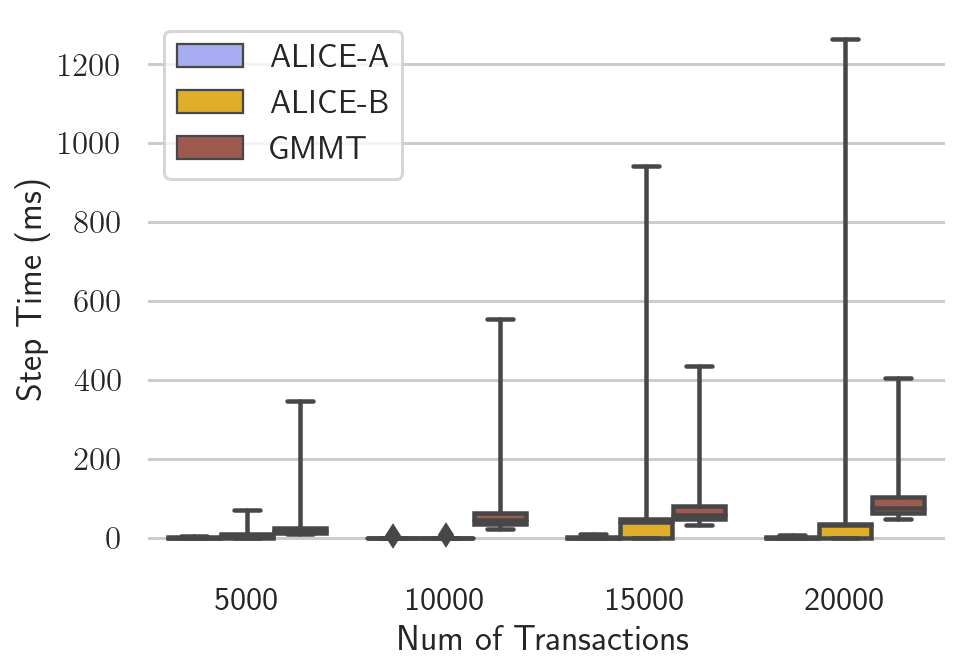

In [17]:
fig, ax = plt.subplots(figsize=(7,5))

data = results_df[results_df['DataSet'].isin(dbs)]
sns.set_theme(style='whitegrid', context='talk')
sns.boxplot(data=data, x='Number of transactions', whis=100,
            palette=palette, fliersize=8, y='Step time (ms)', 
            hue='Algorithm', hue_order=['ALICE-A', 'ALICE-B', 'GMMT'], ax=ax)
# ax.set_ylim(top=100, bottom=0)
ax.set_xlabel('Num of Transactions')
ax.set_ylabel('Step Time (ms)')
ax.legend(title='')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig(fig_dir+'scalability.pdf')

### Real Datasets

In [18]:
dfs = []
for db in real_dbs:
    file_name = f'{db}-10000-0.json'
    file = result_dir + file_name
    tmp_df = ss.get_step_times_df(file)
    tmp_df['DataSet'] = db
    dfs.append(tmp_df)
swap_df = pd.concat(dfs)

In [19]:
swap_df.columns = ['Algorithm', 'min', 'C10', 'Q1', 'med.', 'Q3', 'C90', 'max', 'Dataset']

In [20]:
swap_df['Algorithm'] = swap_df['Algorithm'].apply(lambda x: sampler_names[x])

In [21]:
sorted_df = swap_df.sort_values(by=['Dataset', 'Algorithm'])

In [24]:
print(sorted_df[['Algorithm', 'min', 'Q1', 'med.', 'Q3', 'max', 'Dataset']].to_latex(index=False, column_format='llrrrrr',
                        caption='Step time (ms): minimum, 1st quartile, median, 3rd quartile, and maximum over 10K steps.',
                        label='tbl:steptime', position='!ht'))

\begin{table}[!ht]
\centering
\caption{Step time (ms): minimum, 1st quartile, median, 3rd quartile, and maximum over 10K steps.}
\label{tbl:steptime}
\begin{tabular}{llrrrrr}
\toprule
Algorithm &  min &  Q1 &  med. &  Q3 &  max &            Dataset \\
\midrule
  ALICE-A &    0 &   0 &     0 &   0 &    5 &               BMS1 \\
  ALICE-B &    0 &   0 &     0 &   1 &    6 &               BMS1 \\
     GMMT &   21 &  45 &    48 &  50 &  537 &               BMS1 \\
  ALICE-A &    0 &   0 &     0 &   0 &    4 &               BMS2 \\
  ALICE-B &    0 &   0 &     0 &   1 &    8 &               BMS2 \\
     GMMT &   62 &  84 &    89 &  94 &  126 &               BMS2 \\
  ALICE-A &    0 &   0 &     0 &   1 &    5 &              chess \\
  ALICE-B &    0 &   0 &     3 &   4 &   59 &              chess \\
     GMMT &    7 &  16 &    25 &  38 &  357 &              chess \\
  ALICE-A &    0 &   0 &     0 &   0 &    5 & dbpedia-occupation \\
  ALICE-B &    0 &   0 &     0 &   0 &    6 & dbpedia-occup

## Num Frequent Itemsets

In [97]:
result_dir = '../output/numFreqItemsets'

In [98]:
db_config = {
            'edit-iewikibooks':'1953-4352-0.014-32-0',
            'kosarak_3000':'23664-4352-0.003-32-0',
            'chess':'118252-2176-0.8-32-0',
            'wang-tripadvisor':'14520-4352-5.0E-4-32-0',
            'foodmart':'27478-4352-3.0E-4-32-0',
#           'dbpedia-occupation':'47316-4352-5.0E-4-32-0',
            'BMS1':'299278-2176-0.001-32-0',
            'BMS2':'716556-2048-0.002-32-0'
#           'retail':193568-1000-0.002-32-0
            }

In [99]:
dfs = []
for db,conf in db_config.items():
    try:
        filepath = f'{result_dir}/{db}-{conf}.json'
        df = ns.get_num_freq_itemsets_stats(filepath, db.upper())
        df['DataSet'] = db
        dfs.append(df)
    except Exception as e:
        pass
numfreq_df = pd.concat(dfs)

In [100]:
numfreq_df['Algorithm'] = numfreq_df['Algorithm'].apply(lambda x: sampler_names.get(x, x))

In [101]:
numfreq_df = numfreq_df.astype(dtype={'Size':np.int32})

p-values

In [102]:
pvalues = defaultdict(list)
for db in numfreq_df['DataSet'].unique():
    data = numfreq_df[(numfreq_df['Size']==1) & 
                      (numfreq_df['DataSet']==db) &
                      (numfreq_df['Algorithm'].isin(sampler_names.values()))]
    pvalues[db] = data[['Algorithm', 'pvalue']].to_dict('records')

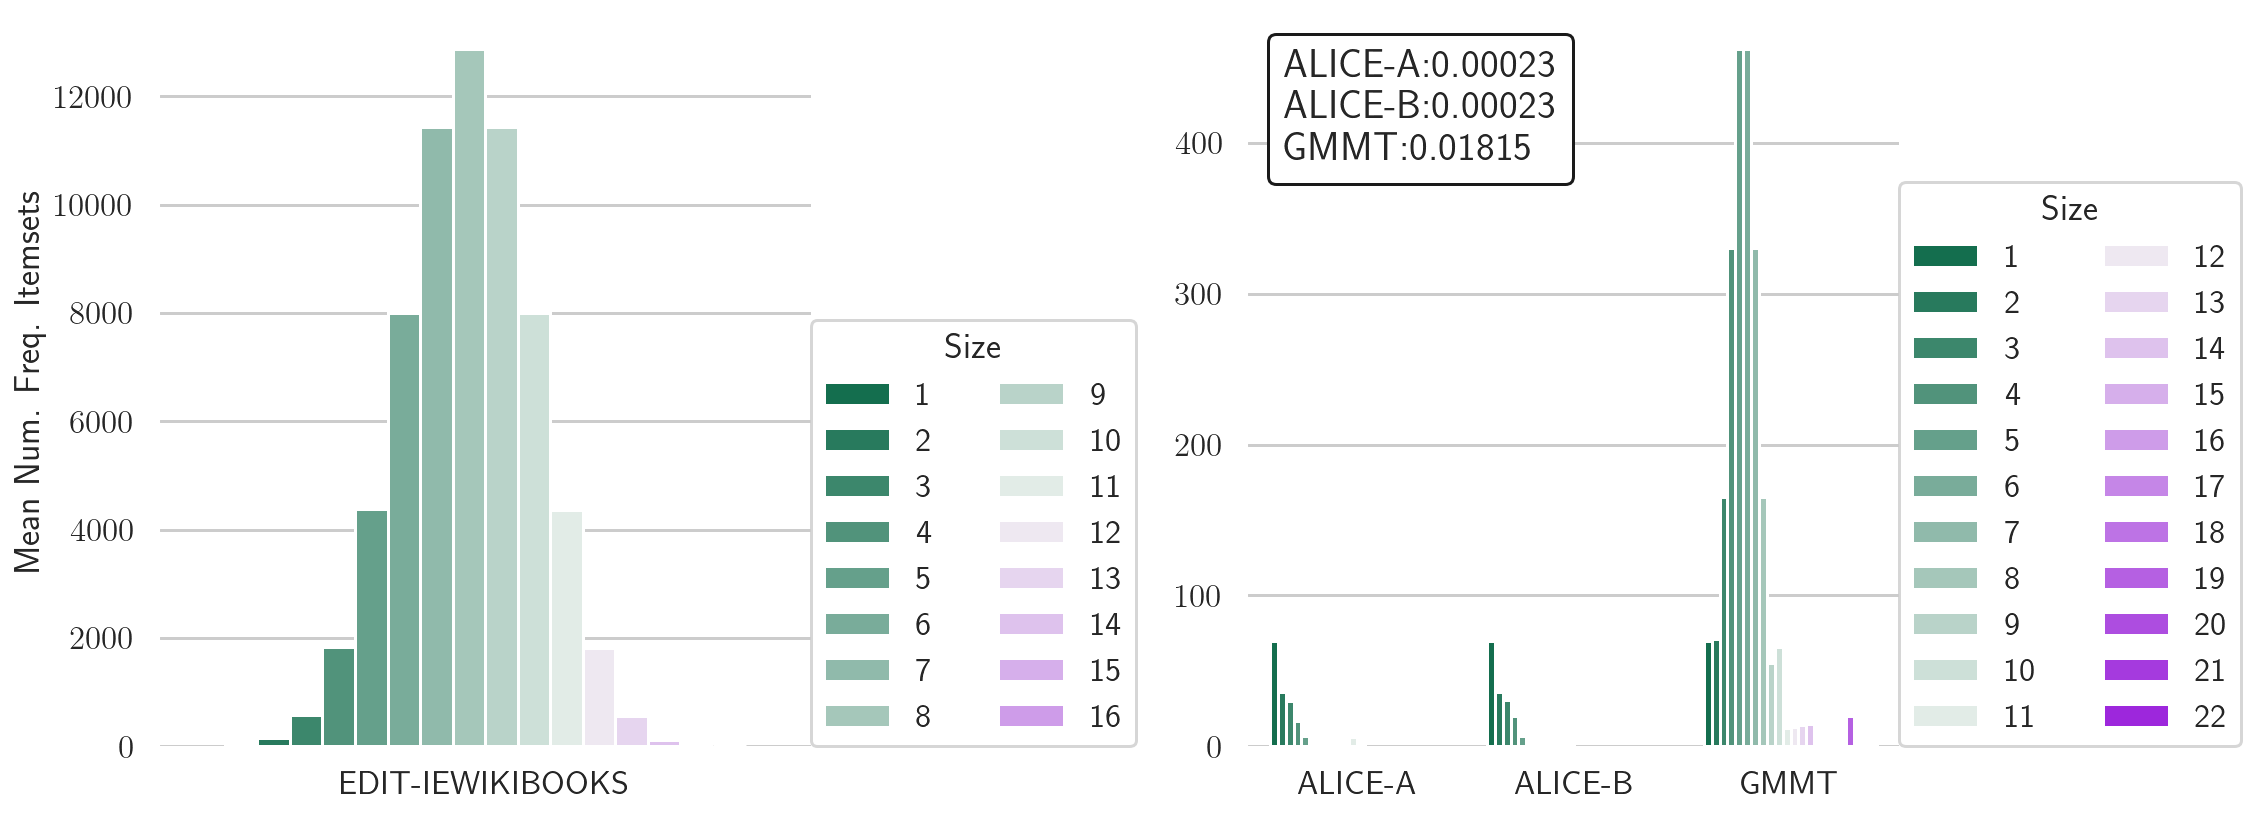

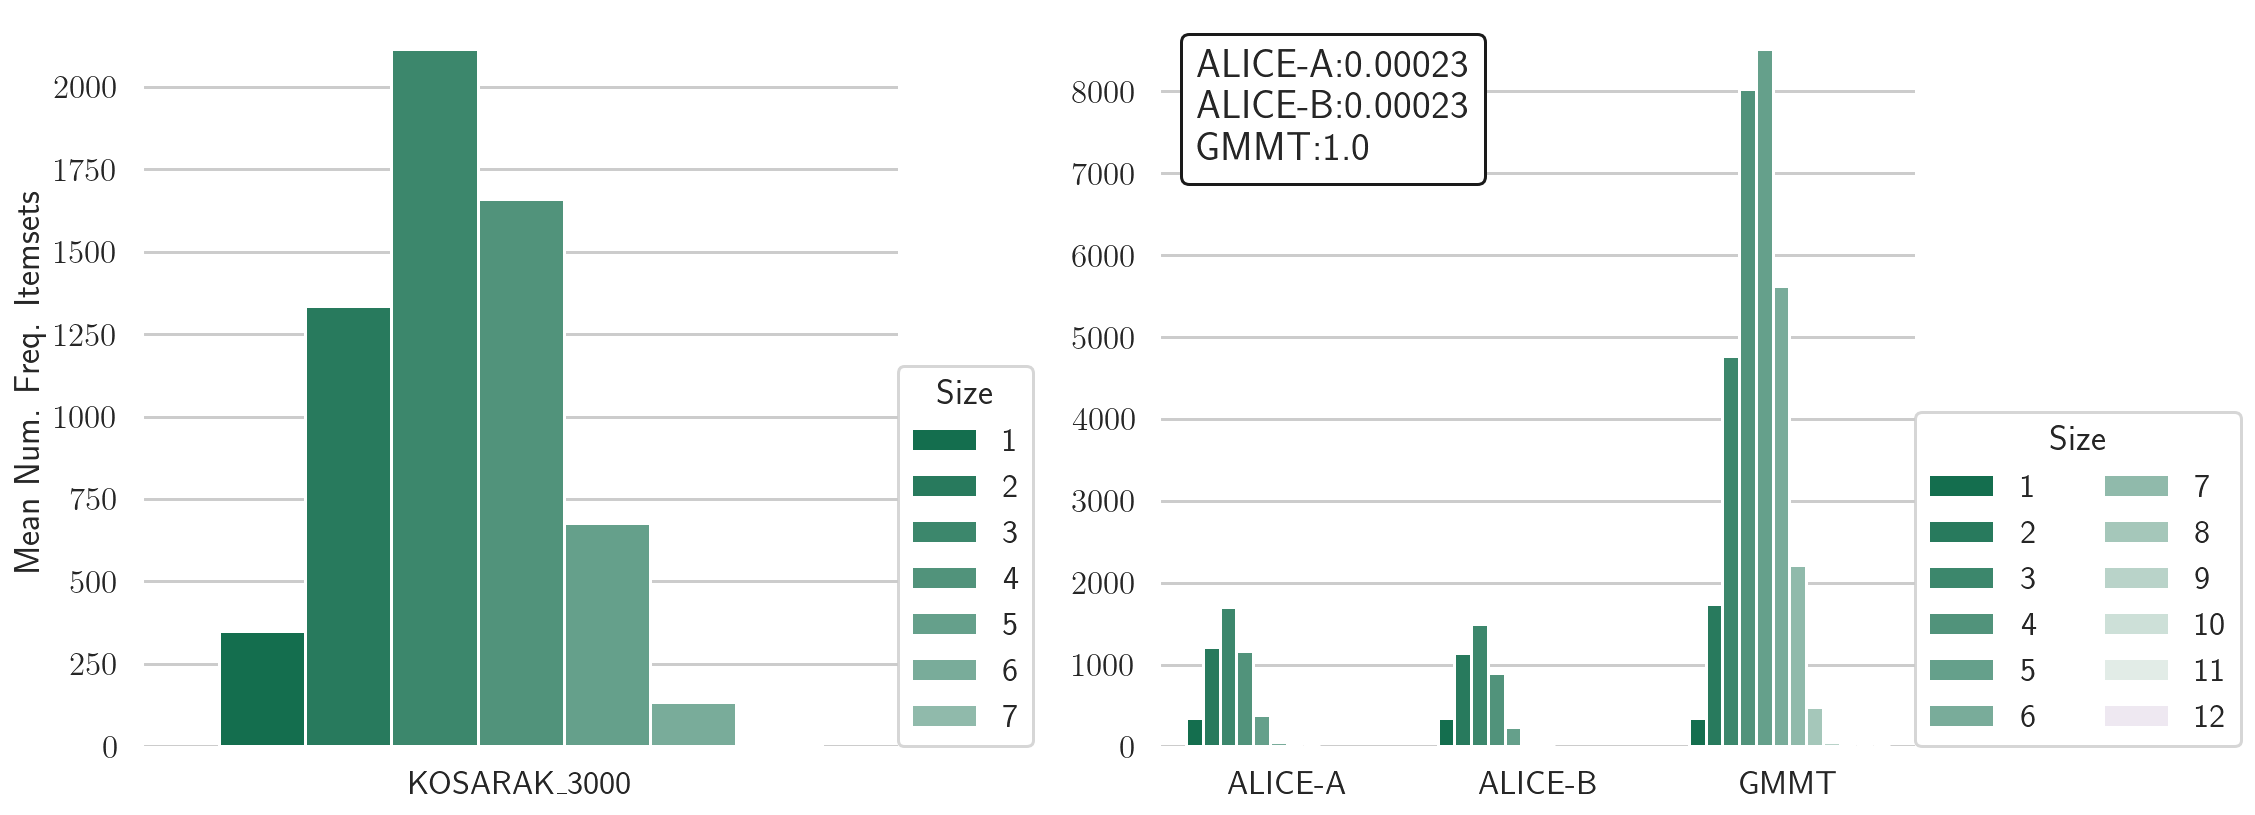

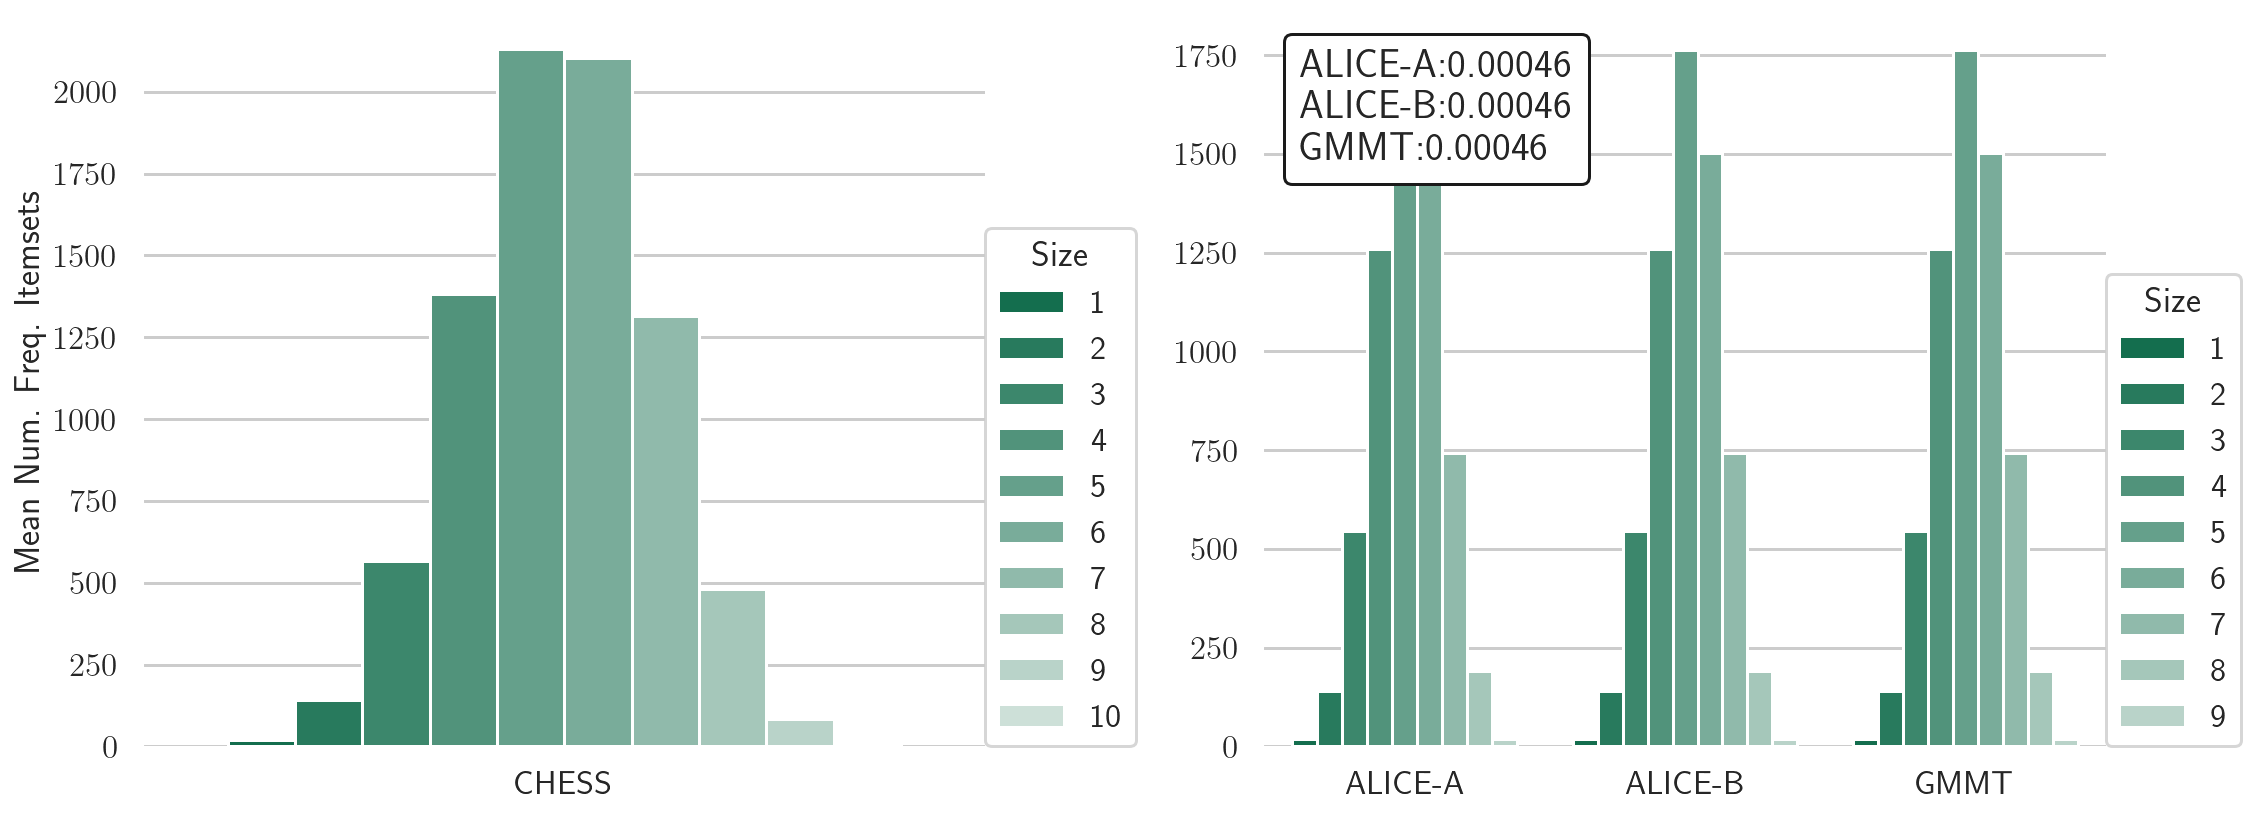

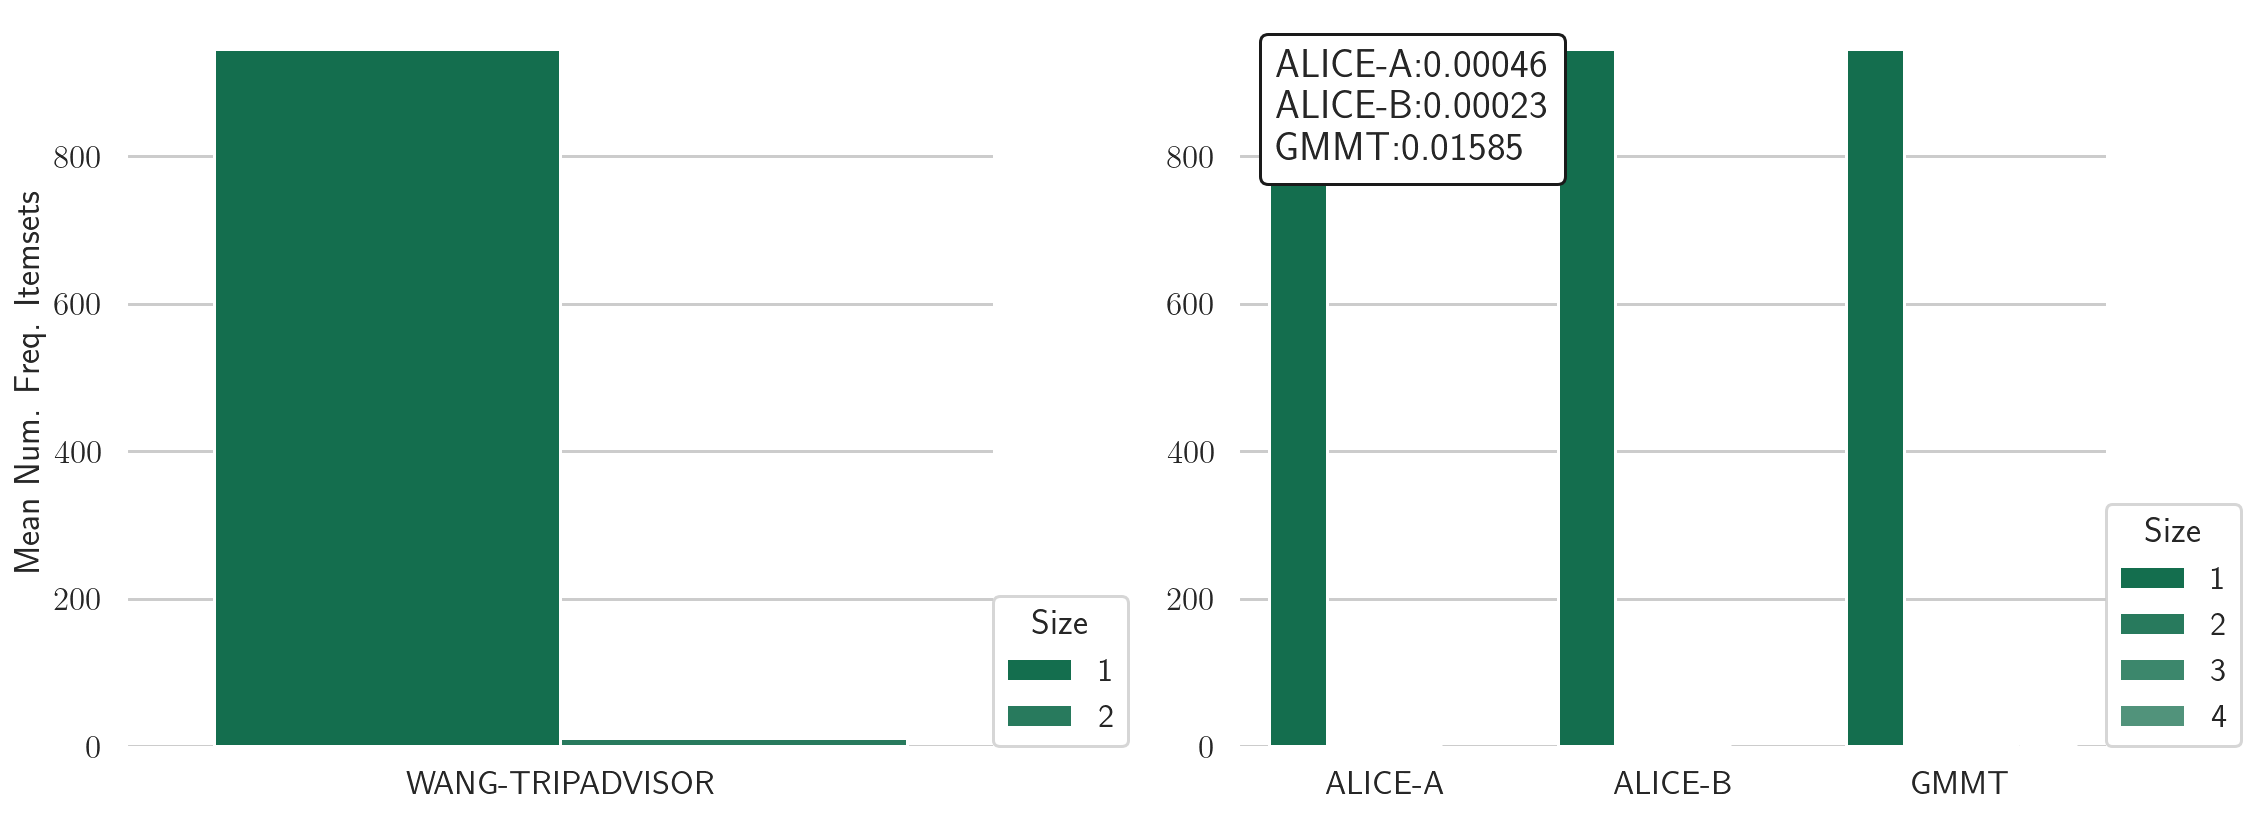

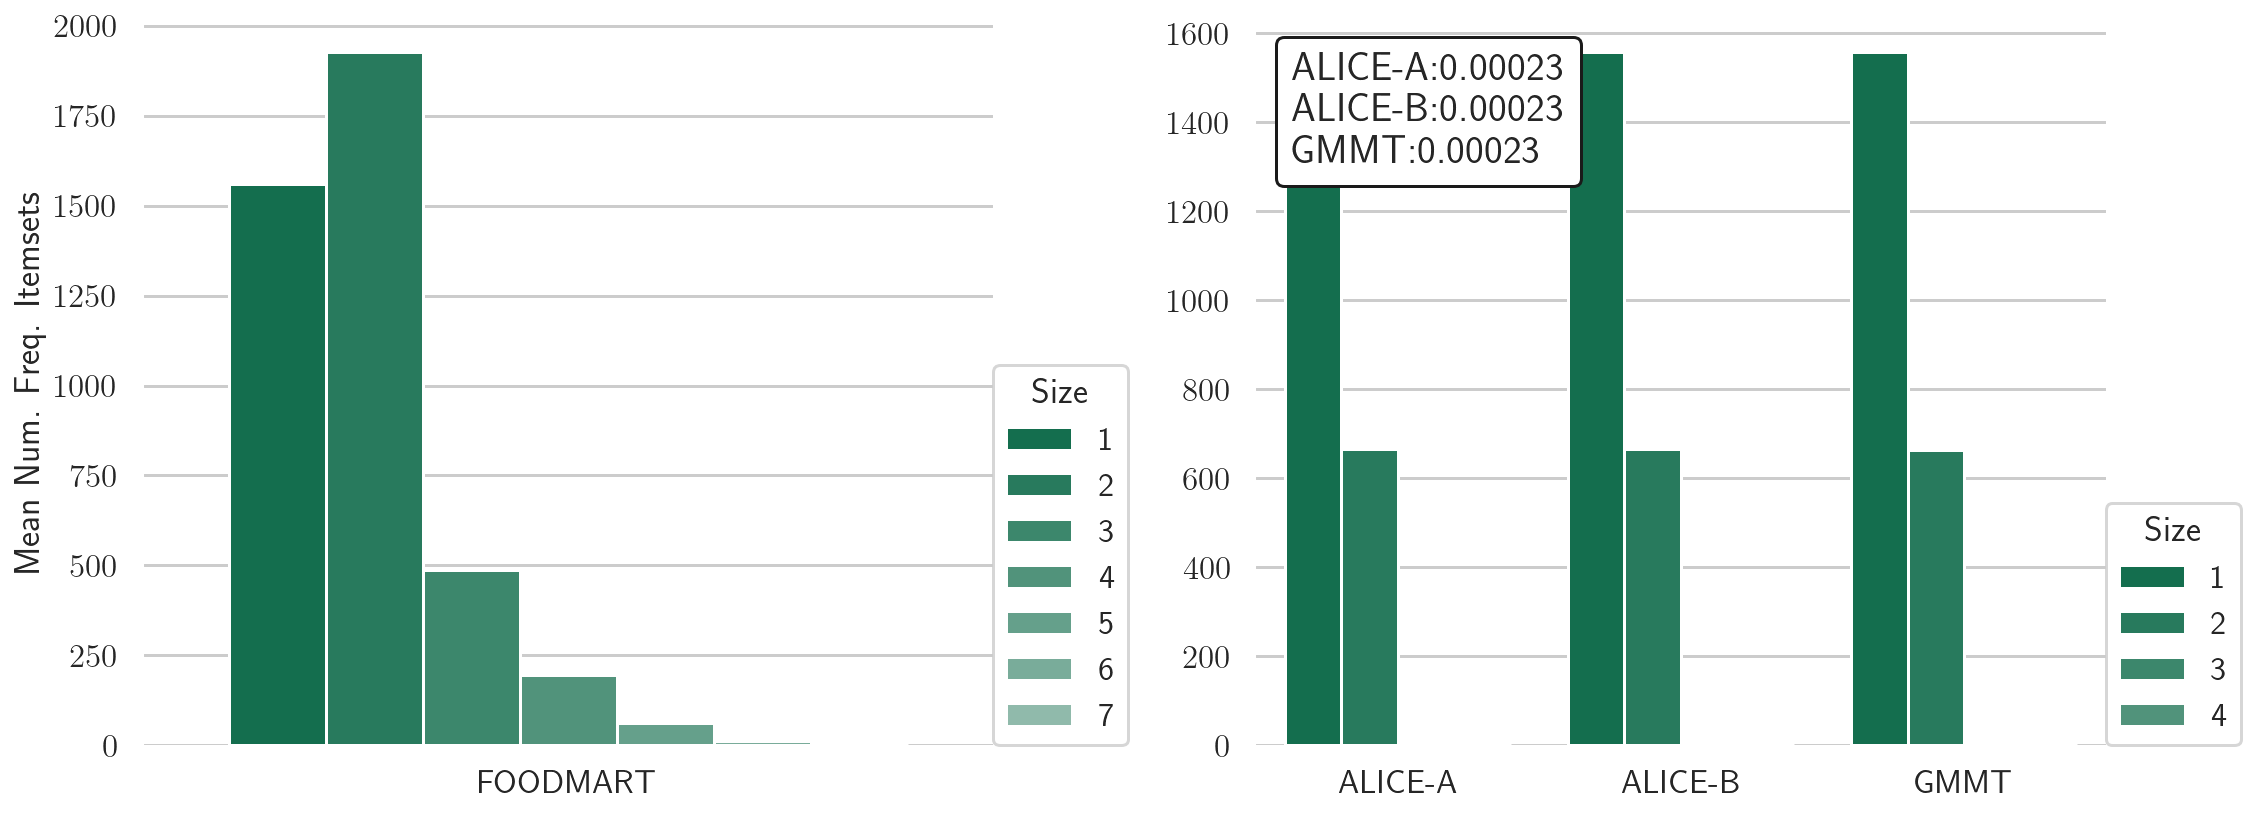

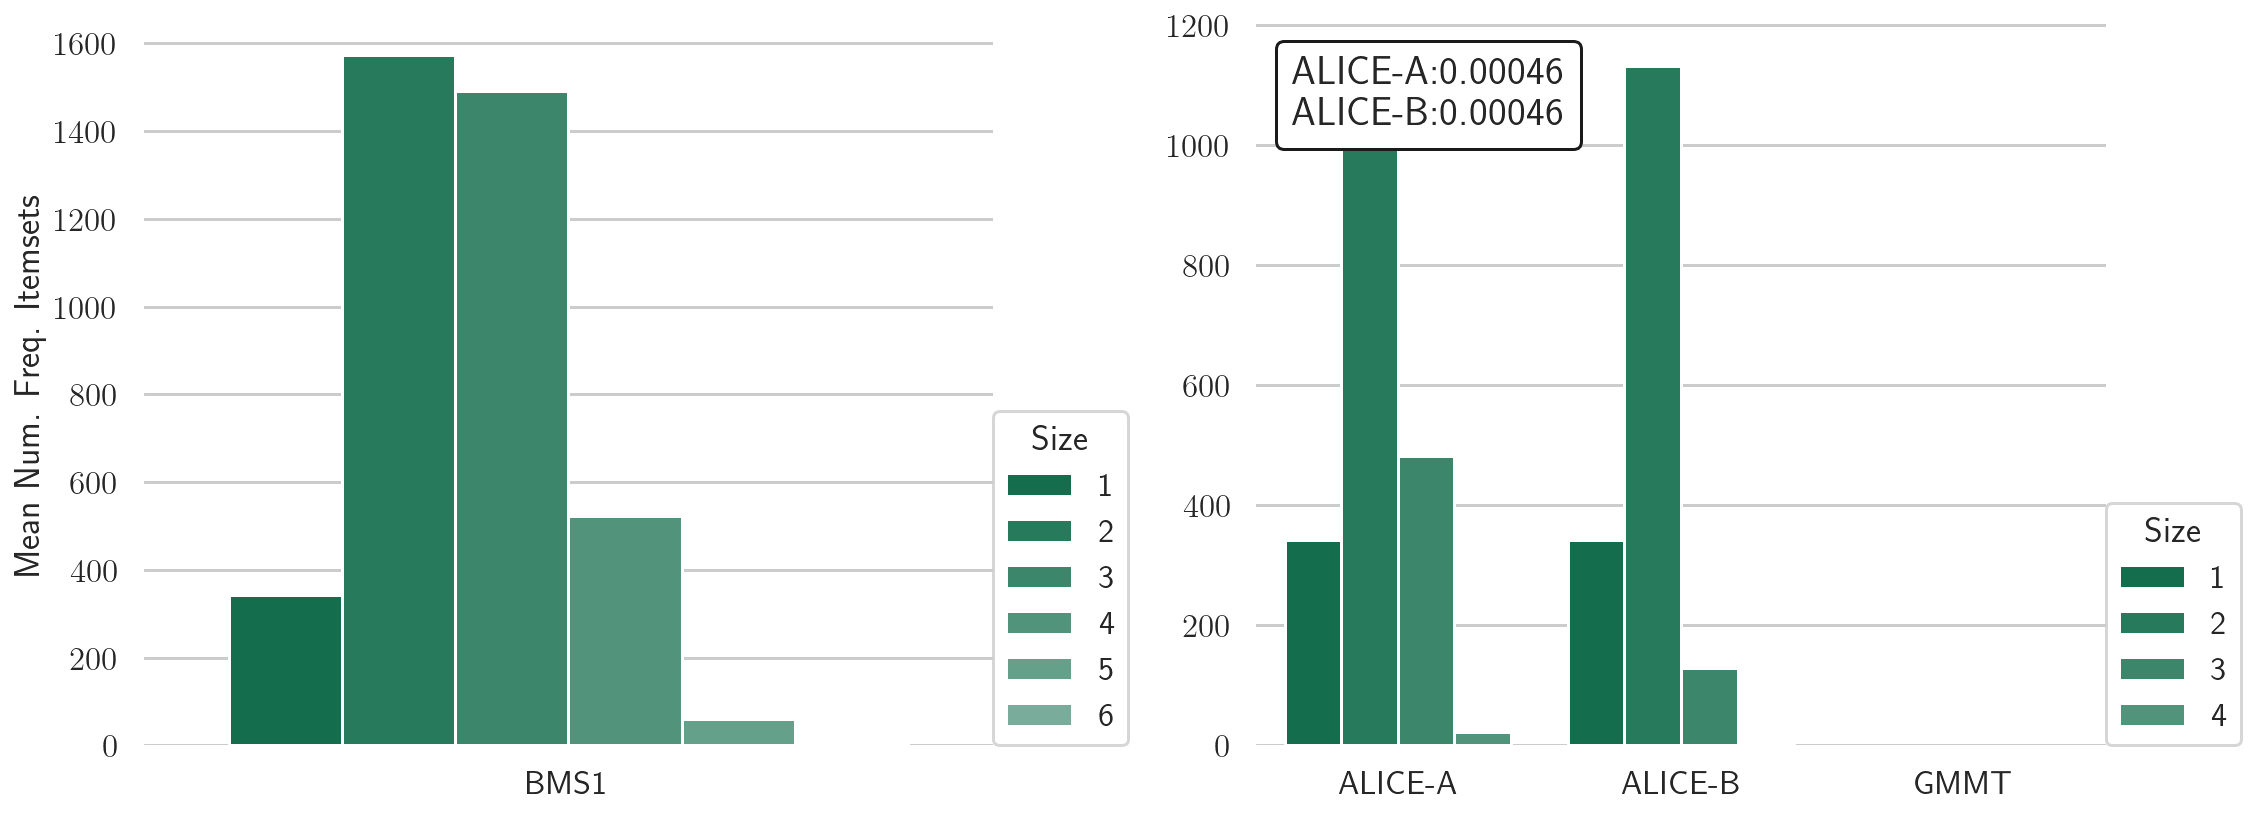

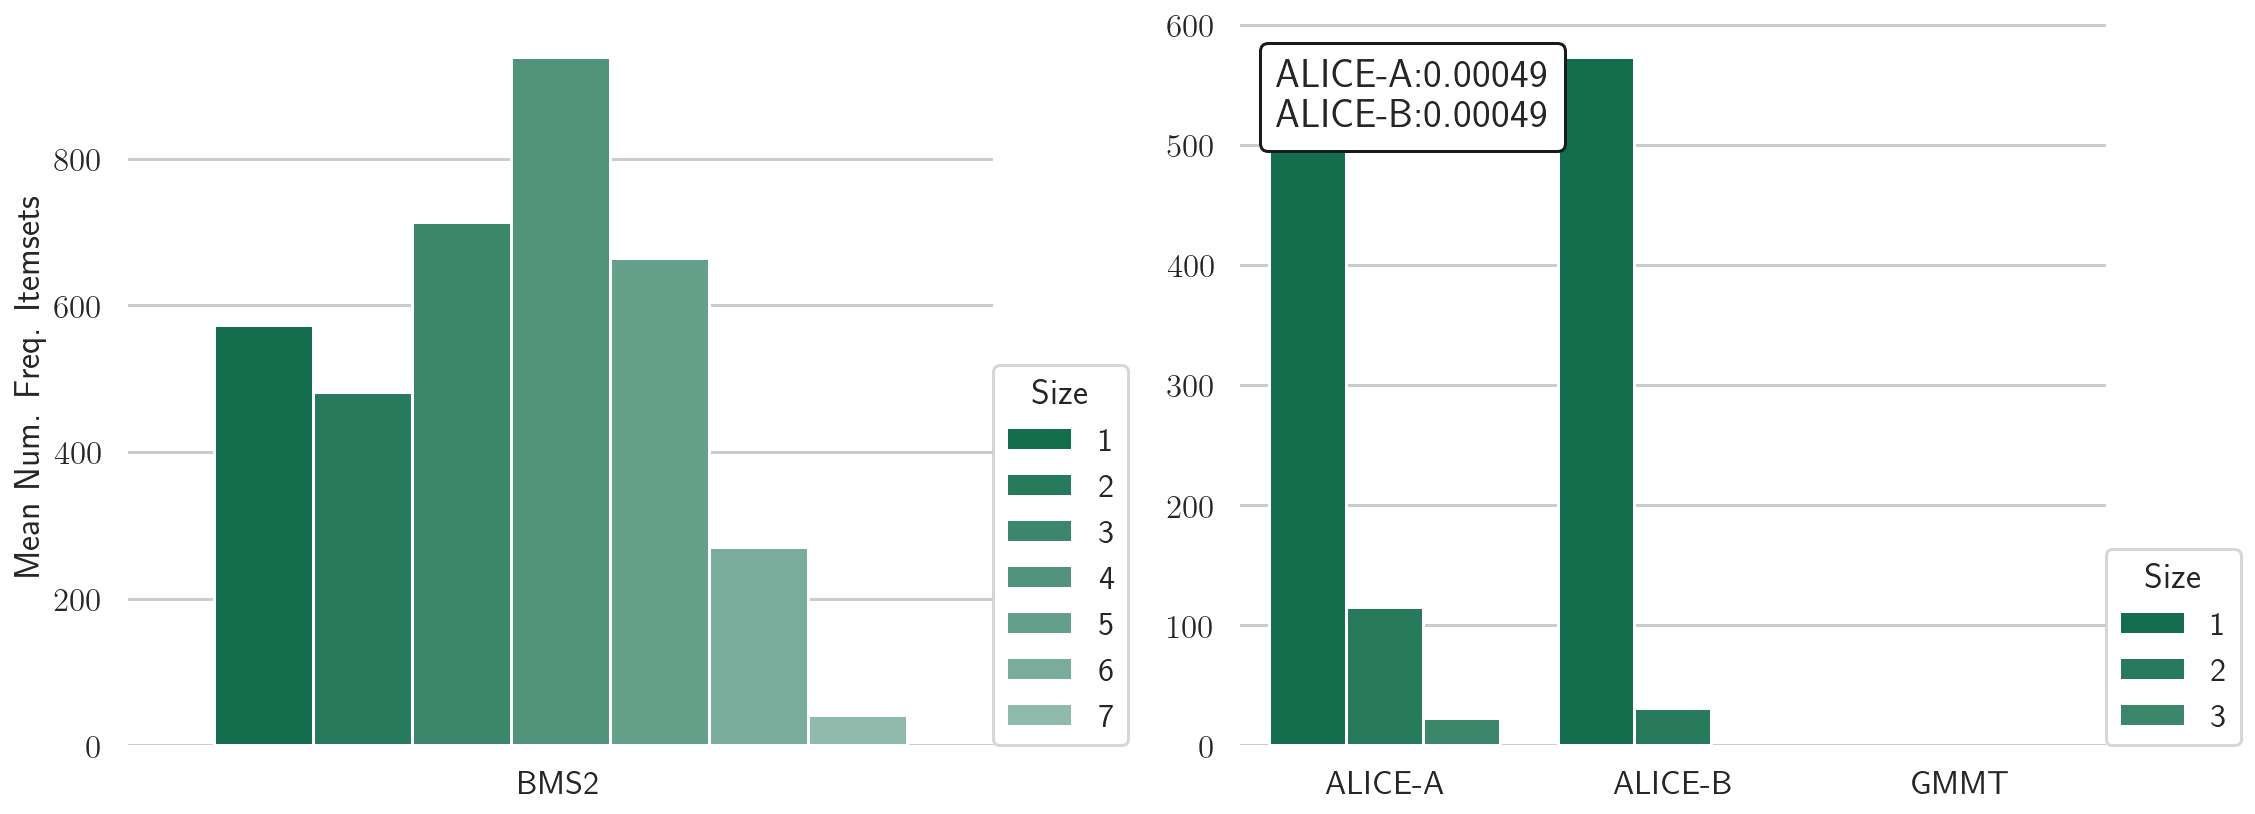

In [103]:
for db in db_config.keys():
    exact = numfreq_df[(numfreq_df['DataSet']==db) &
                       (numfreq_df['Algorithm']==db.upper())]
    data = numfreq_df[(numfreq_df['DataSet']==db) &
                      (numfreq_df['Algorithm'].isin(sampler_names.values()))]
    
    fig, ax = plt.subplots(1,2, figsize=(16,6))
    sns.barplot(data=exact, x='Algorithm', y='med', hue='Size', 
                ax=ax[0], palette=divpal)
    ncol = 1
    if exact['Size'].max() > 10:
        ncol = 2
    ax[0].legend(title='Size', loc=(1,0), ncol=ncol)
    ax[0].set_xlabel('')
    ax[0].set_ylabel('Mean Num. Freq. Itemsets')
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    
    sns.barplot(data=data, x='Algorithm', y='med', hue='Size', ax=ax[1],
                palette=divpal, order=['ALICE-A', 'ALICE-B', 'GMMT'])
    ncol = 1
    if data['Size'].max() > 10:
        ncol = 2
    ax[1].legend(title='Size', loc=(1,0), ncol=ncol)
    ax[1].set_xlabel('')
    ax[1].set_ylabel('')
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].spines['bottom'].set_visible(False)
    text = ''
    for entry in pvalues[db]:
        text += f'{entry["Algorithm"]}:{round(entry["pvalue"], 5)}\n'
    at = AnchoredText(text.strip(), prop=dict(size=20, weight='bold'),
                      frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[1].add_artist(at)
    plt.tight_layout()
    plt.savefig(fig_dir+f'{db}_numFreqItemsets.pdf')
    plt.show()

## Significant Itemset Mining

In [128]:
result_dir = '../output/significantItemsets'

In [129]:
db_config = {
            'edit-iewikibooks':'1953-4352-128-0.014-0.05-32-0',
#             'kosarak_3000':'23664-4352-128-0.003-0.05-32-0',
            'chess':'118252-2048-128-0.8-0.05-32-0',
            'wang-tripadvisor':'14520-4352-128-5.0E-4-0.05-32-0',
#             'foodmart':'27478-4352-128-3.0E-4-0.05-32-0',
            'dbpedia-occupation':'47316-4352-128-5.0E-4-0.05-32-0',
            'BMS1':'299278-1568-128-0.001-0.05-32-0',
            'BMS2':'716556-1568-128-0.002-0.05-32-0',
            'retail':'193568-1000-128-0.002-0.05-32-0'
            }

### Num Significant Itemsets by Size

In [130]:
dfs = []
for db,conf in db_config.items():
    for sampler in samplers:
        try:
            file = f'{result_dir}/{db}-{sampler}-{conf}.json'
            df = sig.get_itemsets_stats(file)
            df['Sampler'] = sampler
            df['DataSet'] = db
            dfs.append(df)
        except:
            pass
numItem_df = pd.concat(dfs)

In [131]:
numItem_df['Sampler'] = numItem_df['Sampler'].apply(lambda x : sampler_names[x])

In [132]:
summary = numItem_df[numItem_df['SSup'] != 0].groupby(by=['DataSet', 
                                                          'Sampler',
                                                          'Size']).agg({'SSup':'count'}).reset_index()

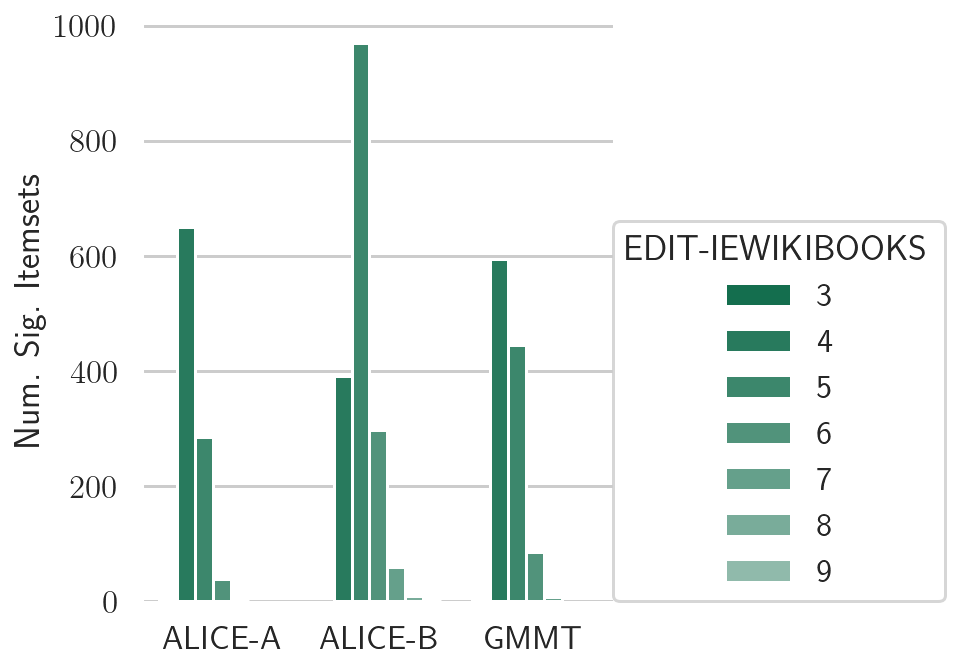

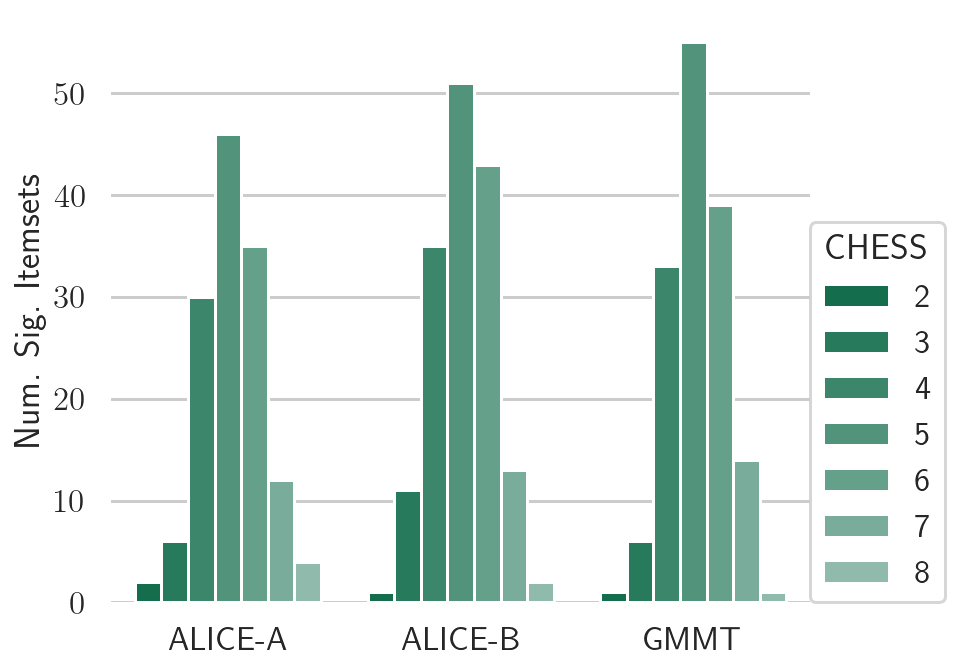

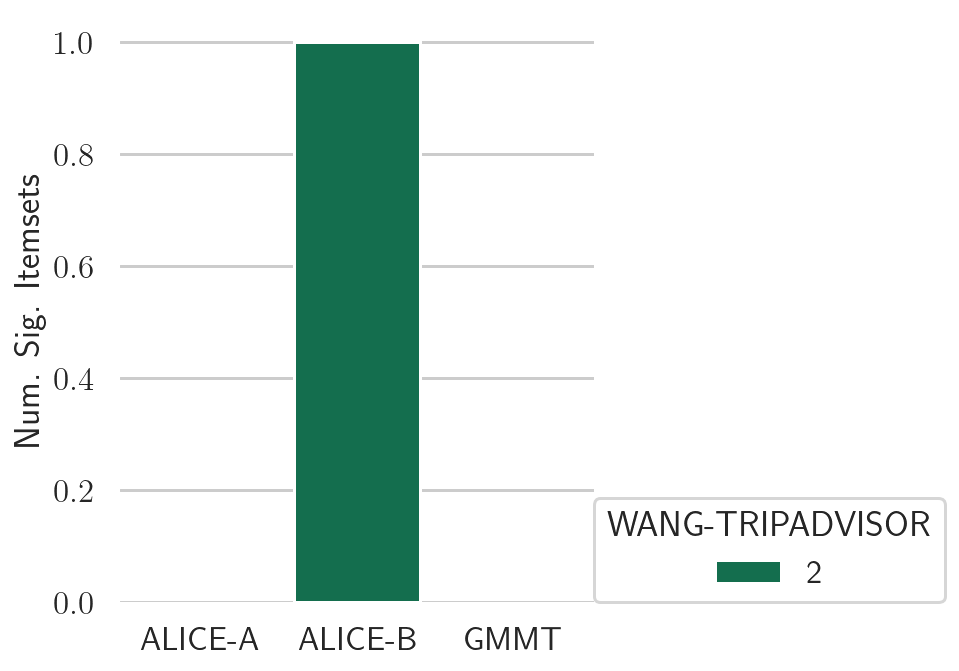

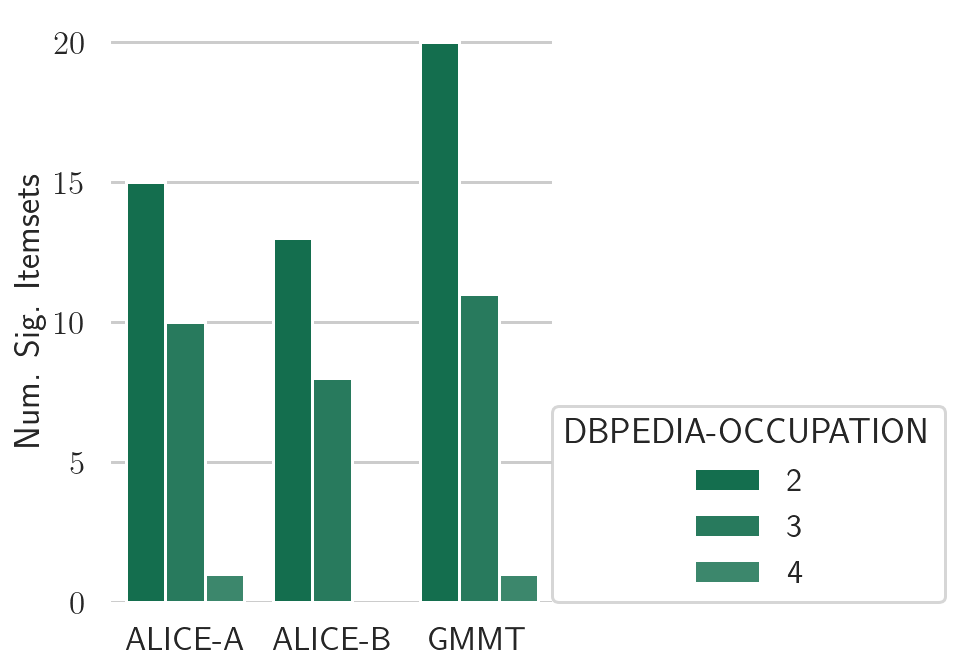

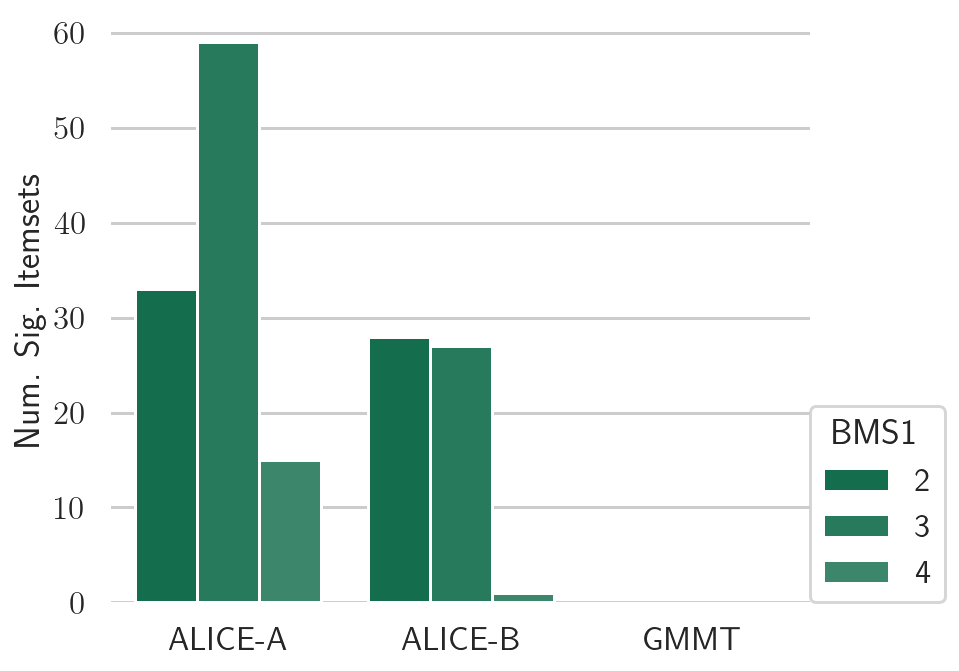

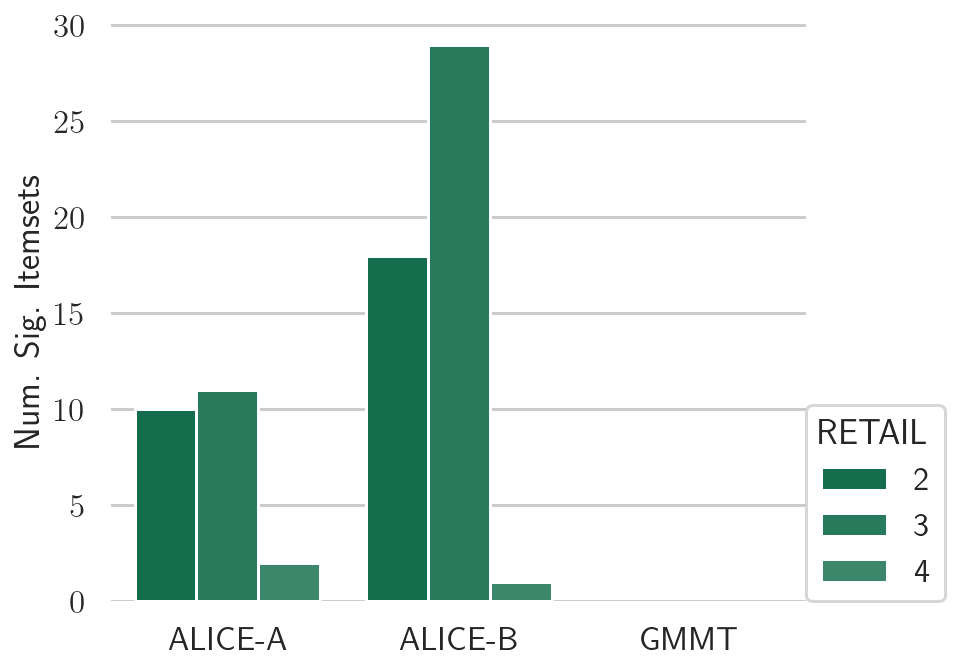

In [133]:
for db in db_config.keys():
    data = summary[summary['DataSet']==db]
    if data.empty: continue
    fig, ax = plt.subplots(figsize=(7,5))
    sns.barplot(data=data, x='Sampler', y='SSup', hue='Size', 
                palette=divpal, order=['ALICE-A', 'ALICE-B', 'GMMT'])
    ax.set_xlabel('')
    ax.set_ylabel('Num. Sig. Itemsets')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ncol = 1
    if data['Size'].max() > 10:
        ncol = 2
    ax.legend(title=db.upper(), loc=(1,0), ncol=ncol)
    plt.tight_layout()
    plt.savefig(fig_dir+f'{db}_numSigItemsets.pdf')
    plt.show()

### Similarity among Sets of Significant Itemsets

In [134]:
results = []
for db,conf in db_config.items():
    for p in combinations(samplers, 2):
        try:
            fileA = f'{result_dir}/{db}-{p[0]}-{conf}.json'
            fileB = f'{result_dir}/{db}-{p[1]}-{conf}.json'
            num_a, num_b, jac, a_diff_b, b_diff_a, a_in_b, b_in_a = sig.analyze(fileA, fileB)
            results.append([db, p[0], p[1], jac, a_diff_b, num_a, a_in_b])
            results.append([db, p[1], p[0], jac, b_diff_a, num_b, b_in_a])
        except Exception as e:
            pass
sig_df = pd.DataFrame(results)
sig_df.columns = ['DataSet', 'Algorithm', 'Other', 'Jaccard', 
                  'Difference', 'NumSignItemsets', 'isSubset']
sig_df['Algorithm'] = sig_df['Algorithm'].apply(lambda x: sampler_names[x])
sig_df['Other'] = sig_df['Other'].apply(lambda x: sampler_names[x])

edit-iewikibooks


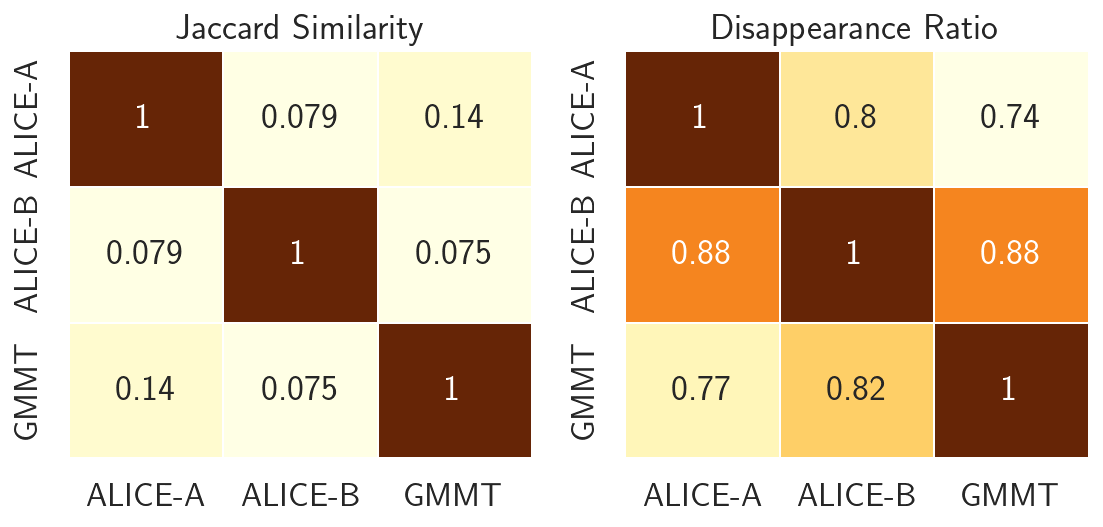

chess


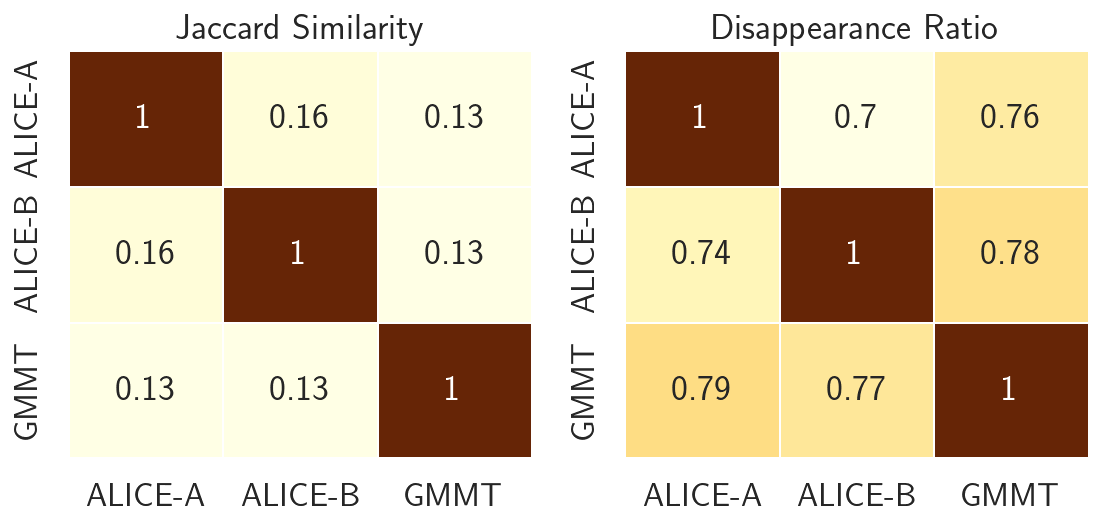

dbpedia-occupation


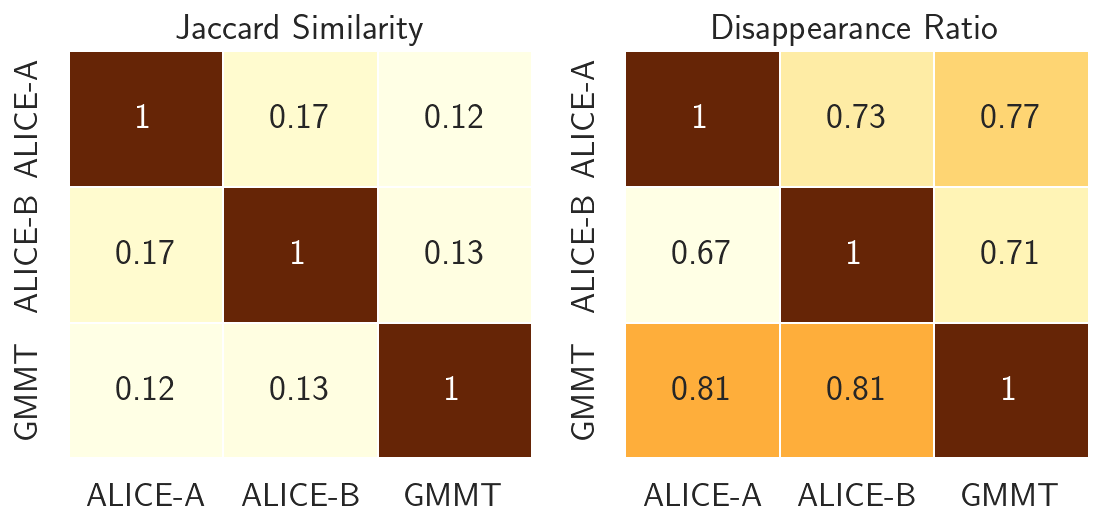

In [135]:
for dataset in sig_df['DataSet'].unique():
    data = sig_df[sig_df['DataSet']==dataset]
    if data.empty or data['NumSignItemsets'].sum()==0 or len(data['Algorithm'].unique()) < 3: continue

    fig, ax = plt.subplots(1,2,figsize=(8,4))
    print(dataset)
    # num significant itemsets
    sns.heatmap(data=data.pivot('Algorithm', 'Other', 'Jaccard').fillna(1),
                annot=True, linewidths=1, cmap="YlOrBr", cbar=False, ax=ax[0])
    ax[0].set_xlabel('')
    ax[0].set_ylabel('')
    ax[0].set_title('Jaccard Similarity')
    sns.heatmap(data=data.pivot('Algorithm', 'Other', 'Difference').fillna(1),
                annot=True, linewidths=1, cmap="YlOrBr", cbar=False, ax=ax[1])
    ax[1].set_xlabel('')
    ax[1].set_ylabel('')
    ax[1].set_title('Disappearance Ratio')
    plt.tight_layout()
    plt.savefig(fig_dir+f'{dataset}_sigFreqItemsetsComp.pdf')
    plt.show()

## BJDM

- We generated 1000 samples.
- We performed 1000 steps.
- We created a BJDM vector of size maxRowSum * maxColSum, concatenating the values of the BJDM.
- We normalized the vector by the number of edges.
- Every 100 steps, we stored the EarthMoversDistance between the original BJDM vector and the current one.

In [120]:
result_dir = '../output/bjdm'
samps = ['caterpillars.samplers.NaiveBJDMSampler',
            'diffusr.samplers.GmmtSampler']
swaps = {'foodmart':1000,
         'BMS2':1000,
         'edit-iewikibooks':4352,
         'dbpedia-occupation':4352,
         'kosarak_3000':4352,
         'wang-tripadvisor':4352}

In [121]:
dfs = []
for db in datasets:
    if db not in swaps: continue
    file_name = f'{result_dir}/{db}-10000-{swaps[db]}-0.json'
    with open(file_name) as f:
        stats = json.load(f)['runtimeStats']
        for sampler in samps:
            samplers_stats = stats[sampler]
            obs = len(samplers_stats["minDist"])
            distances = list()
            distances.extend(samplers_stats["minDist"])
            distances.extend(samplers_stats["c10Dist"])
            distances.extend(samplers_stats["q1Dist"])
            distances.extend(samplers_stats["meanDist"])
            distances.extend(samplers_stats["q3Dist"])
            distances.extend(samplers_stats["c90Dist"])
            distances.extend(samplers_stats["maxDist"])
            tmp = pd.DataFrame(distances)
            tmp['DataSet'] = db
            tmp['Sampler'] = sampler
            dfs.append(tmp)

In [122]:
bjdm_df = pd.concat(dfs)

In [123]:
bjdm_df.columns = ['Distance', 'DataSet', 'Sampler']

In [124]:
bjdm_df['Sampler'] = bjdm_df['Sampler'].apply(lambda x: sampler_names[x])
bjdm_df['DataSet'] = bjdm_df['DataSet'].apply(lambda x: x.upper())

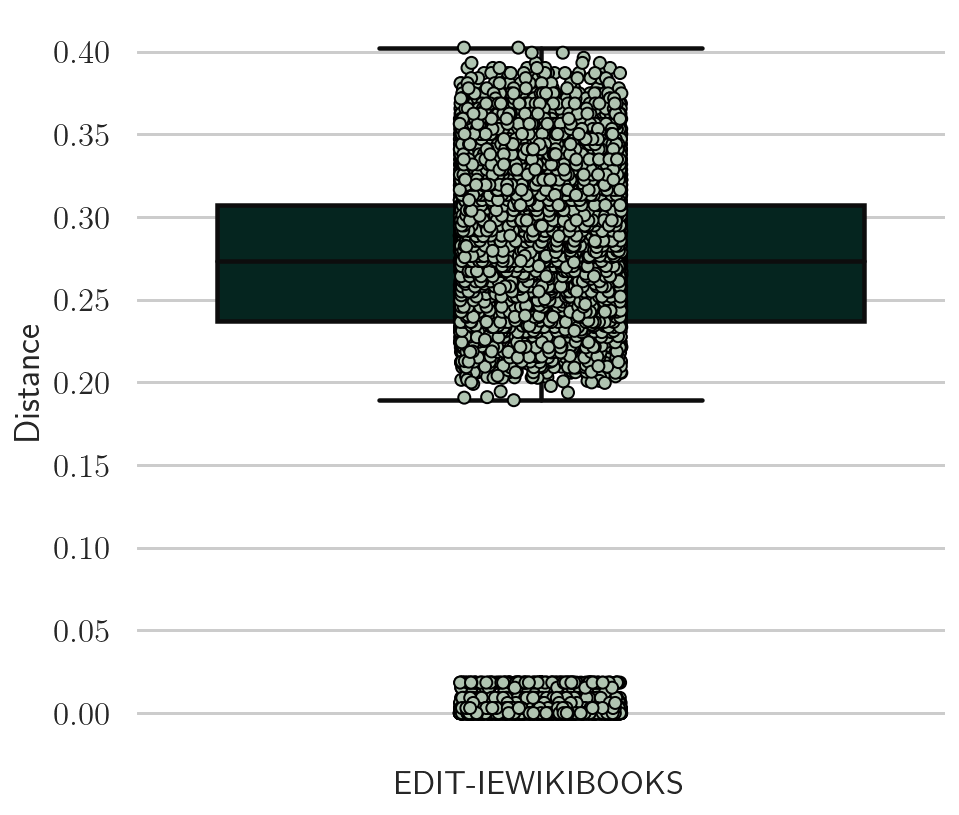

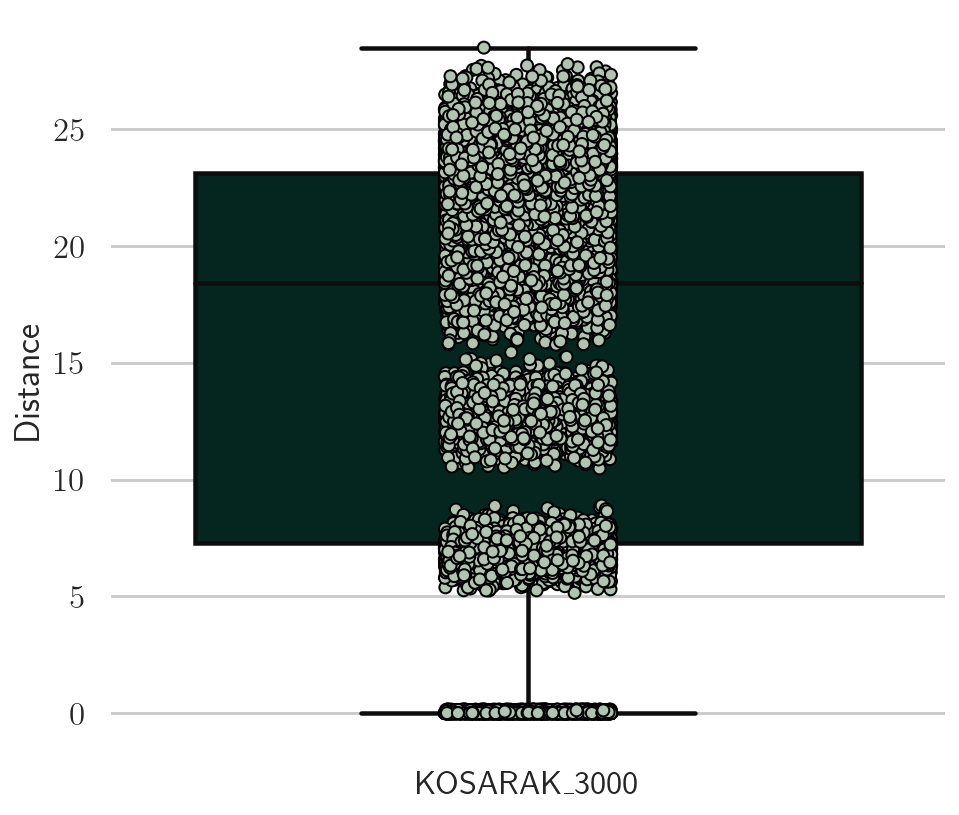

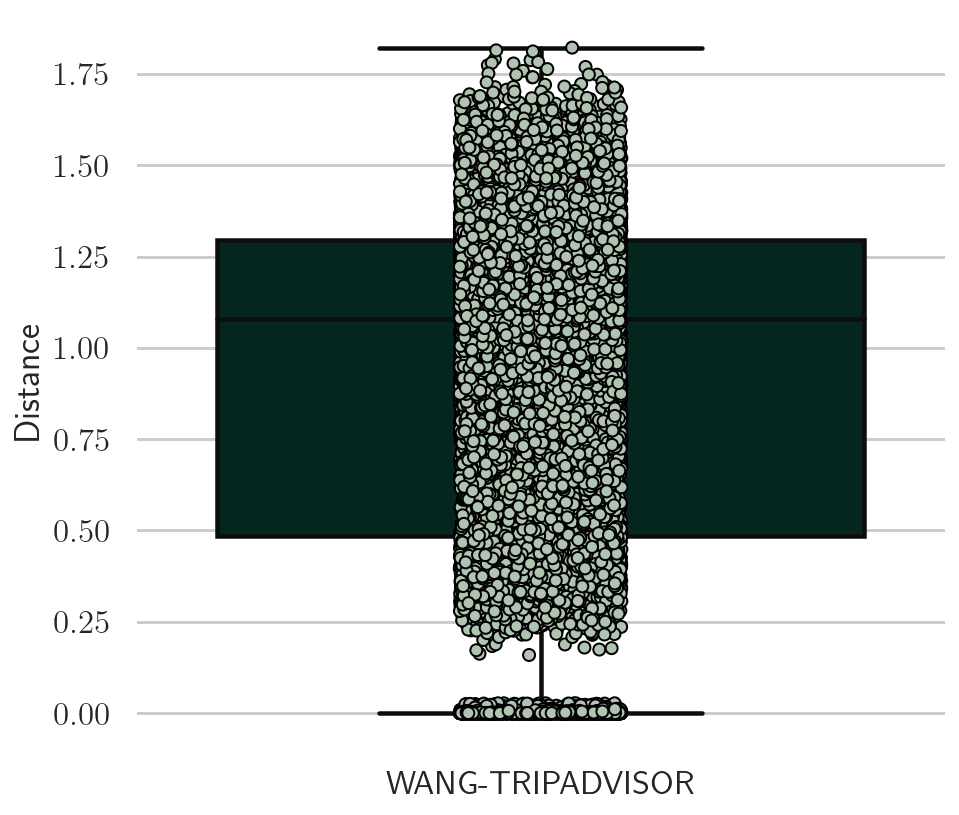

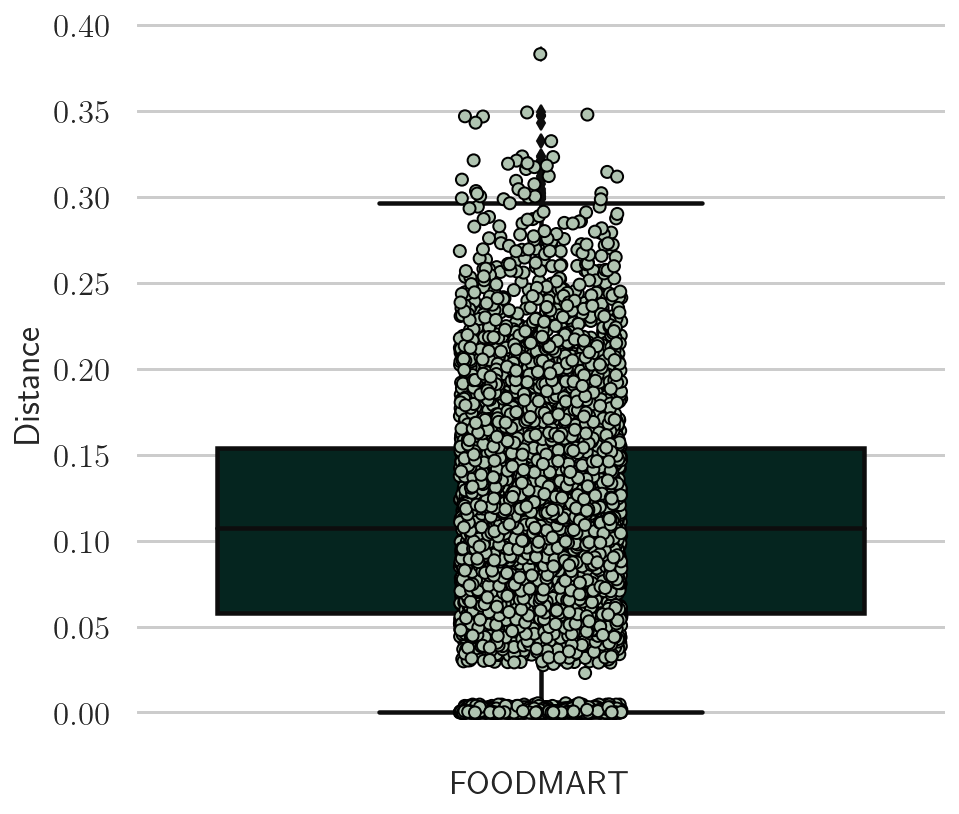

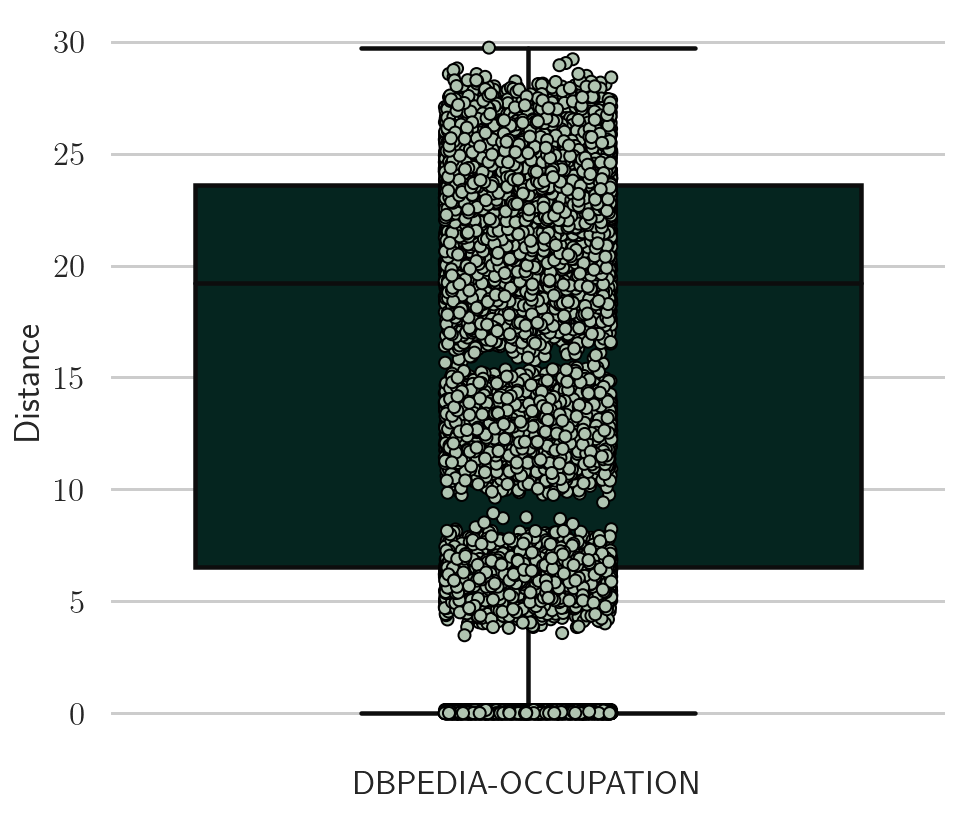

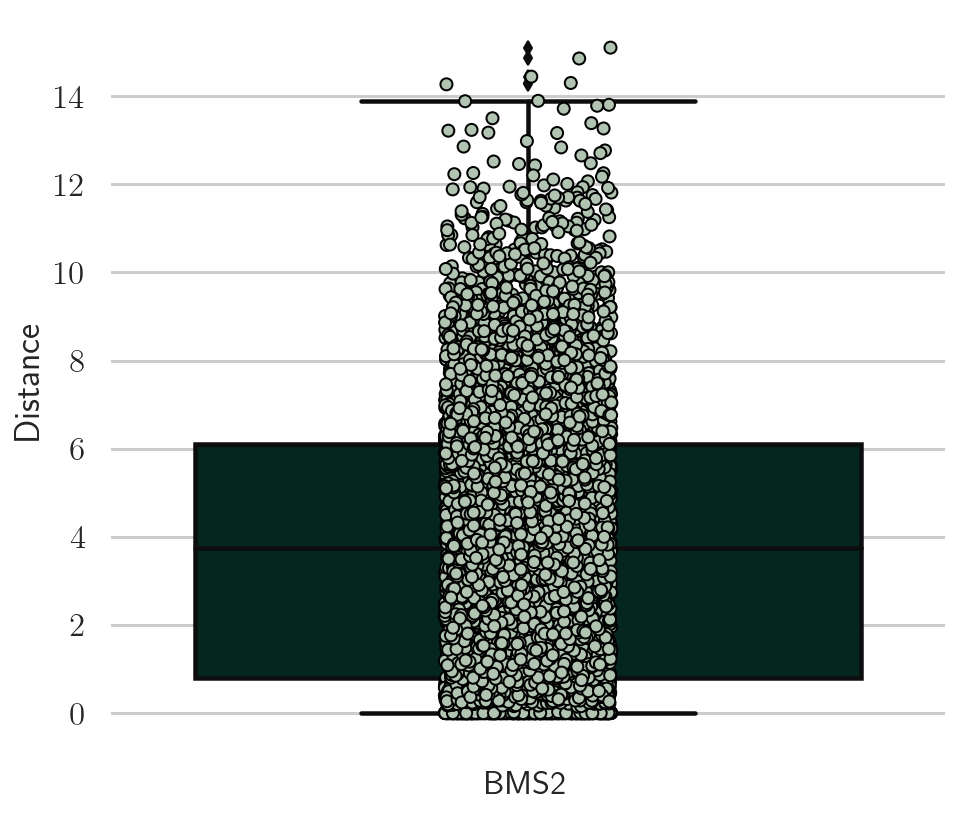

In [126]:
for db in bjdm_df['DataSet'].unique():
    data = bjdm_df[(bjdm_df['Sampler']=='GMMT') &
                   (bjdm_df['DataSet']==db)]
    if data['Distance'].sum() > 0:
        fig, ax = plt.subplots(figsize=(7,6))
        sns.boxplot(data=data, x='DataSet', y='Distance',
                    dodge=True, palette=palette[4:], ax=ax)
        sns.stripplot(data=data, x='DataSet', y='Distance',
                      edgecolor='black', size=6, linewidth=1,
                      palette=palette[3:], ax=ax)
        ax.set_xlabel('')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        plt.tight_layout()
        plt.savefig(fig_dir+f'{db}_bjdm.pdf')
        plt.show()